In [1]:
import os
import random
import numpy as np
import sys
import torch
import pprint

root = '/'
pprint.pprint(sys.path)

sys.path.append(import_path)
pprint.pprint(sys.path)

['/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/opt/conda/lib/python3.10/site-packages']


In [2]:
import os
import sys
import pprint

import_path = root + 'pigvae_all'
sys.path.append(import_path)
pprint.pprint(sys.path)

import_path1 = root + 'pigvae_all/pigvae'
sys.path.append(import_path1)
pprint.pprint(sys.path)

import_path2 = root + 'ddpm-torch'
sys.path.append(import_path2)
pprint.pprint(sys.path)

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data.distributed import DistributedSampler
import random
#import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from networkx.algorithms.shortest_paths.dense import floyd_warshall_numpy

from networkx.generators.random_graphs import *
from networkx.generators.ego import ego_graph
from networkx.generators.geometric import random_geometric_graph

/opt/conda/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /opt/conda/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/conda/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /opt/conda/lib/python3.10/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/opt/conda/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /opt/conda/lib/python3.10/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
num_node_f, num_edge_f = 43, 6

In [8]:
hparams = {
    "vae":False,
    "kld_loss_scale":0.01,
    "perm_loss_scale":0.1,
    "property_loss_scale":0.5,
    "num_node_features":num_node_f,
    "num_edge_features":6+num_edge_f+1,
    "emb_dim": 90,
    'graph_encoder_hidden_dim': 256,
    'graph_encoder_k_dim': 64,
    'graph_encoder_v_dim': 64,
    'graph_encoder_num_heads': 16,
    'graph_encoder_ppf_hidden_dim': 512,
    'graph_encoder_num_layers': 16,
    'graph_decoder_hidden_dim': 256,
    'graph_decoder_k_dim': 64,
    'graph_decoder_v_dim': 64,
    'graph_decoder_num_heads': 16,
    'graph_decoder_ppf_hidden_dim': 512,
    'graph_decoder_num_layers': 16,
    "graph_decoder_pos_emb_dim": 64,
    'property_predictor_hidden_dim': 3,
    'num_properties': 1
}

model_load_dir = root + 'save_models/zinc/pig-ae_models/'
model_save_dir = root + 'save_models/zinc/pig-ae_models/ddpm/'

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [9]:
trn_path = model_load_dir + "trn_z_tensor.pt"
val_path = model_load_dir + "val_z_tensor.pt"

trn_z_tensor = torch.load(trn_path)
val_z_tensor = torch.load(val_path)

In [11]:
latent_mu = torch.mean(trn_z_tensor, dim=0)
latent_std = torch.std(trn_z_tensor, dim=0)

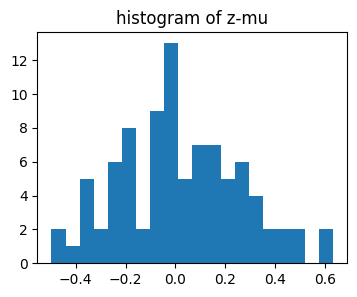

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(4,3))
plt.title("histogram of z-mu")
plt.hist(latent_mu.numpy().reshape(-1), bins=20)
plt.show()

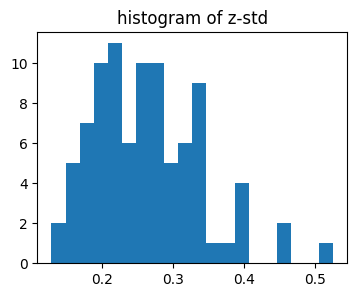

In [14]:
plt.figure(figsize=(4,3))

plt.title("histogram of z-std")
plt.hist(latent_std.numpy().reshape(-1), bins=20)
plt.show()

In [10]:
trn_dataset = torch.utils.data.TensorDataset(trn_z_tensor)
val_dataset = torch.utils.data.TensorDataset(val_z_tensor)

In [11]:
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)

# DDPM class

In [12]:
import os
import torch
import numpy as np
from torch.optim import Adam, lr_scheduler
from ddpm_torch.utils import seed_all, infer_range
from ddpm_torch.toy import *

import torch
import torch.nn as nn

from ddpm_torch.modules import Linear, Sequential
from ddpm_torch.functions import get_timestep_embedding


DEFAULT_NORMALIZER = nn.LayerNorm
DEFAULT_NONLINEARITY = nn.LeakyReLU(negative_slope=0.02, inplace=True)


class TemporalLayer(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, out_features, temporal_features):
        super(TemporalLayer, self).__init__()
        self.norm1 = self.normalize(in_features)
        self.fc1 = Linear(in_features, out_features, bias=False)
        self.norm2 = self.normalize(out_features)
        self.fc2 = Linear(out_features, out_features, bias=False)
        self.enc = Linear(temporal_features, out_features)

        self.skip = nn.Identity() if in_features == out_features else Linear(in_features, out_features, bias=False)

    def forward(self, x, t_emb):
        out = self.fc1(self.nonlinearity(self.norm1(x)))
        out += self.enc(t_emb)
        out = self.fc2(self.nonlinearity(self.norm2(out)))
        skip = self.skip(x)
        return out + skip


class Denoiser(nn.Module):
    normalize = DEFAULT_NORMALIZER
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, mid_features, num_temporal_layers):
        super(Denoiser, self).__init__()

        self.in_fc = Linear(in_features, mid_features, bias=False)
        self.temp_fc = Sequential(*([TemporalLayer(
            mid_features, mid_features, mid_features), ] * num_temporal_layers))
        self.out_norm = self.normalize(mid_features)
        self.out_fc = Linear(mid_features, in_features)
        self.t_proj = nn.Sequential(
            Linear(mid_features, mid_features),
            self.nonlinearity)
        self.mid_features = mid_features

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.mid_features)
        t_emb = self.t_proj(t_emb)
        out = self.in_fc(x)
        out = self.temp_fc(out, t_emb=t_emb)
        out = self.out_fc(self.out_norm(out))
        return out

In [13]:
model_mean_type = "eps"
model_var_type = "fixed-large"
loss_type = "mse"
lat_dim = 90
in_features = lat_dim
out_features = 2 * in_features if model_var_type == "learned" else in_features
mid_features = 256
num_temporal_layers = 3

In [14]:
# diffusion parameters
beta_schedule = "linear"
beta_start, beta_end = 0.001, 0.2
timesteps = 1000
betas = get_beta_schedule(beta_schedule, beta_start=beta_start, beta_end=beta_end, timesteps=timesteps)

In [15]:
ddpm = Denoiser(in_features, mid_features, num_temporal_layers).to(device)
diff_p = GaussianDiffusion(betas=betas, model_mean_type=model_mean_type, model_var_type=model_var_type, loss_type=loss_type)

In [16]:
import torch.optim as optim

optimizer = optim.Adam(ddpm.parameters(), lr=1e-4)

In [17]:
train_loss_list = []
val_loss_list = []

def val_preds(epoch):

    ddpm.eval()

    sum_errors = 0

    for batch_idx, batch_data in enumerate(val_loader):

        with torch.no_grad():

            z_0 = batch_data[0]
            z_0 = z_0.to(device)

            B = z_0.shape[0]
            T = timesteps
            t = torch.randint(T, size=(B, ), dtype=torch.int64, device=device)
            t_noise = torch.randn_like(z_0)
            z_t = diff_p.q_sample(z_0, t, noise=t_noise)
            model_out = ddpm(z_t, t)

            optimizer.zero_grad()
        
            loss = torch.sum((t_noise - model_out).pow(2), dim = 1).mean()

            if batch_idx % 10 == 0:
                print("Epoch (val) : ", epoch, " Batch : ", batch_idx, " Loss : ", loss.data.item())

            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()

    return sum_errors

In [18]:
num_epochs = 500
best_loss = 10000000

for epoch in range(num_epochs):
    ddpm.train()

    sum_errors = 0

    for batch_idx, batch_data in enumerate(trn_loader):

        z_0 = batch_data[0]
        z_0 = z_0.to(device)
        
        B = z_0.shape[0]
        T = timesteps
        t = torch.randint(T, size=(B, ), dtype=torch.int64, device=device)
        t_noise = torch.randn_like(z_0)
        z_t = diff_p.q_sample(z_0, t, noise=t_noise)
        model_out = ddpm(z_t, t)

        optimizer.zero_grad()
        
        loss = torch.sum((t_noise - model_out).pow(2), dim = 1).mean()

        if batch_idx % 10 == 0:
            print("Epoch : ", epoch, " Batch : ", batch_idx, " Loss : ", loss.data.item())

        sum_errors = sum_errors + loss.data.item()
        loss.backward()

        optimizer.step()

        del loss
        torch.cuda.empty_cache()

    train_loss_list.append(sum_errors / len(trn_loader))
    val_loss = val_preds(epoch) / len(val_loader)
    val_loss_list.append(val_loss)

    np.save(model_save_dir + "train_loss_hist", np.array(train_loss_list))
    np.save(model_save_dir + "val_loss_hist", np.array(val_loss_list))

    if val_loss < best_loss:
        save_model_path = model_save_dir + "ddpm_best_model" + ".pt"
        torch.save(ddpm, save_model_path)

        optimizer_path = model_save_dir + "opt_best_model" + ".pt"
        torch.save(optimizer.state_dict(), optimizer_path)

        best_loss = val_loss

Epoch :  0  Batch :  0  Loss :  215.13999938964844
Epoch :  0  Batch :  10  Loss :  154.82798767089844
Epoch :  0  Batch :  20  Loss :  124.7595443725586
Epoch :  0  Batch :  30  Loss :  114.90713500976562
Epoch :  0  Batch :  40  Loss :  105.28456115722656
Epoch :  0  Batch :  50  Loss :  101.52835083007812
Epoch :  0  Batch :  60  Loss :  100.36910247802734
Epoch :  0  Batch :  70  Loss :  93.82687377929688
Epoch :  0  Batch :  80  Loss :  92.34878540039062
Epoch :  0  Batch :  90  Loss :  90.545166015625
Epoch :  0  Batch :  100  Loss :  91.50125885009766
Epoch :  0  Batch :  110  Loss :  88.86245727539062
Epoch :  0  Batch :  120  Loss :  87.09983825683594
Epoch :  0  Batch :  130  Loss :  84.64308166503906
Epoch :  0  Batch :  140  Loss :  87.19091796875
Epoch :  0  Batch :  150  Loss :  85.1381607055664
Epoch :  0  Batch :  160  Loss :  85.8109359741211
Epoch :  0  Batch :  170  Loss :  86.88218688964844
Epoch :  0  Batch :  180  Loss :  82.12552642822266
Epoch :  0  Batch :  190

Epoch :  2  Batch :  360  Loss :  4.755039691925049
Epoch :  2  Batch :  370  Loss :  6.290226936340332
Epoch :  2  Batch :  380  Loss :  5.346791744232178
Epoch :  2  Batch :  390  Loss :  4.753520965576172
Epoch :  2  Batch :  400  Loss :  6.881895065307617
Epoch :  2  Batch :  410  Loss :  7.510140895843506
Epoch :  2  Batch :  420  Loss :  7.515207290649414
Epoch :  2  Batch :  430  Loss :  5.056695938110352
Epoch :  2  Batch :  440  Loss :  4.529987335205078
Epoch :  2  Batch :  450  Loss :  7.263861656188965
Epoch :  2  Batch :  460  Loss :  6.59319543838501
Epoch :  2  Batch :  470  Loss :  7.682624816894531
Epoch :  2  Batch :  480  Loss :  4.729671955108643
Epoch :  2  Batch :  490  Loss :  6.215892791748047
Epoch (val) :  2  Batch :  0  Loss :  4.994300365447998
Epoch (val) :  2  Batch :  10  Loss :  5.861316204071045
Epoch (val) :  2  Batch :  20  Loss :  4.8321452140808105
Epoch (val) :  2  Batch :  30  Loss :  6.573243141174316
Epoch (val) :  2  Batch :  40  Loss :  4.6883

Epoch :  5  Batch :  110  Loss :  4.3596038818359375
Epoch :  5  Batch :  120  Loss :  2.600799083709717
Epoch :  5  Batch :  130  Loss :  2.7731688022613525
Epoch :  5  Batch :  140  Loss :  2.5253076553344727
Epoch :  5  Batch :  150  Loss :  4.3102641105651855
Epoch :  5  Batch :  160  Loss :  1.3867253065109253
Epoch :  5  Batch :  170  Loss :  3.7034671306610107
Epoch :  5  Batch :  180  Loss :  3.5506391525268555
Epoch :  5  Batch :  190  Loss :  3.3618977069854736
Epoch :  5  Batch :  200  Loss :  2.4679384231567383
Epoch :  5  Batch :  210  Loss :  3.393451452255249
Epoch :  5  Batch :  220  Loss :  4.955085754394531
Epoch :  5  Batch :  230  Loss :  3.5955541133880615
Epoch :  5  Batch :  240  Loss :  4.069637298583984
Epoch :  5  Batch :  250  Loss :  3.953723669052124
Epoch :  5  Batch :  260  Loss :  3.256742477416992
Epoch :  5  Batch :  270  Loss :  3.9586308002471924
Epoch :  5  Batch :  280  Loss :  3.3209526538848877
Epoch :  5  Batch :  290  Loss :  4.107755184173584


Epoch :  7  Batch :  470  Loss :  2.1703763008117676
Epoch :  7  Batch :  480  Loss :  1.6707388162612915
Epoch :  7  Batch :  490  Loss :  2.371537208557129
Epoch (val) :  7  Batch :  0  Loss :  1.3665977716445923
Epoch (val) :  7  Batch :  10  Loss :  2.5875368118286133
Epoch (val) :  7  Batch :  20  Loss :  3.9333696365356445
Epoch (val) :  7  Batch :  30  Loss :  2.0596694946289062
Epoch (val) :  7  Batch :  40  Loss :  2.4067962169647217
Epoch (val) :  7  Batch :  50  Loss :  1.8448258638381958
Epoch (val) :  7  Batch :  60  Loss :  1.5720624923706055
Epoch (val) :  7  Batch :  70  Loss :  3.137998580932617
Epoch (val) :  7  Batch :  80  Loss :  1.9540246725082397
Epoch (val) :  7  Batch :  90  Loss :  1.5710116624832153
Epoch :  8  Batch :  0  Loss :  2.8398687839508057
Epoch :  8  Batch :  10  Loss :  1.585888385772705
Epoch :  8  Batch :  20  Loss :  3.191943407058716
Epoch :  8  Batch :  30  Loss :  2.5102319717407227
Epoch :  8  Batch :  40  Loss :  1.53644859790802
Epoch :  

Epoch :  10  Batch :  210  Loss :  0.9325565695762634
Epoch :  10  Batch :  220  Loss :  1.3159732818603516
Epoch :  10  Batch :  230  Loss :  1.664148211479187
Epoch :  10  Batch :  240  Loss :  1.92168390750885
Epoch :  10  Batch :  250  Loss :  3.517322301864624
Epoch :  10  Batch :  260  Loss :  1.224100112915039
Epoch :  10  Batch :  270  Loss :  2.3707547187805176
Epoch :  10  Batch :  280  Loss :  1.8039002418518066
Epoch :  10  Batch :  290  Loss :  2.153717517852783
Epoch :  10  Batch :  300  Loss :  3.018287181854248
Epoch :  10  Batch :  310  Loss :  1.3696411848068237
Epoch :  10  Batch :  320  Loss :  1.472659707069397
Epoch :  10  Batch :  330  Loss :  2.3372931480407715
Epoch :  10  Batch :  340  Loss :  1.0402919054031372
Epoch :  10  Batch :  350  Loss :  1.3733761310577393
Epoch :  10  Batch :  360  Loss :  2.8565454483032227
Epoch :  10  Batch :  370  Loss :  1.0996302366256714
Epoch :  10  Batch :  380  Loss :  2.2932801246643066
Epoch :  10  Batch :  390  Loss :  2

Epoch (val) :  12  Batch :  40  Loss :  2.14483642578125
Epoch (val) :  12  Batch :  50  Loss :  0.9701299667358398
Epoch (val) :  12  Batch :  60  Loss :  3.278484344482422
Epoch (val) :  12  Batch :  70  Loss :  1.8831267356872559
Epoch (val) :  12  Batch :  80  Loss :  1.8650437593460083
Epoch (val) :  12  Batch :  90  Loss :  2.4956700801849365
Epoch :  13  Batch :  0  Loss :  1.2106927633285522
Epoch :  13  Batch :  10  Loss :  1.988527774810791
Epoch :  13  Batch :  20  Loss :  1.495378851890564
Epoch :  13  Batch :  30  Loss :  1.5632305145263672
Epoch :  13  Batch :  40  Loss :  1.25419020652771
Epoch :  13  Batch :  50  Loss :  1.8064358234405518
Epoch :  13  Batch :  60  Loss :  0.851539134979248
Epoch :  13  Batch :  70  Loss :  1.8483439683914185
Epoch :  13  Batch :  80  Loss :  2.7355809211730957
Epoch :  13  Batch :  90  Loss :  1.7635468244552612
Epoch :  13  Batch :  100  Loss :  1.8187624216079712
Epoch :  13  Batch :  110  Loss :  2.376631736755371
Epoch :  13  Batch

Epoch :  15  Batch :  250  Loss :  1.2862169742584229
Epoch :  15  Batch :  260  Loss :  1.345479965209961
Epoch :  15  Batch :  270  Loss :  1.0971602201461792
Epoch :  15  Batch :  280  Loss :  1.4705066680908203
Epoch :  15  Batch :  290  Loss :  1.5220906734466553
Epoch :  15  Batch :  300  Loss :  2.354346513748169
Epoch :  15  Batch :  310  Loss :  2.4843335151672363
Epoch :  15  Batch :  320  Loss :  1.859688639640808
Epoch :  15  Batch :  330  Loss :  2.383127212524414
Epoch :  15  Batch :  340  Loss :  1.8774642944335938
Epoch :  15  Batch :  350  Loss :  1.336004614830017
Epoch :  15  Batch :  360  Loss :  2.106388568878174
Epoch :  15  Batch :  370  Loss :  2.0983734130859375
Epoch :  15  Batch :  380  Loss :  1.807297945022583
Epoch :  15  Batch :  390  Loss :  2.195141315460205
Epoch :  15  Batch :  400  Loss :  2.6880712509155273
Epoch :  15  Batch :  410  Loss :  2.4900691509246826
Epoch :  15  Batch :  420  Loss :  2.5297467708587646
Epoch :  15  Batch :  430  Loss :  1

Epoch :  18  Batch :  0  Loss :  1.3726558685302734
Epoch :  18  Batch :  10  Loss :  2.1571168899536133
Epoch :  18  Batch :  20  Loss :  1.686024785041809
Epoch :  18  Batch :  30  Loss :  2.2524025440216064
Epoch :  18  Batch :  40  Loss :  2.0243031978607178
Epoch :  18  Batch :  50  Loss :  1.2109826803207397
Epoch :  18  Batch :  60  Loss :  1.2593457698822021
Epoch :  18  Batch :  70  Loss :  0.9823504686355591
Epoch :  18  Batch :  80  Loss :  1.7978124618530273
Epoch :  18  Batch :  90  Loss :  1.8340476751327515
Epoch :  18  Batch :  100  Loss :  2.7078750133514404
Epoch :  18  Batch :  110  Loss :  1.6392163038253784
Epoch :  18  Batch :  120  Loss :  0.8230119347572327
Epoch :  18  Batch :  130  Loss :  1.043289303779602
Epoch :  18  Batch :  140  Loss :  0.6832418441772461
Epoch :  18  Batch :  150  Loss :  1.3545348644256592
Epoch :  18  Batch :  160  Loss :  0.9039151072502136
Epoch :  18  Batch :  170  Loss :  1.2112497091293335
Epoch :  18  Batch :  180  Loss :  1.3248

Epoch :  20  Batch :  320  Loss :  1.9125933647155762
Epoch :  20  Batch :  330  Loss :  0.6742417216300964
Epoch :  20  Batch :  340  Loss :  0.7442167401313782
Epoch :  20  Batch :  350  Loss :  1.4452797174453735
Epoch :  20  Batch :  360  Loss :  2.072448253631592
Epoch :  20  Batch :  370  Loss :  1.2475569248199463
Epoch :  20  Batch :  380  Loss :  1.4982808828353882
Epoch :  20  Batch :  390  Loss :  1.4587986469268799
Epoch :  20  Batch :  400  Loss :  1.20087730884552
Epoch :  20  Batch :  410  Loss :  1.306600570678711
Epoch :  20  Batch :  420  Loss :  2.1886818408966064
Epoch :  20  Batch :  430  Loss :  2.2058327198028564
Epoch :  20  Batch :  440  Loss :  0.6825839281082153
Epoch :  20  Batch :  450  Loss :  1.126966118812561
Epoch :  20  Batch :  460  Loss :  0.5634781718254089
Epoch :  20  Batch :  470  Loss :  1.719338297843933
Epoch :  20  Batch :  480  Loss :  0.6265972852706909
Epoch :  20  Batch :  490  Loss :  1.4454797506332397
Epoch (val) :  20  Batch :  0  Los

Epoch :  23  Batch :  40  Loss :  1.5891741514205933
Epoch :  23  Batch :  50  Loss :  1.7191038131713867
Epoch :  23  Batch :  60  Loss :  0.8952376246452332
Epoch :  23  Batch :  70  Loss :  1.7263927459716797
Epoch :  23  Batch :  80  Loss :  0.8292907476425171
Epoch :  23  Batch :  90  Loss :  1.0219268798828125
Epoch :  23  Batch :  100  Loss :  1.7082775831222534
Epoch :  23  Batch :  110  Loss :  0.5614401698112488
Epoch :  23  Batch :  120  Loss :  0.48443183302879333
Epoch :  23  Batch :  130  Loss :  1.1406959295272827
Epoch :  23  Batch :  140  Loss :  1.358838438987732
Epoch :  23  Batch :  150  Loss :  0.4034961462020874
Epoch :  23  Batch :  160  Loss :  0.5245797634124756
Epoch :  23  Batch :  170  Loss :  0.6292588710784912
Epoch :  23  Batch :  180  Loss :  1.5064882040023804
Epoch :  23  Batch :  190  Loss :  0.7837336659431458
Epoch :  23  Batch :  200  Loss :  1.4202135801315308
Epoch :  23  Batch :  210  Loss :  2.110596179962158
Epoch :  23  Batch :  220  Loss :  

Epoch :  25  Batch :  370  Loss :  1.915892243385315
Epoch :  25  Batch :  380  Loss :  2.4893786907196045
Epoch :  25  Batch :  390  Loss :  0.7465806603431702
Epoch :  25  Batch :  400  Loss :  1.5678036212921143
Epoch :  25  Batch :  410  Loss :  0.7842391729354858
Epoch :  25  Batch :  420  Loss :  1.1719450950622559
Epoch :  25  Batch :  430  Loss :  1.38643217086792
Epoch :  25  Batch :  440  Loss :  0.647194504737854
Epoch :  25  Batch :  450  Loss :  0.5438224077224731
Epoch :  25  Batch :  460  Loss :  1.2147082090377808
Epoch :  25  Batch :  470  Loss :  1.134973406791687
Epoch :  25  Batch :  480  Loss :  2.27359938621521
Epoch :  25  Batch :  490  Loss :  0.4816761016845703
Epoch (val) :  25  Batch :  0  Loss :  1.6327757835388184
Epoch (val) :  25  Batch :  10  Loss :  0.9857110381126404
Epoch (val) :  25  Batch :  20  Loss :  1.2612388134002686
Epoch (val) :  25  Batch :  30  Loss :  1.263664960861206
Epoch (val) :  25  Batch :  40  Loss :  1.34804105758667
Epoch (val) : 

Epoch :  28  Batch :  90  Loss :  0.22265730798244476
Epoch :  28  Batch :  100  Loss :  1.3788909912109375
Epoch :  28  Batch :  110  Loss :  1.3106032609939575
Epoch :  28  Batch :  120  Loss :  1.2897807359695435
Epoch :  28  Batch :  130  Loss :  0.9972589612007141
Epoch :  28  Batch :  140  Loss :  0.9170783758163452
Epoch :  28  Batch :  150  Loss :  0.9260861277580261
Epoch :  28  Batch :  160  Loss :  1.9877455234527588
Epoch :  28  Batch :  170  Loss :  0.7463069558143616
Epoch :  28  Batch :  180  Loss :  1.7599294185638428
Epoch :  28  Batch :  190  Loss :  1.1429591178894043
Epoch :  28  Batch :  200  Loss :  0.9470804929733276
Epoch :  28  Batch :  210  Loss :  1.9959064722061157
Epoch :  28  Batch :  220  Loss :  1.1489989757537842
Epoch :  28  Batch :  230  Loss :  1.2396081686019897
Epoch :  28  Batch :  240  Loss :  1.0767035484313965
Epoch :  28  Batch :  250  Loss :  0.9402484893798828
Epoch :  28  Batch :  260  Loss :  1.1898170709609985
Epoch :  28  Batch :  270  L

Epoch :  30  Batch :  400  Loss :  1.239977478981018
Epoch :  30  Batch :  410  Loss :  2.549736976623535
Epoch :  30  Batch :  420  Loss :  0.9692562818527222
Epoch :  30  Batch :  430  Loss :  2.0458714962005615
Epoch :  30  Batch :  440  Loss :  1.8768141269683838
Epoch :  30  Batch :  450  Loss :  1.3844985961914062
Epoch :  30  Batch :  460  Loss :  0.78312748670578
Epoch :  30  Batch :  470  Loss :  1.1223114728927612
Epoch :  30  Batch :  480  Loss :  0.9677053689956665
Epoch :  30  Batch :  490  Loss :  1.209905743598938
Epoch (val) :  30  Batch :  0  Loss :  1.3631267547607422
Epoch (val) :  30  Batch :  10  Loss :  1.2516839504241943
Epoch (val) :  30  Batch :  20  Loss :  0.5611503720283508
Epoch (val) :  30  Batch :  30  Loss :  1.1912473440170288
Epoch (val) :  30  Batch :  40  Loss :  1.7055819034576416
Epoch (val) :  30  Batch :  50  Loss :  0.7803484201431274
Epoch (val) :  30  Batch :  60  Loss :  0.909683883190155
Epoch (val) :  30  Batch :  70  Loss :  0.601622223854

Epoch :  33  Batch :  110  Loss :  1.1067564487457275
Epoch :  33  Batch :  120  Loss :  2.049999713897705
Epoch :  33  Batch :  130  Loss :  3.008626699447632
Epoch :  33  Batch :  140  Loss :  1.126463770866394
Epoch :  33  Batch :  150  Loss :  1.406333327293396
Epoch :  33  Batch :  160  Loss :  1.1573110818862915
Epoch :  33  Batch :  170  Loss :  1.4088424444198608
Epoch :  33  Batch :  180  Loss :  1.9670814275741577
Epoch :  33  Batch :  190  Loss :  2.354030132293701
Epoch :  33  Batch :  200  Loss :  1.0121440887451172
Epoch :  33  Batch :  210  Loss :  1.0586553812026978
Epoch :  33  Batch :  220  Loss :  1.1835217475891113
Epoch :  33  Batch :  230  Loss :  1.905698537826538
Epoch :  33  Batch :  240  Loss :  0.724445641040802
Epoch :  33  Batch :  250  Loss :  1.6437731981277466
Epoch :  33  Batch :  260  Loss :  2.2884163856506348
Epoch :  33  Batch :  270  Loss :  0.6459759473800659
Epoch :  33  Batch :  280  Loss :  1.1798789501190186
Epoch :  33  Batch :  290  Loss :  

Epoch :  35  Batch :  430  Loss :  1.0098921060562134
Epoch :  35  Batch :  440  Loss :  1.2140967845916748
Epoch :  35  Batch :  450  Loss :  2.3502213954925537
Epoch :  35  Batch :  460  Loss :  1.1376370191574097
Epoch :  35  Batch :  470  Loss :  1.0957330465316772
Epoch :  35  Batch :  480  Loss :  1.3420941829681396
Epoch :  35  Batch :  490  Loss :  1.0234490633010864
Epoch (val) :  35  Batch :  0  Loss :  0.4478572607040405
Epoch (val) :  35  Batch :  10  Loss :  1.524327039718628
Epoch (val) :  35  Batch :  20  Loss :  1.7697924375534058
Epoch (val) :  35  Batch :  30  Loss :  0.7546223402023315
Epoch (val) :  35  Batch :  40  Loss :  1.1157937049865723
Epoch (val) :  35  Batch :  50  Loss :  1.1243689060211182
Epoch (val) :  35  Batch :  60  Loss :  1.4282841682434082
Epoch (val) :  35  Batch :  70  Loss :  0.8020978569984436
Epoch (val) :  35  Batch :  80  Loss :  0.9856390357017517
Epoch (val) :  35  Batch :  90  Loss :  1.233022928237915
Epoch :  36  Batch :  0  Loss :  1.

Epoch :  38  Batch :  150  Loss :  1.670235514640808
Epoch :  38  Batch :  160  Loss :  2.4480879306793213
Epoch :  38  Batch :  170  Loss :  0.9309831261634827
Epoch :  38  Batch :  180  Loss :  1.0498102903366089
Epoch :  38  Batch :  190  Loss :  1.043082594871521
Epoch :  38  Batch :  200  Loss :  0.8318983316421509
Epoch :  38  Batch :  210  Loss :  1.382485032081604
Epoch :  38  Batch :  220  Loss :  1.5516667366027832
Epoch :  38  Batch :  230  Loss :  1.0786713361740112
Epoch :  38  Batch :  240  Loss :  0.9599700570106506
Epoch :  38  Batch :  250  Loss :  1.5310016870498657
Epoch :  38  Batch :  260  Loss :  1.4810956716537476
Epoch :  38  Batch :  270  Loss :  0.6863099336624146
Epoch :  38  Batch :  280  Loss :  2.020474433898926
Epoch :  38  Batch :  290  Loss :  0.6318331956863403
Epoch :  38  Batch :  300  Loss :  0.7532790899276733
Epoch :  38  Batch :  310  Loss :  1.236006259918213
Epoch :  38  Batch :  320  Loss :  1.4556078910827637
Epoch :  38  Batch :  330  Loss :

Epoch :  40  Batch :  470  Loss :  0.8598412871360779
Epoch :  40  Batch :  480  Loss :  0.6250824332237244
Epoch :  40  Batch :  490  Loss :  1.677156925201416
Epoch (val) :  40  Batch :  0  Loss :  1.8631173372268677
Epoch (val) :  40  Batch :  10  Loss :  0.6405931115150452
Epoch (val) :  40  Batch :  20  Loss :  0.7706064581871033
Epoch (val) :  40  Batch :  30  Loss :  1.4565320014953613
Epoch (val) :  40  Batch :  40  Loss :  0.6071146130561829
Epoch (val) :  40  Batch :  50  Loss :  0.6172915697097778
Epoch (val) :  40  Batch :  60  Loss :  1.656909704208374
Epoch (val) :  40  Batch :  70  Loss :  1.4987212419509888
Epoch (val) :  40  Batch :  80  Loss :  1.1112984418869019
Epoch (val) :  40  Batch :  90  Loss :  1.017864465713501
Epoch :  41  Batch :  0  Loss :  1.118073582649231
Epoch :  41  Batch :  10  Loss :  1.3511035442352295
Epoch :  41  Batch :  20  Loss :  1.2676864862442017
Epoch :  41  Batch :  30  Loss :  1.5050050020217896
Epoch :  41  Batch :  40  Loss :  0.862541

Epoch :  43  Batch :  190  Loss :  0.8827224373817444
Epoch :  43  Batch :  200  Loss :  1.8906359672546387
Epoch :  43  Batch :  210  Loss :  0.9454911351203918
Epoch :  43  Batch :  220  Loss :  0.7987985014915466
Epoch :  43  Batch :  230  Loss :  1.0033822059631348
Epoch :  43  Batch :  240  Loss :  0.7374764680862427
Epoch :  43  Batch :  250  Loss :  1.015830636024475
Epoch :  43  Batch :  260  Loss :  0.6814626455307007
Epoch :  43  Batch :  270  Loss :  1.7488970756530762
Epoch :  43  Batch :  280  Loss :  1.8222308158874512
Epoch :  43  Batch :  290  Loss :  1.2088035345077515
Epoch :  43  Batch :  300  Loss :  1.4474494457244873
Epoch :  43  Batch :  310  Loss :  1.1141103506088257
Epoch :  43  Batch :  320  Loss :  1.0032812356948853
Epoch :  43  Batch :  330  Loss :  1.2484368085861206
Epoch :  43  Batch :  340  Loss :  0.745249330997467
Epoch :  43  Batch :  350  Loss :  1.7837978601455688
Epoch :  43  Batch :  360  Loss :  2.12404203414917
Epoch :  43  Batch :  370  Loss 

Epoch (val) :  45  Batch :  0  Loss :  2.208709716796875
Epoch (val) :  45  Batch :  10  Loss :  0.981503427028656
Epoch (val) :  45  Batch :  20  Loss :  0.7498183846473694
Epoch (val) :  45  Batch :  30  Loss :  1.155751347541809
Epoch (val) :  45  Batch :  40  Loss :  0.9761154055595398
Epoch (val) :  45  Batch :  50  Loss :  0.8204342722892761
Epoch (val) :  45  Batch :  60  Loss :  0.9643735289573669
Epoch (val) :  45  Batch :  70  Loss :  0.5926848649978638
Epoch (val) :  45  Batch :  80  Loss :  1.0562483072280884
Epoch (val) :  45  Batch :  90  Loss :  1.7496589422225952
Epoch :  46  Batch :  0  Loss :  0.479765385389328
Epoch :  46  Batch :  10  Loss :  1.664640188217163
Epoch :  46  Batch :  20  Loss :  1.4042350053787231
Epoch :  46  Batch :  30  Loss :  0.6832806468009949
Epoch :  46  Batch :  40  Loss :  0.8208892345428467
Epoch :  46  Batch :  50  Loss :  0.7698646187782288
Epoch :  46  Batch :  60  Loss :  0.870276153087616
Epoch :  46  Batch :  70  Loss :  1.52013826370

Epoch :  48  Batch :  210  Loss :  1.496498703956604
Epoch :  48  Batch :  220  Loss :  2.3482394218444824
Epoch :  48  Batch :  230  Loss :  1.4993656873703003
Epoch :  48  Batch :  240  Loss :  0.8665058612823486
Epoch :  48  Batch :  250  Loss :  1.5031652450561523
Epoch :  48  Batch :  260  Loss :  1.1607322692871094
Epoch :  48  Batch :  270  Loss :  1.5611170530319214
Epoch :  48  Batch :  280  Loss :  0.5725765824317932
Epoch :  48  Batch :  290  Loss :  0.885404646396637
Epoch :  48  Batch :  300  Loss :  1.3704675436019897
Epoch :  48  Batch :  310  Loss :  0.8562046885490417
Epoch :  48  Batch :  320  Loss :  0.7668064832687378
Epoch :  48  Batch :  330  Loss :  1.2714674472808838
Epoch :  48  Batch :  340  Loss :  0.8686565160751343
Epoch :  48  Batch :  350  Loss :  1.5162544250488281
Epoch :  48  Batch :  360  Loss :  1.2371488809585571
Epoch :  48  Batch :  370  Loss :  1.3429012298583984
Epoch :  48  Batch :  380  Loss :  0.8508655428886414
Epoch :  48  Batch :  390  Los

Epoch (val) :  50  Batch :  40  Loss :  1.4518386125564575
Epoch (val) :  50  Batch :  50  Loss :  1.5110613107681274
Epoch (val) :  50  Batch :  60  Loss :  1.6432372331619263
Epoch (val) :  50  Batch :  70  Loss :  0.6535553336143494
Epoch (val) :  50  Batch :  80  Loss :  1.6468586921691895
Epoch (val) :  50  Batch :  90  Loss :  1.2568761110305786
Epoch :  51  Batch :  0  Loss :  1.1714844703674316
Epoch :  51  Batch :  10  Loss :  1.3942338228225708
Epoch :  51  Batch :  20  Loss :  1.310498833656311
Epoch :  51  Batch :  30  Loss :  1.105705976486206
Epoch :  51  Batch :  40  Loss :  0.7972596287727356
Epoch :  51  Batch :  50  Loss :  1.0661580562591553
Epoch :  51  Batch :  60  Loss :  1.299444556236267
Epoch :  51  Batch :  70  Loss :  0.9891823530197144
Epoch :  51  Batch :  80  Loss :  1.1181315183639526
Epoch :  51  Batch :  90  Loss :  0.38443174958229065
Epoch :  51  Batch :  100  Loss :  1.310936689376831
Epoch :  51  Batch :  110  Loss :  0.8562143445014954
Epoch :  51 

Epoch :  53  Batch :  260  Loss :  1.1292036771774292
Epoch :  53  Batch :  270  Loss :  2.2264597415924072
Epoch :  53  Batch :  280  Loss :  0.9434192180633545
Epoch :  53  Batch :  290  Loss :  0.8014225363731384
Epoch :  53  Batch :  300  Loss :  1.5611965656280518
Epoch :  53  Batch :  310  Loss :  0.882893979549408
Epoch :  53  Batch :  320  Loss :  0.6354984045028687
Epoch :  53  Batch :  330  Loss :  1.954425573348999
Epoch :  53  Batch :  340  Loss :  0.5758429765701294
Epoch :  53  Batch :  350  Loss :  0.46708106994628906
Epoch :  53  Batch :  360  Loss :  0.8865182399749756
Epoch :  53  Batch :  370  Loss :  1.5673043727874756
Epoch :  53  Batch :  380  Loss :  0.9796344041824341
Epoch :  53  Batch :  390  Loss :  0.9582052230834961
Epoch :  53  Batch :  400  Loss :  0.7167579531669617
Epoch :  53  Batch :  410  Loss :  1.305220365524292
Epoch :  53  Batch :  420  Loss :  1.1990535259246826
Epoch :  53  Batch :  430  Loss :  1.100462794303894
Epoch :  53  Batch :  440  Loss

Epoch :  56  Batch :  10  Loss :  1.6301326751708984
Epoch :  56  Batch :  20  Loss :  1.0648009777069092
Epoch :  56  Batch :  30  Loss :  0.36644992232322693
Epoch :  56  Batch :  40  Loss :  2.2379062175750732
Epoch :  56  Batch :  50  Loss :  0.8959512114524841
Epoch :  56  Batch :  60  Loss :  1.6628878116607666
Epoch :  56  Batch :  70  Loss :  1.354177713394165
Epoch :  56  Batch :  80  Loss :  1.5278068780899048
Epoch :  56  Batch :  90  Loss :  1.123839020729065
Epoch :  56  Batch :  100  Loss :  0.5131250023841858
Epoch :  56  Batch :  110  Loss :  0.7084400653839111
Epoch :  56  Batch :  120  Loss :  1.6430654525756836
Epoch :  56  Batch :  130  Loss :  1.0322680473327637
Epoch :  56  Batch :  140  Loss :  0.9052336812019348
Epoch :  56  Batch :  150  Loss :  0.9635213017463684
Epoch :  56  Batch :  160  Loss :  1.338700532913208
Epoch :  56  Batch :  170  Loss :  1.1983879804611206
Epoch :  56  Batch :  180  Loss :  1.5262764692306519
Epoch :  56  Batch :  190  Loss :  1.03

Epoch :  58  Batch :  340  Loss :  1.1522272825241089
Epoch :  58  Batch :  350  Loss :  0.753537118434906
Epoch :  58  Batch :  360  Loss :  1.2773274183273315
Epoch :  58  Batch :  370  Loss :  1.26604163646698
Epoch :  58  Batch :  380  Loss :  0.9972982406616211
Epoch :  58  Batch :  390  Loss :  1.0428544282913208
Epoch :  58  Batch :  400  Loss :  1.169593334197998
Epoch :  58  Batch :  410  Loss :  1.1751976013183594
Epoch :  58  Batch :  420  Loss :  0.6482186913490295
Epoch :  58  Batch :  430  Loss :  1.300179123878479
Epoch :  58  Batch :  440  Loss :  0.7898151874542236
Epoch :  58  Batch :  450  Loss :  1.2780499458312988
Epoch :  58  Batch :  460  Loss :  0.9474013447761536
Epoch :  58  Batch :  470  Loss :  1.2284654378890991
Epoch :  58  Batch :  480  Loss :  0.8566033840179443
Epoch :  58  Batch :  490  Loss :  1.6049224138259888
Epoch (val) :  58  Batch :  0  Loss :  0.7887462973594666
Epoch (val) :  58  Batch :  10  Loss :  1.27250075340271
Epoch (val) :  58  Batch :

Epoch :  61  Batch :  60  Loss :  1.2097282409667969
Epoch :  61  Batch :  70  Loss :  1.685772180557251
Epoch :  61  Batch :  80  Loss :  0.2994479537010193
Epoch :  61  Batch :  90  Loss :  1.1689226627349854
Epoch :  61  Batch :  100  Loss :  0.8144261837005615
Epoch :  61  Batch :  110  Loss :  0.6091920137405396
Epoch :  61  Batch :  120  Loss :  1.1981236934661865
Epoch :  61  Batch :  130  Loss :  1.268803358078003
Epoch :  61  Batch :  140  Loss :  2.4036576747894287
Epoch :  61  Batch :  150  Loss :  1.0086901187896729
Epoch :  61  Batch :  160  Loss :  0.8102501630783081
Epoch :  61  Batch :  170  Loss :  0.773566484451294
Epoch :  61  Batch :  180  Loss :  1.459238052368164
Epoch :  61  Batch :  190  Loss :  1.5331727266311646
Epoch :  61  Batch :  200  Loss :  2.035980463027954
Epoch :  61  Batch :  210  Loss :  1.777659296989441
Epoch :  61  Batch :  220  Loss :  0.9152175784111023
Epoch :  61  Batch :  230  Loss :  0.4925090968608856
Epoch :  61  Batch :  240  Loss :  0.5

Epoch :  63  Batch :  390  Loss :  1.658042311668396
Epoch :  63  Batch :  400  Loss :  1.4443672895431519
Epoch :  63  Batch :  410  Loss :  0.7857650518417358
Epoch :  63  Batch :  420  Loss :  1.3548660278320312
Epoch :  63  Batch :  430  Loss :  0.8844668865203857
Epoch :  63  Batch :  440  Loss :  0.7065103650093079
Epoch :  63  Batch :  450  Loss :  0.979144275188446
Epoch :  63  Batch :  460  Loss :  1.50194251537323
Epoch :  63  Batch :  470  Loss :  2.286616086959839
Epoch :  63  Batch :  480  Loss :  0.821929931640625
Epoch :  63  Batch :  490  Loss :  1.6292427778244019
Epoch (val) :  63  Batch :  0  Loss :  0.9911097288131714
Epoch (val) :  63  Batch :  10  Loss :  1.3628803491592407
Epoch (val) :  63  Batch :  20  Loss :  0.905289351940155
Epoch (val) :  63  Batch :  30  Loss :  1.8874839544296265
Epoch (val) :  63  Batch :  40  Loss :  0.46661683917045593
Epoch (val) :  63  Batch :  50  Loss :  0.5306128263473511
Epoch (val) :  63  Batch :  60  Loss :  1.0407793521881104


Epoch :  66  Batch :  100  Loss :  1.3001041412353516
Epoch :  66  Batch :  110  Loss :  1.6785861253738403
Epoch :  66  Batch :  120  Loss :  0.8235885500907898
Epoch :  66  Batch :  130  Loss :  0.5175563097000122
Epoch :  66  Batch :  140  Loss :  1.2978191375732422
Epoch :  66  Batch :  150  Loss :  0.5863946676254272
Epoch :  66  Batch :  160  Loss :  1.3637447357177734
Epoch :  66  Batch :  170  Loss :  1.204654335975647
Epoch :  66  Batch :  180  Loss :  1.52610445022583
Epoch :  66  Batch :  190  Loss :  1.4446953535079956
Epoch :  66  Batch :  200  Loss :  1.5984982252120972
Epoch :  66  Batch :  210  Loss :  1.535221815109253
Epoch :  66  Batch :  220  Loss :  0.7734835743904114
Epoch :  66  Batch :  230  Loss :  1.065816879272461
Epoch :  66  Batch :  240  Loss :  1.2004235982894897
Epoch :  66  Batch :  250  Loss :  2.6411044597625732
Epoch :  66  Batch :  260  Loss :  0.9443913102149963
Epoch :  66  Batch :  270  Loss :  0.743080735206604
Epoch :  66  Batch :  280  Loss : 

Epoch :  68  Batch :  420  Loss :  0.8568539023399353
Epoch :  68  Batch :  430  Loss :  0.7238336205482483
Epoch :  68  Batch :  440  Loss :  0.7175993323326111
Epoch :  68  Batch :  450  Loss :  1.7019398212432861
Epoch :  68  Batch :  460  Loss :  0.7396991848945618
Epoch :  68  Batch :  470  Loss :  1.3027470111846924
Epoch :  68  Batch :  480  Loss :  1.4718372821807861
Epoch :  68  Batch :  490  Loss :  0.8260594010353088
Epoch (val) :  68  Batch :  0  Loss :  0.6107228398323059
Epoch (val) :  68  Batch :  10  Loss :  1.01369047164917
Epoch (val) :  68  Batch :  20  Loss :  1.0557972192764282
Epoch (val) :  68  Batch :  30  Loss :  1.8639261722564697
Epoch (val) :  68  Batch :  40  Loss :  1.2971959114074707
Epoch (val) :  68  Batch :  50  Loss :  1.2002551555633545
Epoch (val) :  68  Batch :  60  Loss :  1.661352515220642
Epoch (val) :  68  Batch :  70  Loss :  1.0140959024429321
Epoch (val) :  68  Batch :  80  Loss :  1.6023309230804443
Epoch (val) :  68  Batch :  90  Loss :  1

Epoch :  71  Batch :  130  Loss :  1.701668381690979
Epoch :  71  Batch :  140  Loss :  0.6198602318763733
Epoch :  71  Batch :  150  Loss :  1.1025879383087158
Epoch :  71  Batch :  160  Loss :  0.40731337666511536
Epoch :  71  Batch :  170  Loss :  1.1860463619232178
Epoch :  71  Batch :  180  Loss :  1.5944513082504272
Epoch :  71  Batch :  190  Loss :  0.5393364429473877
Epoch :  71  Batch :  200  Loss :  1.2537879943847656
Epoch :  71  Batch :  210  Loss :  0.7694405913352966
Epoch :  71  Batch :  220  Loss :  2.237649440765381
Epoch :  71  Batch :  230  Loss :  1.4107720851898193
Epoch :  71  Batch :  240  Loss :  1.18463134765625
Epoch :  71  Batch :  250  Loss :  1.4210118055343628
Epoch :  71  Batch :  260  Loss :  1.0715006589889526
Epoch :  71  Batch :  270  Loss :  0.7259961366653442
Epoch :  71  Batch :  280  Loss :  1.0847586393356323
Epoch :  71  Batch :  290  Loss :  0.549754798412323
Epoch :  71  Batch :  300  Loss :  0.9668329954147339
Epoch :  71  Batch :  310  Loss 

Epoch :  73  Batch :  440  Loss :  1.1863350868225098
Epoch :  73  Batch :  450  Loss :  0.45323365926742554
Epoch :  73  Batch :  460  Loss :  1.2012439966201782
Epoch :  73  Batch :  470  Loss :  1.6806212663650513
Epoch :  73  Batch :  480  Loss :  1.2701969146728516
Epoch :  73  Batch :  490  Loss :  1.5737578868865967
Epoch (val) :  73  Batch :  0  Loss :  1.7364401817321777
Epoch (val) :  73  Batch :  10  Loss :  1.698392629623413
Epoch (val) :  73  Batch :  20  Loss :  0.6792703866958618
Epoch (val) :  73  Batch :  30  Loss :  1.2103132009506226
Epoch (val) :  73  Batch :  40  Loss :  0.7438153028488159
Epoch (val) :  73  Batch :  50  Loss :  1.6774581670761108
Epoch (val) :  73  Batch :  60  Loss :  1.684001088142395
Epoch (val) :  73  Batch :  70  Loss :  1.2787930965423584
Epoch (val) :  73  Batch :  80  Loss :  1.31779146194458
Epoch (val) :  73  Batch :  90  Loss :  0.9789588451385498
Epoch :  74  Batch :  0  Loss :  1.571287751197815
Epoch :  74  Batch :  10  Loss :  0.943

Epoch :  76  Batch :  170  Loss :  1.5008541345596313
Epoch :  76  Batch :  180  Loss :  1.0690821409225464
Epoch :  76  Batch :  190  Loss :  1.1348093748092651
Epoch :  76  Batch :  200  Loss :  0.8399986028671265
Epoch :  76  Batch :  210  Loss :  1.5848548412322998
Epoch :  76  Batch :  220  Loss :  0.6599832773208618
Epoch :  76  Batch :  230  Loss :  0.9438229203224182
Epoch :  76  Batch :  240  Loss :  1.512749195098877
Epoch :  76  Batch :  250  Loss :  1.4492321014404297
Epoch :  76  Batch :  260  Loss :  0.5090500116348267
Epoch :  76  Batch :  270  Loss :  1.4518826007843018
Epoch :  76  Batch :  280  Loss :  1.4412966966629028
Epoch :  76  Batch :  290  Loss :  0.8270339965820312
Epoch :  76  Batch :  300  Loss :  1.8785463571548462
Epoch :  76  Batch :  310  Loss :  1.3590645790100098
Epoch :  76  Batch :  320  Loss :  1.0155932903289795
Epoch :  76  Batch :  330  Loss :  0.7846134305000305
Epoch :  76  Batch :  340  Loss :  1.493005394935608
Epoch :  76  Batch :  350  Los

Epoch :  78  Batch :  480  Loss :  1.4185670614242554
Epoch :  78  Batch :  490  Loss :  0.7334712147712708
Epoch (val) :  78  Batch :  0  Loss :  1.110158085823059
Epoch (val) :  78  Batch :  10  Loss :  0.7759605050086975
Epoch (val) :  78  Batch :  20  Loss :  0.9669061303138733
Epoch (val) :  78  Batch :  30  Loss :  2.2065277099609375
Epoch (val) :  78  Batch :  40  Loss :  1.765239953994751
Epoch (val) :  78  Batch :  50  Loss :  0.9459641575813293
Epoch (val) :  78  Batch :  60  Loss :  1.7183939218521118
Epoch (val) :  78  Batch :  70  Loss :  0.8050442337989807
Epoch (val) :  78  Batch :  80  Loss :  0.9971562027931213
Epoch (val) :  78  Batch :  90  Loss :  1.1655519008636475
Epoch :  79  Batch :  0  Loss :  1.4867876768112183
Epoch :  79  Batch :  10  Loss :  1.1415622234344482
Epoch :  79  Batch :  20  Loss :  0.7538987398147583
Epoch :  79  Batch :  30  Loss :  1.4483939409255981
Epoch :  79  Batch :  40  Loss :  1.6477590799331665
Epoch :  79  Batch :  50  Loss :  0.97384

Epoch :  81  Batch :  210  Loss :  1.115351915359497
Epoch :  81  Batch :  220  Loss :  1.395294427871704
Epoch :  81  Batch :  230  Loss :  0.673839271068573
Epoch :  81  Batch :  240  Loss :  0.7640553712844849
Epoch :  81  Batch :  250  Loss :  0.2970474660396576
Epoch :  81  Batch :  260  Loss :  1.0609174966812134
Epoch :  81  Batch :  270  Loss :  0.8558714389801025
Epoch :  81  Batch :  280  Loss :  1.5547338724136353
Epoch :  81  Batch :  290  Loss :  1.3028146028518677
Epoch :  81  Batch :  300  Loss :  0.5608227252960205
Epoch :  81  Batch :  310  Loss :  1.1406517028808594
Epoch :  81  Batch :  320  Loss :  0.9649673104286194
Epoch :  81  Batch :  330  Loss :  0.9430267810821533
Epoch :  81  Batch :  340  Loss :  0.6002914905548096
Epoch :  81  Batch :  350  Loss :  0.6365145444869995
Epoch :  81  Batch :  360  Loss :  1.253075122833252
Epoch :  81  Batch :  370  Loss :  1.702633023262024
Epoch :  81  Batch :  380  Loss :  0.7090977430343628
Epoch :  81  Batch :  390  Loss :

Epoch (val) :  83  Batch :  60  Loss :  1.5147254467010498
Epoch (val) :  83  Batch :  70  Loss :  1.360988736152649
Epoch (val) :  83  Batch :  80  Loss :  1.4096908569335938
Epoch (val) :  83  Batch :  90  Loss :  0.9167032241821289
Epoch :  84  Batch :  0  Loss :  1.5725903511047363
Epoch :  84  Batch :  10  Loss :  1.0586369037628174
Epoch :  84  Batch :  20  Loss :  0.7742573618888855
Epoch :  84  Batch :  30  Loss :  2.171693801879883
Epoch :  84  Batch :  40  Loss :  2.2448718547821045
Epoch :  84  Batch :  50  Loss :  1.2333028316497803
Epoch :  84  Batch :  60  Loss :  0.7918841242790222
Epoch :  84  Batch :  70  Loss :  1.3250620365142822
Epoch :  84  Batch :  80  Loss :  0.528995931148529
Epoch :  84  Batch :  90  Loss :  1.0493240356445312
Epoch :  84  Batch :  100  Loss :  1.4250051975250244
Epoch :  84  Batch :  110  Loss :  1.7302690744400024
Epoch :  84  Batch :  120  Loss :  1.7341701984405518
Epoch :  84  Batch :  130  Loss :  1.8089057207107544
Epoch :  84  Batch :  

Epoch :  86  Batch :  290  Loss :  0.9874513149261475
Epoch :  86  Batch :  300  Loss :  1.3287781476974487
Epoch :  86  Batch :  310  Loss :  1.2013581991195679
Epoch :  86  Batch :  320  Loss :  0.4363551139831543
Epoch :  86  Batch :  330  Loss :  1.2065643072128296
Epoch :  86  Batch :  340  Loss :  1.7538986206054688
Epoch :  86  Batch :  350  Loss :  0.957579493522644
Epoch :  86  Batch :  360  Loss :  1.0591706037521362
Epoch :  86  Batch :  370  Loss :  0.7486122250556946
Epoch :  86  Batch :  380  Loss :  1.155670166015625
Epoch :  86  Batch :  390  Loss :  0.8094794750213623
Epoch :  86  Batch :  400  Loss :  1.2607746124267578
Epoch :  86  Batch :  410  Loss :  1.1668572425842285
Epoch :  86  Batch :  420  Loss :  1.1596646308898926
Epoch :  86  Batch :  430  Loss :  0.7989236116409302
Epoch :  86  Batch :  440  Loss :  1.0251532793045044
Epoch :  86  Batch :  450  Loss :  1.6558837890625
Epoch :  86  Batch :  460  Loss :  1.4985897541046143
Epoch :  86  Batch :  470  Loss :

Epoch :  89  Batch :  10  Loss :  1.110925555229187
Epoch :  89  Batch :  20  Loss :  0.803981602191925
Epoch :  89  Batch :  30  Loss :  0.6223341226577759
Epoch :  89  Batch :  40  Loss :  0.9867203831672668
Epoch :  89  Batch :  50  Loss :  0.5073344111442566
Epoch :  89  Batch :  60  Loss :  1.165941596031189
Epoch :  89  Batch :  70  Loss :  2.3522591590881348
Epoch :  89  Batch :  80  Loss :  1.3435102701187134
Epoch :  89  Batch :  90  Loss :  0.527614176273346
Epoch :  89  Batch :  100  Loss :  0.5624681711196899
Epoch :  89  Batch :  110  Loss :  0.5614362359046936
Epoch :  89  Batch :  120  Loss :  1.294154167175293
Epoch :  89  Batch :  130  Loss :  0.832964301109314
Epoch :  89  Batch :  140  Loss :  1.017824411392212
Epoch :  89  Batch :  150  Loss :  0.6815158724784851
Epoch :  89  Batch :  160  Loss :  0.8095651268959045
Epoch :  89  Batch :  170  Loss :  0.8772798180580139
Epoch :  89  Batch :  180  Loss :  1.438818335533142
Epoch :  89  Batch :  190  Loss :  0.91704922

Epoch :  91  Batch :  330  Loss :  1.3228634595870972
Epoch :  91  Batch :  340  Loss :  1.19150710105896
Epoch :  91  Batch :  350  Loss :  0.8670322895050049
Epoch :  91  Batch :  360  Loss :  1.5562734603881836
Epoch :  91  Batch :  370  Loss :  0.8478797674179077
Epoch :  91  Batch :  380  Loss :  2.514533519744873
Epoch :  91  Batch :  390  Loss :  0.8267483115196228
Epoch :  91  Batch :  400  Loss :  0.9348436594009399
Epoch :  91  Batch :  410  Loss :  0.9700694680213928
Epoch :  91  Batch :  420  Loss :  1.1682084798812866
Epoch :  91  Batch :  430  Loss :  0.8107656836509705
Epoch :  91  Batch :  440  Loss :  0.9639827013015747
Epoch :  91  Batch :  450  Loss :  1.3416845798492432
Epoch :  91  Batch :  460  Loss :  1.736607313156128
Epoch :  91  Batch :  470  Loss :  0.9769850969314575
Epoch :  91  Batch :  480  Loss :  1.0130566358566284
Epoch :  91  Batch :  490  Loss :  1.1216763257980347
Epoch (val) :  91  Batch :  0  Loss :  0.8720611333847046
Epoch (val) :  91  Batch :  

Epoch :  94  Batch :  50  Loss :  1.4239754676818848
Epoch :  94  Batch :  60  Loss :  0.8919048309326172
Epoch :  94  Batch :  70  Loss :  1.5751307010650635
Epoch :  94  Batch :  80  Loss :  1.3572022914886475
Epoch :  94  Batch :  90  Loss :  1.1713954210281372
Epoch :  94  Batch :  100  Loss :  0.6576141119003296
Epoch :  94  Batch :  110  Loss :  0.42535004019737244
Epoch :  94  Batch :  120  Loss :  0.6416656374931335
Epoch :  94  Batch :  130  Loss :  1.1223191022872925
Epoch :  94  Batch :  140  Loss :  0.7933405637741089
Epoch :  94  Batch :  150  Loss :  1.596139669418335
Epoch :  94  Batch :  160  Loss :  1.5833611488342285
Epoch :  94  Batch :  170  Loss :  0.9620583653450012
Epoch :  94  Batch :  180  Loss :  0.9126573204994202
Epoch :  94  Batch :  190  Loss :  0.9267474412918091
Epoch :  94  Batch :  200  Loss :  0.2823738157749176
Epoch :  94  Batch :  210  Loss :  0.4936193823814392
Epoch :  94  Batch :  220  Loss :  0.6865081787109375
Epoch :  94  Batch :  230  Loss :

Epoch :  96  Batch :  360  Loss :  1.5265227556228638
Epoch :  96  Batch :  370  Loss :  1.145983099937439
Epoch :  96  Batch :  380  Loss :  1.6043444871902466
Epoch :  96  Batch :  390  Loss :  1.2862359285354614
Epoch :  96  Batch :  400  Loss :  0.8658284544944763
Epoch :  96  Batch :  410  Loss :  1.668235421180725
Epoch :  96  Batch :  420  Loss :  0.7964485287666321
Epoch :  96  Batch :  430  Loss :  1.9000053405761719
Epoch :  96  Batch :  440  Loss :  1.1533088684082031
Epoch :  96  Batch :  450  Loss :  0.7136193513870239
Epoch :  96  Batch :  460  Loss :  0.8289160132408142
Epoch :  96  Batch :  470  Loss :  1.7190908193588257
Epoch :  96  Batch :  480  Loss :  0.4946169853210449
Epoch :  96  Batch :  490  Loss :  0.7010555863380432
Epoch (val) :  96  Batch :  0  Loss :  0.6458019614219666
Epoch (val) :  96  Batch :  10  Loss :  0.8787890672683716
Epoch (val) :  96  Batch :  20  Loss :  1.264673113822937
Epoch (val) :  96  Batch :  30  Loss :  1.3344491720199585
Epoch (val) 

Epoch :  99  Batch :  80  Loss :  0.6493762731552124
Epoch :  99  Batch :  90  Loss :  1.6124736070632935
Epoch :  99  Batch :  100  Loss :  0.8985342979431152
Epoch :  99  Batch :  110  Loss :  0.9495406150817871
Epoch :  99  Batch :  120  Loss :  0.5257019400596619
Epoch :  99  Batch :  130  Loss :  1.0288500785827637
Epoch :  99  Batch :  140  Loss :  1.4913489818572998
Epoch :  99  Batch :  150  Loss :  0.9907670617103577
Epoch :  99  Batch :  160  Loss :  0.6714112758636475
Epoch :  99  Batch :  170  Loss :  0.6275760531425476
Epoch :  99  Batch :  180  Loss :  0.6034709215164185
Epoch :  99  Batch :  190  Loss :  1.5340206623077393
Epoch :  99  Batch :  200  Loss :  0.9539766311645508
Epoch :  99  Batch :  210  Loss :  1.4748919010162354
Epoch :  99  Batch :  220  Loss :  1.7288661003112793
Epoch :  99  Batch :  230  Loss :  2.044268846511841
Epoch :  99  Batch :  240  Loss :  0.59278404712677
Epoch :  99  Batch :  250  Loss :  0.44481173157691956
Epoch :  99  Batch :  260  Loss 

Epoch :  101  Batch :  400  Loss :  0.9802622199058533
Epoch :  101  Batch :  410  Loss :  0.6628602743148804
Epoch :  101  Batch :  420  Loss :  1.319433569908142
Epoch :  101  Batch :  430  Loss :  1.0257600545883179
Epoch :  101  Batch :  440  Loss :  0.5484739542007446
Epoch :  101  Batch :  450  Loss :  0.6464740633964539
Epoch :  101  Batch :  460  Loss :  0.7104101181030273
Epoch :  101  Batch :  470  Loss :  1.219062089920044
Epoch :  101  Batch :  480  Loss :  1.6549229621887207
Epoch :  101  Batch :  490  Loss :  0.9922096133232117
Epoch (val) :  101  Batch :  0  Loss :  0.6334177255630493
Epoch (val) :  101  Batch :  10  Loss :  1.615507960319519
Epoch (val) :  101  Batch :  20  Loss :  1.2056312561035156
Epoch (val) :  101  Batch :  30  Loss :  0.572799801826477
Epoch (val) :  101  Batch :  40  Loss :  0.8865978717803955
Epoch (val) :  101  Batch :  50  Loss :  1.1336851119995117
Epoch (val) :  101  Batch :  60  Loss :  1.9755873680114746
Epoch (val) :  101  Batch :  70  Lo

Epoch :  104  Batch :  100  Loss :  1.1498756408691406
Epoch :  104  Batch :  110  Loss :  1.792985200881958
Epoch :  104  Batch :  120  Loss :  1.4778618812561035
Epoch :  104  Batch :  130  Loss :  1.16456937789917
Epoch :  104  Batch :  140  Loss :  0.617697536945343
Epoch :  104  Batch :  150  Loss :  1.3277720212936401
Epoch :  104  Batch :  160  Loss :  0.6898645162582397
Epoch :  104  Batch :  170  Loss :  0.9364058375358582
Epoch :  104  Batch :  180  Loss :  1.0200753211975098
Epoch :  104  Batch :  190  Loss :  1.1617703437805176
Epoch :  104  Batch :  200  Loss :  1.24175226688385
Epoch :  104  Batch :  210  Loss :  1.2584731578826904
Epoch :  104  Batch :  220  Loss :  1.390511393547058
Epoch :  104  Batch :  230  Loss :  0.9686461687088013
Epoch :  104  Batch :  240  Loss :  0.9923137426376343
Epoch :  104  Batch :  250  Loss :  1.7565972805023193
Epoch :  104  Batch :  260  Loss :  0.8626148700714111
Epoch :  104  Batch :  270  Loss :  1.0426517724990845
Epoch :  104  Bat

Epoch :  106  Batch :  410  Loss :  0.7880813479423523
Epoch :  106  Batch :  420  Loss :  1.4415980577468872
Epoch :  106  Batch :  430  Loss :  0.758288562297821
Epoch :  106  Batch :  440  Loss :  1.5825566053390503
Epoch :  106  Batch :  450  Loss :  0.745086669921875
Epoch :  106  Batch :  460  Loss :  1.7893798351287842
Epoch :  106  Batch :  470  Loss :  1.10294508934021
Epoch :  106  Batch :  480  Loss :  1.387664556503296
Epoch :  106  Batch :  490  Loss :  0.7973054051399231
Epoch (val) :  106  Batch :  0  Loss :  0.9887523651123047
Epoch (val) :  106  Batch :  10  Loss :  0.9042393565177917
Epoch (val) :  106  Batch :  20  Loss :  1.9776394367218018
Epoch (val) :  106  Batch :  30  Loss :  1.0146092176437378
Epoch (val) :  106  Batch :  40  Loss :  1.2419934272766113
Epoch (val) :  106  Batch :  50  Loss :  0.7766100764274597
Epoch (val) :  106  Batch :  60  Loss :  0.7794753909111023
Epoch (val) :  106  Batch :  70  Loss :  1.0970174074172974
Epoch (val) :  106  Batch :  80

Epoch :  109  Batch :  100  Loss :  0.7360374331474304
Epoch :  109  Batch :  110  Loss :  1.342578411102295
Epoch :  109  Batch :  120  Loss :  1.1469166278839111
Epoch :  109  Batch :  130  Loss :  0.2616390287876129
Epoch :  109  Batch :  140  Loss :  1.0340861082077026
Epoch :  109  Batch :  150  Loss :  0.6530581712722778
Epoch :  109  Batch :  160  Loss :  0.6026399731636047
Epoch :  109  Batch :  170  Loss :  1.8562121391296387
Epoch :  109  Batch :  180  Loss :  0.8866453170776367
Epoch :  109  Batch :  190  Loss :  0.8823347091674805
Epoch :  109  Batch :  200  Loss :  1.2714701890945435
Epoch :  109  Batch :  210  Loss :  0.6445884704589844
Epoch :  109  Batch :  220  Loss :  1.6387391090393066
Epoch :  109  Batch :  230  Loss :  1.2023546695709229
Epoch :  109  Batch :  240  Loss :  0.6952645182609558
Epoch :  109  Batch :  250  Loss :  1.7662841081619263
Epoch :  109  Batch :  260  Loss :  0.6610036492347717
Epoch :  109  Batch :  270  Loss :  1.17339289188385
Epoch :  109 

Epoch :  111  Batch :  410  Loss :  0.6057595014572144
Epoch :  111  Batch :  420  Loss :  1.2655283212661743
Epoch :  111  Batch :  430  Loss :  0.8767542243003845
Epoch :  111  Batch :  440  Loss :  1.554516315460205
Epoch :  111  Batch :  450  Loss :  1.654359221458435
Epoch :  111  Batch :  460  Loss :  1.0123389959335327
Epoch :  111  Batch :  470  Loss :  2.55911922454834
Epoch :  111  Batch :  480  Loss :  1.3027372360229492
Epoch :  111  Batch :  490  Loss :  1.0666908025741577
Epoch (val) :  111  Batch :  0  Loss :  0.7665842771530151
Epoch (val) :  111  Batch :  10  Loss :  0.9422611594200134
Epoch (val) :  111  Batch :  20  Loss :  1.2118144035339355
Epoch (val) :  111  Batch :  30  Loss :  1.3363524675369263
Epoch (val) :  111  Batch :  40  Loss :  1.267562747001648
Epoch (val) :  111  Batch :  50  Loss :  1.7376394271850586
Epoch (val) :  111  Batch :  60  Loss :  1.9331045150756836
Epoch (val) :  111  Batch :  70  Loss :  0.6833088397979736
Epoch (val) :  111  Batch :  80

Epoch :  114  Batch :  110  Loss :  0.6749624013900757
Epoch :  114  Batch :  120  Loss :  1.1770780086517334
Epoch :  114  Batch :  130  Loss :  0.5601701736450195
Epoch :  114  Batch :  140  Loss :  0.7490357756614685
Epoch :  114  Batch :  150  Loss :  1.0454155206680298
Epoch :  114  Batch :  160  Loss :  1.1626429557800293
Epoch :  114  Batch :  170  Loss :  1.4034615755081177
Epoch :  114  Batch :  180  Loss :  0.3585963249206543
Epoch :  114  Batch :  190  Loss :  0.7971200942993164
Epoch :  114  Batch :  200  Loss :  1.0465561151504517
Epoch :  114  Batch :  210  Loss :  1.2642748355865479
Epoch :  114  Batch :  220  Loss :  1.2343173027038574
Epoch :  114  Batch :  230  Loss :  0.7439892292022705
Epoch :  114  Batch :  240  Loss :  0.7372801899909973
Epoch :  114  Batch :  250  Loss :  1.312009572982788
Epoch :  114  Batch :  260  Loss :  0.9874072074890137
Epoch :  114  Batch :  270  Loss :  1.3790316581726074
Epoch :  114  Batch :  280  Loss :  0.5094165802001953
Epoch :  11

Epoch :  116  Batch :  400  Loss :  1.0327805280685425
Epoch :  116  Batch :  410  Loss :  0.9998006224632263
Epoch :  116  Batch :  420  Loss :  0.9487906694412231
Epoch :  116  Batch :  430  Loss :  1.5311514139175415
Epoch :  116  Batch :  440  Loss :  1.3886414766311646
Epoch :  116  Batch :  450  Loss :  1.3175075054168701
Epoch :  116  Batch :  460  Loss :  0.8493780493736267
Epoch :  116  Batch :  470  Loss :  0.8911782503128052
Epoch :  116  Batch :  480  Loss :  1.7920016050338745
Epoch :  116  Batch :  490  Loss :  1.3957449197769165
Epoch (val) :  116  Batch :  0  Loss :  0.3319670855998993
Epoch (val) :  116  Batch :  10  Loss :  0.7593246102333069
Epoch (val) :  116  Batch :  20  Loss :  1.0343912839889526
Epoch (val) :  116  Batch :  30  Loss :  0.8117256164550781
Epoch (val) :  116  Batch :  40  Loss :  1.2061259746551514
Epoch (val) :  116  Batch :  50  Loss :  1.1367762088775635
Epoch (val) :  116  Batch :  60  Loss :  0.9051271677017212
Epoch (val) :  116  Batch :  70

Epoch :  119  Batch :  90  Loss :  1.1896861791610718
Epoch :  119  Batch :  100  Loss :  0.9070042371749878
Epoch :  119  Batch :  110  Loss :  1.1392382383346558
Epoch :  119  Batch :  120  Loss :  1.1572778224945068
Epoch :  119  Batch :  130  Loss :  1.8848159313201904
Epoch :  119  Batch :  140  Loss :  1.052603840827942
Epoch :  119  Batch :  150  Loss :  1.2580921649932861
Epoch :  119  Batch :  160  Loss :  1.937526822090149
Epoch :  119  Batch :  170  Loss :  1.1624789237976074
Epoch :  119  Batch :  180  Loss :  1.2189401388168335
Epoch :  119  Batch :  190  Loss :  1.0712612867355347
Epoch :  119  Batch :  200  Loss :  1.0499060153961182
Epoch :  119  Batch :  210  Loss :  1.4544001817703247
Epoch :  119  Batch :  220  Loss :  0.885981559753418
Epoch :  119  Batch :  230  Loss :  1.0320671796798706
Epoch :  119  Batch :  240  Loss :  1.2220515012741089
Epoch :  119  Batch :  250  Loss :  1.1663035154342651
Epoch :  119  Batch :  260  Loss :  0.9988008141517639
Epoch :  119  

Epoch :  121  Batch :  370  Loss :  1.0460268259048462
Epoch :  121  Batch :  380  Loss :  0.6213907599449158
Epoch :  121  Batch :  390  Loss :  1.1774812936782837
Epoch :  121  Batch :  400  Loss :  0.7801694273948669
Epoch :  121  Batch :  410  Loss :  0.9864688515663147
Epoch :  121  Batch :  420  Loss :  1.4759457111358643
Epoch :  121  Batch :  430  Loss :  0.7967082262039185
Epoch :  121  Batch :  440  Loss :  1.2505881786346436
Epoch :  121  Batch :  450  Loss :  0.635913074016571
Epoch :  121  Batch :  460  Loss :  1.6476821899414062
Epoch :  121  Batch :  470  Loss :  1.5424518585205078
Epoch :  121  Batch :  480  Loss :  0.7426438927650452
Epoch :  121  Batch :  490  Loss :  0.9949442744255066
Epoch (val) :  121  Batch :  0  Loss :  1.0394190549850464
Epoch (val) :  121  Batch :  10  Loss :  0.9598114490509033
Epoch (val) :  121  Batch :  20  Loss :  1.8267916440963745
Epoch (val) :  121  Batch :  30  Loss :  1.370278239250183
Epoch (val) :  121  Batch :  40  Loss :  1.36599

Epoch :  124  Batch :  60  Loss :  0.8284352421760559
Epoch :  124  Batch :  70  Loss :  1.5704580545425415
Epoch :  124  Batch :  80  Loss :  0.6769227385520935
Epoch :  124  Batch :  90  Loss :  1.1119260787963867
Epoch :  124  Batch :  100  Loss :  0.8230259418487549
Epoch :  124  Batch :  110  Loss :  1.052298665046692
Epoch :  124  Batch :  120  Loss :  2.415447950363159
Epoch :  124  Batch :  130  Loss :  1.382250189781189
Epoch :  124  Batch :  140  Loss :  0.5071786046028137
Epoch :  124  Batch :  150  Loss :  0.48194971680641174
Epoch :  124  Batch :  160  Loss :  1.2604199647903442
Epoch :  124  Batch :  170  Loss :  1.1586054563522339
Epoch :  124  Batch :  180  Loss :  0.8055346608161926
Epoch :  124  Batch :  190  Loss :  1.1775492429733276
Epoch :  124  Batch :  200  Loss :  1.1021190881729126
Epoch :  124  Batch :  210  Loss :  1.1377379894256592
Epoch :  124  Batch :  220  Loss :  0.9162729382514954
Epoch :  124  Batch :  230  Loss :  1.3340718746185303
Epoch :  124  Ba

Epoch :  126  Batch :  340  Loss :  1.1312440633773804
Epoch :  126  Batch :  350  Loss :  0.972541332244873
Epoch :  126  Batch :  360  Loss :  1.1423990726470947
Epoch :  126  Batch :  370  Loss :  0.9802312254905701
Epoch :  126  Batch :  380  Loss :  0.5089957118034363
Epoch :  126  Batch :  390  Loss :  0.5312798023223877
Epoch :  126  Batch :  400  Loss :  1.9976806640625
Epoch :  126  Batch :  410  Loss :  0.8351358771324158
Epoch :  126  Batch :  420  Loss :  1.41045081615448
Epoch :  126  Batch :  430  Loss :  0.7142913937568665
Epoch :  126  Batch :  440  Loss :  1.3574482202529907
Epoch :  126  Batch :  450  Loss :  0.5492221713066101
Epoch :  126  Batch :  460  Loss :  1.1298483610153198
Epoch :  126  Batch :  470  Loss :  1.1648402214050293
Epoch :  126  Batch :  480  Loss :  1.8962093591690063
Epoch :  126  Batch :  490  Loss :  1.7991275787353516
Epoch (val) :  126  Batch :  0  Loss :  0.5418609976768494
Epoch (val) :  126  Batch :  10  Loss :  0.7336433529853821
Epoch (

Epoch :  129  Batch :  30  Loss :  1.082058072090149
Epoch :  129  Batch :  40  Loss :  1.4267361164093018
Epoch :  129  Batch :  50  Loss :  0.6085179448127747
Epoch :  129  Batch :  60  Loss :  1.3286969661712646
Epoch :  129  Batch :  70  Loss :  1.8875234127044678
Epoch :  129  Batch :  80  Loss :  1.1361726522445679
Epoch :  129  Batch :  90  Loss :  0.6381309628486633
Epoch :  129  Batch :  100  Loss :  0.4734724462032318
Epoch :  129  Batch :  110  Loss :  0.5021970868110657
Epoch :  129  Batch :  120  Loss :  1.5332177877426147
Epoch :  129  Batch :  130  Loss :  1.590434193611145
Epoch :  129  Batch :  140  Loss :  0.8591687083244324
Epoch :  129  Batch :  150  Loss :  0.5697455406188965
Epoch :  129  Batch :  160  Loss :  0.6982055306434631
Epoch :  129  Batch :  170  Loss :  1.4524489641189575
Epoch :  129  Batch :  180  Loss :  0.5514481067657471
Epoch :  129  Batch :  190  Loss :  1.4196844100952148
Epoch :  129  Batch :  200  Loss :  0.7771860957145691
Epoch :  129  Batch

Epoch :  131  Batch :  330  Loss :  1.5713142156600952
Epoch :  131  Batch :  340  Loss :  1.3301843404769897
Epoch :  131  Batch :  350  Loss :  1.19355309009552
Epoch :  131  Batch :  360  Loss :  0.45322078466415405
Epoch :  131  Batch :  370  Loss :  1.714030385017395
Epoch :  131  Batch :  380  Loss :  1.016465425491333
Epoch :  131  Batch :  390  Loss :  0.6793973445892334
Epoch :  131  Batch :  400  Loss :  1.6180464029312134
Epoch :  131  Batch :  410  Loss :  1.2596604824066162
Epoch :  131  Batch :  420  Loss :  0.7813611626625061
Epoch :  131  Batch :  430  Loss :  0.5779778361320496
Epoch :  131  Batch :  440  Loss :  1.3223423957824707
Epoch :  131  Batch :  450  Loss :  2.6337599754333496
Epoch :  131  Batch :  460  Loss :  1.5434606075286865
Epoch :  131  Batch :  470  Loss :  0.8476535677909851
Epoch :  131  Batch :  480  Loss :  1.0398977994918823
Epoch :  131  Batch :  490  Loss :  1.310417652130127
Epoch (val) :  131  Batch :  0  Loss :  1.1087830066680908
Epoch (val

Epoch :  134  Batch :  30  Loss :  0.8298721313476562
Epoch :  134  Batch :  40  Loss :  1.4825193881988525
Epoch :  134  Batch :  50  Loss :  1.624026894569397
Epoch :  134  Batch :  60  Loss :  1.2098625898361206
Epoch :  134  Batch :  70  Loss :  1.3986443281173706
Epoch :  134  Batch :  80  Loss :  0.972374677658081
Epoch :  134  Batch :  90  Loss :  1.1259993314743042
Epoch :  134  Batch :  100  Loss :  1.9747649431228638
Epoch :  134  Batch :  110  Loss :  1.062250018119812
Epoch :  134  Batch :  120  Loss :  0.9284194707870483
Epoch :  134  Batch :  130  Loss :  0.6613267660140991
Epoch :  134  Batch :  140  Loss :  0.4489687979221344
Epoch :  134  Batch :  150  Loss :  1.3840429782867432
Epoch :  134  Batch :  160  Loss :  0.7304072976112366
Epoch :  134  Batch :  170  Loss :  1.3160852193832397
Epoch :  134  Batch :  180  Loss :  0.48951348662376404
Epoch :  134  Batch :  190  Loss :  0.6544985771179199
Epoch :  134  Batch :  200  Loss :  1.7967547178268433
Epoch :  134  Batch

Epoch :  136  Batch :  330  Loss :  1.3492428064346313
Epoch :  136  Batch :  340  Loss :  0.958200216293335
Epoch :  136  Batch :  350  Loss :  1.238139033317566
Epoch :  136  Batch :  360  Loss :  1.3566871881484985
Epoch :  136  Batch :  370  Loss :  0.48070693016052246
Epoch :  136  Batch :  380  Loss :  0.6624132990837097
Epoch :  136  Batch :  390  Loss :  1.2918490171432495
Epoch :  136  Batch :  400  Loss :  0.858384907245636
Epoch :  136  Batch :  410  Loss :  1.0269603729248047
Epoch :  136  Batch :  420  Loss :  1.4493118524551392
Epoch :  136  Batch :  430  Loss :  1.7315154075622559
Epoch :  136  Batch :  440  Loss :  0.37535056471824646
Epoch :  136  Batch :  450  Loss :  1.8956618309020996
Epoch :  136  Batch :  460  Loss :  0.8532539010047913
Epoch :  136  Batch :  470  Loss :  1.3775805234909058
Epoch :  136  Batch :  480  Loss :  1.233976125717163
Epoch :  136  Batch :  490  Loss :  1.2824695110321045
Epoch (val) :  136  Batch :  0  Loss :  1.318469762802124
Epoch (va

Epoch :  139  Batch :  20  Loss :  0.8802993297576904
Epoch :  139  Batch :  30  Loss :  1.104698896408081
Epoch :  139  Batch :  40  Loss :  1.420889973640442
Epoch :  139  Batch :  50  Loss :  1.2015769481658936
Epoch :  139  Batch :  60  Loss :  1.0635838508605957
Epoch :  139  Batch :  70  Loss :  1.4264888763427734
Epoch :  139  Batch :  80  Loss :  1.0270230770111084
Epoch :  139  Batch :  90  Loss :  0.4944612681865692
Epoch :  139  Batch :  100  Loss :  0.31141212582588196
Epoch :  139  Batch :  110  Loss :  0.8208885192871094
Epoch :  139  Batch :  120  Loss :  0.8730177879333496
Epoch :  139  Batch :  130  Loss :  1.0443779230117798
Epoch :  139  Batch :  140  Loss :  1.0823720693588257
Epoch :  139  Batch :  150  Loss :  0.6500877737998962
Epoch :  139  Batch :  160  Loss :  1.1644335985183716
Epoch :  139  Batch :  170  Loss :  1.3615856170654297
Epoch :  139  Batch :  180  Loss :  0.6158066987991333
Epoch :  139  Batch :  190  Loss :  1.9646252393722534
Epoch :  139  Batch

Epoch :  141  Batch :  320  Loss :  2.214181423187256
Epoch :  141  Batch :  330  Loss :  2.0527162551879883
Epoch :  141  Batch :  340  Loss :  1.1125601530075073
Epoch :  141  Batch :  350  Loss :  1.1781281232833862
Epoch :  141  Batch :  360  Loss :  0.556986927986145
Epoch :  141  Batch :  370  Loss :  0.6890003681182861
Epoch :  141  Batch :  380  Loss :  0.5345725417137146
Epoch :  141  Batch :  390  Loss :  0.9824389219284058
Epoch :  141  Batch :  400  Loss :  0.3502488136291504
Epoch :  141  Batch :  410  Loss :  1.0745455026626587
Epoch :  141  Batch :  420  Loss :  1.4356701374053955
Epoch :  141  Batch :  430  Loss :  0.7729399800300598
Epoch :  141  Batch :  440  Loss :  1.069015383720398
Epoch :  141  Batch :  450  Loss :  0.814091145992279
Epoch :  141  Batch :  460  Loss :  1.7956162691116333
Epoch :  141  Batch :  470  Loss :  0.7908645272254944
Epoch :  141  Batch :  480  Loss :  0.9431716203689575
Epoch :  141  Batch :  490  Loss :  0.9927300810813904
Epoch (val) : 

Epoch :  144  Batch :  10  Loss :  0.7042985558509827
Epoch :  144  Batch :  20  Loss :  1.2989379167556763
Epoch :  144  Batch :  30  Loss :  0.9770962595939636
Epoch :  144  Batch :  40  Loss :  0.42580080032348633
Epoch :  144  Batch :  50  Loss :  1.3210504055023193
Epoch :  144  Batch :  60  Loss :  1.0652527809143066
Epoch :  144  Batch :  70  Loss :  1.3274705410003662
Epoch :  144  Batch :  80  Loss :  0.4950152337551117
Epoch :  144  Batch :  90  Loss :  1.195029377937317
Epoch :  144  Batch :  100  Loss :  0.942575991153717
Epoch :  144  Batch :  110  Loss :  1.3112496137619019
Epoch :  144  Batch :  120  Loss :  1.2060819864273071
Epoch :  144  Batch :  130  Loss :  1.0111100673675537
Epoch :  144  Batch :  140  Loss :  1.565466284751892
Epoch :  144  Batch :  150  Loss :  1.8914152383804321
Epoch :  144  Batch :  160  Loss :  1.9876281023025513
Epoch :  144  Batch :  170  Loss :  0.45335814356803894
Epoch :  144  Batch :  180  Loss :  0.9211127758026123
Epoch :  144  Batch 

Epoch :  146  Batch :  300  Loss :  1.2771906852722168
Epoch :  146  Batch :  310  Loss :  0.8235711455345154
Epoch :  146  Batch :  320  Loss :  0.6582969427108765
Epoch :  146  Batch :  330  Loss :  0.9151635766029358
Epoch :  146  Batch :  340  Loss :  0.8762750029563904
Epoch :  146  Batch :  350  Loss :  0.9441169500350952
Epoch :  146  Batch :  360  Loss :  1.1968553066253662
Epoch :  146  Batch :  370  Loss :  1.1822869777679443
Epoch :  146  Batch :  380  Loss :  0.8912696838378906
Epoch :  146  Batch :  390  Loss :  0.6044747829437256
Epoch :  146  Batch :  400  Loss :  0.7195497155189514
Epoch :  146  Batch :  410  Loss :  1.3347893953323364
Epoch :  146  Batch :  420  Loss :  0.9148887395858765
Epoch :  146  Batch :  430  Loss :  1.637355923652649
Epoch :  146  Batch :  440  Loss :  0.8103414177894592
Epoch :  146  Batch :  450  Loss :  0.6247882843017578
Epoch :  146  Batch :  460  Loss :  0.9968366622924805
Epoch :  146  Batch :  470  Loss :  1.4568592309951782
Epoch :  14

Epoch :  149  Batch :  0  Loss :  1.286118745803833
Epoch :  149  Batch :  10  Loss :  1.3711068630218506
Epoch :  149  Batch :  20  Loss :  0.7289755344390869
Epoch :  149  Batch :  30  Loss :  1.9237645864486694
Epoch :  149  Batch :  40  Loss :  1.8557305335998535
Epoch :  149  Batch :  50  Loss :  0.9501124620437622
Epoch :  149  Batch :  60  Loss :  1.0415256023406982
Epoch :  149  Batch :  70  Loss :  0.6909908056259155
Epoch :  149  Batch :  80  Loss :  1.0290173292160034
Epoch :  149  Batch :  90  Loss :  0.42504844069480896
Epoch :  149  Batch :  100  Loss :  1.0787543058395386
Epoch :  149  Batch :  110  Loss :  0.5373603105545044
Epoch :  149  Batch :  120  Loss :  0.8239240646362305
Epoch :  149  Batch :  130  Loss :  1.1245325803756714
Epoch :  149  Batch :  140  Loss :  1.6721590757369995
Epoch :  149  Batch :  150  Loss :  1.7884668111801147
Epoch :  149  Batch :  160  Loss :  1.0448333024978638
Epoch :  149  Batch :  170  Loss :  0.8801215887069702
Epoch :  149  Batch :

Epoch :  151  Batch :  300  Loss :  1.3054403066635132
Epoch :  151  Batch :  310  Loss :  1.9688167572021484
Epoch :  151  Batch :  320  Loss :  1.0803370475769043
Epoch :  151  Batch :  330  Loss :  1.0907363891601562
Epoch :  151  Batch :  340  Loss :  0.857950747013092
Epoch :  151  Batch :  350  Loss :  1.1685293912887573
Epoch :  151  Batch :  360  Loss :  0.7880123853683472
Epoch :  151  Batch :  370  Loss :  0.6393940448760986
Epoch :  151  Batch :  380  Loss :  0.8838856220245361
Epoch :  151  Batch :  390  Loss :  0.3187658488750458
Epoch :  151  Batch :  400  Loss :  0.9262896776199341
Epoch :  151  Batch :  410  Loss :  1.2228175401687622
Epoch :  151  Batch :  420  Loss :  1.510537028312683
Epoch :  151  Batch :  430  Loss :  1.1652311086654663
Epoch :  151  Batch :  440  Loss :  1.403796911239624
Epoch :  151  Batch :  450  Loss :  0.9979889988899231
Epoch :  151  Batch :  460  Loss :  0.5735068917274475
Epoch :  151  Batch :  470  Loss :  1.098004937171936
Epoch :  151  

Epoch (val) :  153  Batch :  90  Loss :  0.8855422139167786
Epoch :  154  Batch :  0  Loss :  1.263580560684204
Epoch :  154  Batch :  10  Loss :  1.0393924713134766
Epoch :  154  Batch :  20  Loss :  0.6832640171051025
Epoch :  154  Batch :  30  Loss :  1.2028242349624634
Epoch :  154  Batch :  40  Loss :  1.2005083560943604
Epoch :  154  Batch :  50  Loss :  1.0516700744628906
Epoch :  154  Batch :  60  Loss :  1.201658010482788
Epoch :  154  Batch :  70  Loss :  1.2134535312652588
Epoch :  154  Batch :  80  Loss :  1.1493550539016724
Epoch :  154  Batch :  90  Loss :  1.6879196166992188
Epoch :  154  Batch :  100  Loss :  0.7375377416610718
Epoch :  154  Batch :  110  Loss :  1.148478627204895
Epoch :  154  Batch :  120  Loss :  1.4267605543136597
Epoch :  154  Batch :  130  Loss :  0.9584057927131653
Epoch :  154  Batch :  140  Loss :  1.3384804725646973
Epoch :  154  Batch :  150  Loss :  0.8249814510345459
Epoch :  154  Batch :  160  Loss :  1.7016741037368774
Epoch :  154  Batch

Epoch :  156  Batch :  300  Loss :  1.715628743171692
Epoch :  156  Batch :  310  Loss :  0.7015263438224792
Epoch :  156  Batch :  320  Loss :  0.6493871808052063
Epoch :  156  Batch :  330  Loss :  1.2430171966552734
Epoch :  156  Batch :  340  Loss :  1.2443516254425049
Epoch :  156  Batch :  350  Loss :  0.6306388974189758
Epoch :  156  Batch :  360  Loss :  0.6324142217636108
Epoch :  156  Batch :  370  Loss :  1.127410888671875
Epoch :  156  Batch :  380  Loss :  0.8156329393386841
Epoch :  156  Batch :  390  Loss :  1.3622788190841675
Epoch :  156  Batch :  400  Loss :  0.7403409481048584
Epoch :  156  Batch :  410  Loss :  1.0775386095046997
Epoch :  156  Batch :  420  Loss :  1.331085443496704
Epoch :  156  Batch :  430  Loss :  0.803365170955658
Epoch :  156  Batch :  440  Loss :  0.6443092226982117
Epoch :  156  Batch :  450  Loss :  1.0396851301193237
Epoch :  156  Batch :  460  Loss :  0.5829340815544128
Epoch :  156  Batch :  470  Loss :  1.4209017753601074
Epoch :  156  

Epoch :  159  Batch :  10  Loss :  0.8471060991287231
Epoch :  159  Batch :  20  Loss :  1.1713035106658936
Epoch :  159  Batch :  30  Loss :  1.459745168685913
Epoch :  159  Batch :  40  Loss :  0.5774413347244263
Epoch :  159  Batch :  50  Loss :  1.105877161026001
Epoch :  159  Batch :  60  Loss :  1.0438331365585327
Epoch :  159  Batch :  70  Loss :  0.5341851115226746
Epoch :  159  Batch :  80  Loss :  1.161478877067566
Epoch :  159  Batch :  90  Loss :  0.5876836776733398
Epoch :  159  Batch :  100  Loss :  1.3231598138809204
Epoch :  159  Batch :  110  Loss :  1.2370476722717285
Epoch :  159  Batch :  120  Loss :  1.5031100511550903
Epoch :  159  Batch :  130  Loss :  0.9558511972427368
Epoch :  159  Batch :  140  Loss :  1.4463485479354858
Epoch :  159  Batch :  150  Loss :  1.1761698722839355
Epoch :  159  Batch :  160  Loss :  0.8274703621864319
Epoch :  159  Batch :  170  Loss :  1.1393744945526123
Epoch :  159  Batch :  180  Loss :  1.1956793069839478
Epoch :  159  Batch : 

Epoch :  161  Batch :  320  Loss :  1.465314269065857
Epoch :  161  Batch :  330  Loss :  1.6367738246917725
Epoch :  161  Batch :  340  Loss :  1.0273257493972778
Epoch :  161  Batch :  350  Loss :  1.2075159549713135
Epoch :  161  Batch :  360  Loss :  1.499469518661499
Epoch :  161  Batch :  370  Loss :  1.1363612413406372
Epoch :  161  Batch :  380  Loss :  1.2933318614959717
Epoch :  161  Batch :  390  Loss :  0.6292465925216675
Epoch :  161  Batch :  400  Loss :  1.5915098190307617
Epoch :  161  Batch :  410  Loss :  0.7141141295433044
Epoch :  161  Batch :  420  Loss :  1.7636992931365967
Epoch :  161  Batch :  430  Loss :  1.1910908222198486
Epoch :  161  Batch :  440  Loss :  0.6712643504142761
Epoch :  161  Batch :  450  Loss :  1.6739906072616577
Epoch :  161  Batch :  460  Loss :  0.7333274483680725
Epoch :  161  Batch :  470  Loss :  1.4879623651504517
Epoch :  161  Batch :  480  Loss :  1.0443356037139893
Epoch :  161  Batch :  490  Loss :  0.5303479433059692
Epoch (val) 

Epoch :  164  Batch :  10  Loss :  0.6074581146240234
Epoch :  164  Batch :  20  Loss :  1.1134579181671143
Epoch :  164  Batch :  30  Loss :  1.4134401082992554
Epoch :  164  Batch :  40  Loss :  0.6632080674171448
Epoch :  164  Batch :  50  Loss :  0.644528329372406
Epoch :  164  Batch :  60  Loss :  1.399877905845642
Epoch :  164  Batch :  70  Loss :  1.0268275737762451
Epoch :  164  Batch :  80  Loss :  0.5812836289405823
Epoch :  164  Batch :  90  Loss :  1.7046459913253784
Epoch :  164  Batch :  100  Loss :  0.4445827007293701
Epoch :  164  Batch :  110  Loss :  0.9763720631599426
Epoch :  164  Batch :  120  Loss :  0.47292354702949524
Epoch :  164  Batch :  130  Loss :  1.3510617017745972
Epoch :  164  Batch :  140  Loss :  0.813094437122345
Epoch :  164  Batch :  150  Loss :  0.6272262334823608
Epoch :  164  Batch :  160  Loss :  0.9889556169509888
Epoch :  164  Batch :  170  Loss :  0.9572357535362244
Epoch :  164  Batch :  180  Loss :  1.1869018077850342
Epoch :  164  Batch :

Epoch :  166  Batch :  310  Loss :  0.9770490527153015
Epoch :  166  Batch :  320  Loss :  1.2389841079711914
Epoch :  166  Batch :  330  Loss :  1.2812328338623047
Epoch :  166  Batch :  340  Loss :  0.7706303000450134
Epoch :  166  Batch :  350  Loss :  0.6718934774398804
Epoch :  166  Batch :  360  Loss :  0.7056951522827148
Epoch :  166  Batch :  370  Loss :  1.042532205581665
Epoch :  166  Batch :  380  Loss :  1.0947155952453613
Epoch :  166  Batch :  390  Loss :  0.7512574791908264
Epoch :  166  Batch :  400  Loss :  0.5046919584274292
Epoch :  166  Batch :  410  Loss :  1.2630603313446045
Epoch :  166  Batch :  420  Loss :  0.763982355594635
Epoch :  166  Batch :  430  Loss :  2.2887845039367676
Epoch :  166  Batch :  440  Loss :  1.6664010286331177
Epoch :  166  Batch :  450  Loss :  1.103838324546814
Epoch :  166  Batch :  460  Loss :  1.1126333475112915
Epoch :  166  Batch :  470  Loss :  1.4257268905639648
Epoch :  166  Batch :  480  Loss :  1.111271619796753
Epoch :  166  

Epoch :  169  Batch :  10  Loss :  1.2445926666259766
Epoch :  169  Batch :  20  Loss :  0.579416811466217
Epoch :  169  Batch :  30  Loss :  1.7808589935302734
Epoch :  169  Batch :  40  Loss :  0.9708073139190674
Epoch :  169  Batch :  50  Loss :  1.2085431814193726
Epoch :  169  Batch :  60  Loss :  1.1361913681030273
Epoch :  169  Batch :  70  Loss :  2.223663091659546
Epoch :  169  Batch :  80  Loss :  1.6885485649108887
Epoch :  169  Batch :  90  Loss :  1.2690914869308472
Epoch :  169  Batch :  100  Loss :  1.713171362876892
Epoch :  169  Batch :  110  Loss :  1.7634937763214111
Epoch :  169  Batch :  120  Loss :  1.0629918575286865
Epoch :  169  Batch :  130  Loss :  0.6295879483222961
Epoch :  169  Batch :  140  Loss :  0.727232813835144
Epoch :  169  Batch :  150  Loss :  0.7397783994674683
Epoch :  169  Batch :  160  Loss :  1.2530741691589355
Epoch :  169  Batch :  170  Loss :  0.6972820162773132
Epoch :  169  Batch :  180  Loss :  0.7532354593276978
Epoch :  169  Batch :  

Epoch :  171  Batch :  300  Loss :  0.6204621195793152
Epoch :  171  Batch :  310  Loss :  0.8810502290725708
Epoch :  171  Batch :  320  Loss :  1.3085012435913086
Epoch :  171  Batch :  330  Loss :  1.7985540628433228
Epoch :  171  Batch :  340  Loss :  0.8052368760108948
Epoch :  171  Batch :  350  Loss :  1.0006725788116455
Epoch :  171  Batch :  360  Loss :  0.9394261837005615
Epoch :  171  Batch :  370  Loss :  1.2129523754119873
Epoch :  171  Batch :  380  Loss :  0.5968860387802124
Epoch :  171  Batch :  390  Loss :  1.2848581075668335
Epoch :  171  Batch :  400  Loss :  0.9577662348747253
Epoch :  171  Batch :  410  Loss :  0.9750392436981201
Epoch :  171  Batch :  420  Loss :  0.8611767292022705
Epoch :  171  Batch :  430  Loss :  1.5240005254745483
Epoch :  171  Batch :  440  Loss :  2.0113823413848877
Epoch :  171  Batch :  450  Loss :  1.300331950187683
Epoch :  171  Batch :  460  Loss :  1.2746795415878296
Epoch :  171  Batch :  470  Loss :  1.5557268857955933
Epoch :  17

Epoch (val) :  173  Batch :  90  Loss :  0.5761973261833191
Epoch :  174  Batch :  0  Loss :  1.1451573371887207
Epoch :  174  Batch :  10  Loss :  0.5791594386100769
Epoch :  174  Batch :  20  Loss :  0.6820387840270996
Epoch :  174  Batch :  30  Loss :  0.8173360228538513
Epoch :  174  Batch :  40  Loss :  0.9154601693153381
Epoch :  174  Batch :  50  Loss :  0.7416657209396362
Epoch :  174  Batch :  60  Loss :  1.232956051826477
Epoch :  174  Batch :  70  Loss :  1.0847750902175903
Epoch :  174  Batch :  80  Loss :  1.13650381565094
Epoch :  174  Batch :  90  Loss :  0.3178658187389374
Epoch :  174  Batch :  100  Loss :  1.7147865295410156
Epoch :  174  Batch :  110  Loss :  1.2711924314498901
Epoch :  174  Batch :  120  Loss :  1.8744515180587769
Epoch :  174  Batch :  130  Loss :  0.5291352868080139
Epoch :  174  Batch :  140  Loss :  1.6409538984298706
Epoch :  174  Batch :  150  Loss :  0.424656480550766
Epoch :  174  Batch :  160  Loss :  0.38278165459632874
Epoch :  174  Batch

Epoch :  176  Batch :  300  Loss :  1.3073402643203735
Epoch :  176  Batch :  310  Loss :  0.7646420001983643
Epoch :  176  Batch :  320  Loss :  0.8637435436248779
Epoch :  176  Batch :  330  Loss :  0.715937614440918
Epoch :  176  Batch :  340  Loss :  0.6439495086669922
Epoch :  176  Batch :  350  Loss :  0.6886431574821472
Epoch :  176  Batch :  360  Loss :  1.3405892848968506
Epoch :  176  Batch :  370  Loss :  0.8440414071083069
Epoch :  176  Batch :  380  Loss :  0.6983523368835449
Epoch :  176  Batch :  390  Loss :  1.4491106271743774
Epoch :  176  Batch :  400  Loss :  1.1477041244506836
Epoch :  176  Batch :  410  Loss :  0.6965183019638062
Epoch :  176  Batch :  420  Loss :  1.071914553642273
Epoch :  176  Batch :  430  Loss :  0.8828999400138855
Epoch :  176  Batch :  440  Loss :  1.3349108695983887
Epoch :  176  Batch :  450  Loss :  1.0760377645492554
Epoch :  176  Batch :  460  Loss :  1.2801464796066284
Epoch :  176  Batch :  470  Loss :  0.7958827018737793
Epoch :  176

Epoch :  179  Batch :  10  Loss :  0.9275015592575073
Epoch :  179  Batch :  20  Loss :  0.41186729073524475
Epoch :  179  Batch :  30  Loss :  0.6709687113761902
Epoch :  179  Batch :  40  Loss :  1.0554839372634888
Epoch :  179  Batch :  50  Loss :  1.1835944652557373
Epoch :  179  Batch :  60  Loss :  0.9377653002738953
Epoch :  179  Batch :  70  Loss :  1.516923189163208
Epoch :  179  Batch :  80  Loss :  0.9746167063713074
Epoch :  179  Batch :  90  Loss :  1.1083619594573975
Epoch :  179  Batch :  100  Loss :  1.318750023841858
Epoch :  179  Batch :  110  Loss :  0.5307655334472656
Epoch :  179  Batch :  120  Loss :  0.7060110569000244
Epoch :  179  Batch :  130  Loss :  0.8525214791297913
Epoch :  179  Batch :  140  Loss :  1.1334730386734009
Epoch :  179  Batch :  150  Loss :  1.6437937021255493
Epoch :  179  Batch :  160  Loss :  1.2153114080429077
Epoch :  179  Batch :  170  Loss :  0.9072133898735046
Epoch :  179  Batch :  180  Loss :  1.2169008255004883
Epoch :  179  Batch 

Epoch :  181  Batch :  320  Loss :  0.7406325340270996
Epoch :  181  Batch :  330  Loss :  0.756565511226654
Epoch :  181  Batch :  340  Loss :  1.1595584154129028
Epoch :  181  Batch :  350  Loss :  1.7500683069229126
Epoch :  181  Batch :  360  Loss :  1.2546285390853882
Epoch :  181  Batch :  370  Loss :  2.0718884468078613
Epoch :  181  Batch :  380  Loss :  2.1939804553985596
Epoch :  181  Batch :  390  Loss :  0.9085742831230164
Epoch :  181  Batch :  400  Loss :  0.9981876015663147
Epoch :  181  Batch :  410  Loss :  1.7039598226547241
Epoch :  181  Batch :  420  Loss :  0.659859299659729
Epoch :  181  Batch :  430  Loss :  1.426648736000061
Epoch :  181  Batch :  440  Loss :  0.9671530723571777
Epoch :  181  Batch :  450  Loss :  2.505565643310547
Epoch :  181  Batch :  460  Loss :  1.0685110092163086
Epoch :  181  Batch :  470  Loss :  0.2932754158973694
Epoch :  181  Batch :  480  Loss :  1.3847198486328125
Epoch :  181  Batch :  490  Loss :  0.4343671202659607
Epoch (val) : 

Epoch :  184  Batch :  10  Loss :  1.819623351097107
Epoch :  184  Batch :  20  Loss :  0.8849664330482483
Epoch :  184  Batch :  30  Loss :  1.158437967300415
Epoch :  184  Batch :  40  Loss :  1.6050301790237427
Epoch :  184  Batch :  50  Loss :  1.5564433336257935
Epoch :  184  Batch :  60  Loss :  1.0018123388290405
Epoch :  184  Batch :  70  Loss :  0.718154788017273
Epoch :  184  Batch :  80  Loss :  1.1854623556137085
Epoch :  184  Batch :  90  Loss :  0.983344554901123
Epoch :  184  Batch :  100  Loss :  0.5396391749382019
Epoch :  184  Batch :  110  Loss :  1.0639610290527344
Epoch :  184  Batch :  120  Loss :  0.970903754234314
Epoch :  184  Batch :  130  Loss :  0.8569204807281494
Epoch :  184  Batch :  140  Loss :  1.363363265991211
Epoch :  184  Batch :  150  Loss :  0.9460636973381042
Epoch :  184  Batch :  160  Loss :  1.396112084388733
Epoch :  184  Batch :  170  Loss :  1.036228060722351
Epoch :  184  Batch :  180  Loss :  1.5288894176483154
Epoch :  184  Batch :  190 

Epoch :  186  Batch :  300  Loss :  2.3148038387298584
Epoch :  186  Batch :  310  Loss :  1.2053663730621338
Epoch :  186  Batch :  320  Loss :  0.9439795613288879
Epoch :  186  Batch :  330  Loss :  1.1041772365570068
Epoch :  186  Batch :  340  Loss :  1.1672804355621338
Epoch :  186  Batch :  350  Loss :  1.458242654800415
Epoch :  186  Batch :  360  Loss :  1.955985426902771
Epoch :  186  Batch :  370  Loss :  1.3721063137054443
Epoch :  186  Batch :  380  Loss :  1.6488109827041626
Epoch :  186  Batch :  390  Loss :  1.534995675086975
Epoch :  186  Batch :  400  Loss :  1.3894002437591553
Epoch :  186  Batch :  410  Loss :  0.9240930676460266
Epoch :  186  Batch :  420  Loss :  1.0368473529815674
Epoch :  186  Batch :  430  Loss :  0.507290244102478
Epoch :  186  Batch :  440  Loss :  0.33135905861854553
Epoch :  186  Batch :  450  Loss :  0.9682207107543945
Epoch :  186  Batch :  460  Loss :  1.4800376892089844
Epoch :  186  Batch :  470  Loss :  2.0776991844177246
Epoch :  186 

Epoch :  189  Batch :  10  Loss :  0.6856268048286438
Epoch :  189  Batch :  20  Loss :  1.1446521282196045
Epoch :  189  Batch :  30  Loss :  0.6022258400917053
Epoch :  189  Batch :  40  Loss :  1.4628307819366455
Epoch :  189  Batch :  50  Loss :  1.0320212841033936
Epoch :  189  Batch :  60  Loss :  1.3912091255187988
Epoch :  189  Batch :  70  Loss :  1.4553238153457642
Epoch :  189  Batch :  80  Loss :  0.5696486830711365
Epoch :  189  Batch :  90  Loss :  0.9488741159439087
Epoch :  189  Batch :  100  Loss :  0.3361842632293701
Epoch :  189  Batch :  110  Loss :  1.0717767477035522
Epoch :  189  Batch :  120  Loss :  1.3462176322937012
Epoch :  189  Batch :  130  Loss :  1.0682135820388794
Epoch :  189  Batch :  140  Loss :  1.228475570678711
Epoch :  189  Batch :  150  Loss :  2.069956064224243
Epoch :  189  Batch :  160  Loss :  0.8700812458992004
Epoch :  189  Batch :  170  Loss :  0.6777763962745667
Epoch :  189  Batch :  180  Loss :  1.0704052448272705
Epoch :  189  Batch :

Epoch :  191  Batch :  300  Loss :  0.6886752843856812
Epoch :  191  Batch :  310  Loss :  1.071960210800171
Epoch :  191  Batch :  320  Loss :  1.6836403608322144
Epoch :  191  Batch :  330  Loss :  1.1825828552246094
Epoch :  191  Batch :  340  Loss :  1.449023962020874
Epoch :  191  Batch :  350  Loss :  0.6943835020065308
Epoch :  191  Batch :  360  Loss :  1.1741498708724976
Epoch :  191  Batch :  370  Loss :  1.054665207862854
Epoch :  191  Batch :  380  Loss :  0.5719310641288757
Epoch :  191  Batch :  390  Loss :  1.9224302768707275
Epoch :  191  Batch :  400  Loss :  0.6631067991256714
Epoch :  191  Batch :  410  Loss :  1.1084380149841309
Epoch :  191  Batch :  420  Loss :  0.5607792735099792
Epoch :  191  Batch :  430  Loss :  1.061678409576416
Epoch :  191  Batch :  440  Loss :  2.3642613887786865
Epoch :  191  Batch :  450  Loss :  1.1187316179275513
Epoch :  191  Batch :  460  Loss :  0.6668174862861633
Epoch :  191  Batch :  470  Loss :  1.7039124965667725
Epoch :  191  

Epoch :  194  Batch :  20  Loss :  0.7858685255050659
Epoch :  194  Batch :  30  Loss :  1.5550400018692017
Epoch :  194  Batch :  40  Loss :  0.8649663925170898
Epoch :  194  Batch :  50  Loss :  0.6631531119346619
Epoch :  194  Batch :  60  Loss :  1.0342520475387573
Epoch :  194  Batch :  70  Loss :  0.8583658933639526
Epoch :  194  Batch :  80  Loss :  0.7253241539001465
Epoch :  194  Batch :  90  Loss :  0.7844356894493103
Epoch :  194  Batch :  100  Loss :  1.0451452732086182
Epoch :  194  Batch :  110  Loss :  0.962154746055603
Epoch :  194  Batch :  120  Loss :  0.845996618270874
Epoch :  194  Batch :  130  Loss :  1.4744296073913574
Epoch :  194  Batch :  140  Loss :  1.190406084060669
Epoch :  194  Batch :  150  Loss :  0.4823545217514038
Epoch :  194  Batch :  160  Loss :  1.195458173751831
Epoch :  194  Batch :  170  Loss :  0.9446357488632202
Epoch :  194  Batch :  180  Loss :  1.0064982175827026
Epoch :  194  Batch :  190  Loss :  0.4262555241584778
Epoch :  194  Batch : 

Epoch :  196  Batch :  310  Loss :  1.4755592346191406
Epoch :  196  Batch :  320  Loss :  0.5417770147323608
Epoch :  196  Batch :  330  Loss :  0.805109977722168
Epoch :  196  Batch :  340  Loss :  0.684159517288208
Epoch :  196  Batch :  350  Loss :  0.391644150018692
Epoch :  196  Batch :  360  Loss :  0.984830915927887
Epoch :  196  Batch :  370  Loss :  1.6337177753448486
Epoch :  196  Batch :  380  Loss :  1.1823558807373047
Epoch :  196  Batch :  390  Loss :  0.45399925112724304
Epoch :  196  Batch :  400  Loss :  1.565120816230774
Epoch :  196  Batch :  410  Loss :  0.8910506367683411
Epoch :  196  Batch :  420  Loss :  1.3519062995910645
Epoch :  196  Batch :  430  Loss :  0.902543842792511
Epoch :  196  Batch :  440  Loss :  0.6013304591178894
Epoch :  196  Batch :  450  Loss :  0.853947103023529
Epoch :  196  Batch :  460  Loss :  0.25597941875457764
Epoch :  196  Batch :  470  Loss :  0.6900387406349182
Epoch :  196  Batch :  480  Loss :  0.8872915506362915
Epoch :  196  B

Epoch :  199  Batch :  20  Loss :  1.5239802598953247
Epoch :  199  Batch :  30  Loss :  0.48506805300712585
Epoch :  199  Batch :  40  Loss :  0.5379449129104614
Epoch :  199  Batch :  50  Loss :  0.7406750917434692
Epoch :  199  Batch :  60  Loss :  1.196238398551941
Epoch :  199  Batch :  70  Loss :  0.7458169460296631
Epoch :  199  Batch :  80  Loss :  1.0434492826461792
Epoch :  199  Batch :  90  Loss :  0.44726988673210144
Epoch :  199  Batch :  100  Loss :  0.9580042958259583
Epoch :  199  Batch :  110  Loss :  1.0187344551086426
Epoch :  199  Batch :  120  Loss :  0.9796603322029114
Epoch :  199  Batch :  130  Loss :  0.594473659992218
Epoch :  199  Batch :  140  Loss :  1.1266781091690063
Epoch :  199  Batch :  150  Loss :  1.3802224397659302
Epoch :  199  Batch :  160  Loss :  0.5518031120300293
Epoch :  199  Batch :  170  Loss :  1.0644335746765137
Epoch :  199  Batch :  180  Loss :  0.6509979367256165
Epoch :  199  Batch :  190  Loss :  0.7297993302345276
Epoch :  199  Batc

Epoch :  201  Batch :  320  Loss :  1.3138624429702759
Epoch :  201  Batch :  330  Loss :  1.9363386631011963
Epoch :  201  Batch :  340  Loss :  0.7607256174087524
Epoch :  201  Batch :  350  Loss :  1.924204707145691
Epoch :  201  Batch :  360  Loss :  1.1485437154769897
Epoch :  201  Batch :  370  Loss :  1.020348072052002
Epoch :  201  Batch :  380  Loss :  1.7424066066741943
Epoch :  201  Batch :  390  Loss :  0.5384563207626343
Epoch :  201  Batch :  400  Loss :  0.6693755984306335
Epoch :  201  Batch :  410  Loss :  0.6269919276237488
Epoch :  201  Batch :  420  Loss :  1.0755009651184082
Epoch :  201  Batch :  430  Loss :  1.200920581817627
Epoch :  201  Batch :  440  Loss :  0.9405229091644287
Epoch :  201  Batch :  450  Loss :  1.6156748533248901
Epoch :  201  Batch :  460  Loss :  0.9242519736289978
Epoch :  201  Batch :  470  Loss :  1.6258474588394165
Epoch :  201  Batch :  480  Loss :  1.1450306177139282
Epoch :  201  Batch :  490  Loss :  1.518139123916626
Epoch (val) : 

Epoch :  204  Batch :  20  Loss :  1.1498816013336182
Epoch :  204  Batch :  30  Loss :  1.283801794052124
Epoch :  204  Batch :  40  Loss :  1.5358808040618896
Epoch :  204  Batch :  50  Loss :  0.523589015007019
Epoch :  204  Batch :  60  Loss :  1.1498560905456543
Epoch :  204  Batch :  70  Loss :  1.1877894401550293
Epoch :  204  Batch :  80  Loss :  0.53240966796875
Epoch :  204  Batch :  90  Loss :  0.27307799458503723
Epoch :  204  Batch :  100  Loss :  0.902501106262207
Epoch :  204  Batch :  110  Loss :  1.4877545833587646
Epoch :  204  Batch :  120  Loss :  0.37761661410331726
Epoch :  204  Batch :  130  Loss :  1.4791111946105957
Epoch :  204  Batch :  140  Loss :  0.6093114614486694
Epoch :  204  Batch :  150  Loss :  1.437036156654358
Epoch :  204  Batch :  160  Loss :  1.090261697769165
Epoch :  204  Batch :  170  Loss :  0.5727249979972839
Epoch :  204  Batch :  180  Loss :  1.3213623762130737
Epoch :  204  Batch :  190  Loss :  0.9371260404586792
Epoch :  204  Batch :  

Epoch :  206  Batch :  310  Loss :  1.1527248620986938
Epoch :  206  Batch :  320  Loss :  1.4941468238830566
Epoch :  206  Batch :  330  Loss :  1.439894676208496
Epoch :  206  Batch :  340  Loss :  1.5295655727386475
Epoch :  206  Batch :  350  Loss :  0.9831298589706421
Epoch :  206  Batch :  360  Loss :  1.2043592929840088
Epoch :  206  Batch :  370  Loss :  1.1224192380905151
Epoch :  206  Batch :  380  Loss :  1.418479323387146
Epoch :  206  Batch :  390  Loss :  0.9394071698188782
Epoch :  206  Batch :  400  Loss :  0.7456129193305969
Epoch :  206  Batch :  410  Loss :  1.4162235260009766
Epoch :  206  Batch :  420  Loss :  0.5427513718605042
Epoch :  206  Batch :  430  Loss :  0.6783888339996338
Epoch :  206  Batch :  440  Loss :  1.0984925031661987
Epoch :  206  Batch :  450  Loss :  1.089511752128601
Epoch :  206  Batch :  460  Loss :  1.1329052448272705
Epoch :  206  Batch :  470  Loss :  0.7089871168136597
Epoch :  206  Batch :  480  Loss :  0.8851990103721619
Epoch :  206 

Epoch :  209  Batch :  20  Loss :  0.6411362290382385
Epoch :  209  Batch :  30  Loss :  0.9028618931770325
Epoch :  209  Batch :  40  Loss :  2.4703288078308105
Epoch :  209  Batch :  50  Loss :  0.5666139721870422
Epoch :  209  Batch :  60  Loss :  0.3498796820640564
Epoch :  209  Batch :  70  Loss :  0.8408639430999756
Epoch :  209  Batch :  80  Loss :  1.6706457138061523
Epoch :  209  Batch :  90  Loss :  0.8383366465568542
Epoch :  209  Batch :  100  Loss :  1.1964012384414673
Epoch :  209  Batch :  110  Loss :  1.3217660188674927
Epoch :  209  Batch :  120  Loss :  0.7631847858428955
Epoch :  209  Batch :  130  Loss :  1.5462794303894043
Epoch :  209  Batch :  140  Loss :  0.8403304815292358
Epoch :  209  Batch :  150  Loss :  1.1123130321502686
Epoch :  209  Batch :  160  Loss :  1.3122490644454956
Epoch :  209  Batch :  170  Loss :  1.6967034339904785
Epoch :  209  Batch :  180  Loss :  0.9916813373565674
Epoch :  209  Batch :  190  Loss :  1.0340116024017334
Epoch :  209  Batc

Epoch :  211  Batch :  310  Loss :  0.9688482284545898
Epoch :  211  Batch :  320  Loss :  1.4208486080169678
Epoch :  211  Batch :  330  Loss :  0.9649224877357483
Epoch :  211  Batch :  340  Loss :  0.7069863677024841
Epoch :  211  Batch :  350  Loss :  1.3188103437423706
Epoch :  211  Batch :  360  Loss :  0.9031628966331482
Epoch :  211  Batch :  370  Loss :  1.188170313835144
Epoch :  211  Batch :  380  Loss :  1.455403447151184
Epoch :  211  Batch :  390  Loss :  1.8846791982650757
Epoch :  211  Batch :  400  Loss :  0.8500012755393982
Epoch :  211  Batch :  410  Loss :  0.7833130955696106
Epoch :  211  Batch :  420  Loss :  1.3203182220458984
Epoch :  211  Batch :  430  Loss :  0.787047266960144
Epoch :  211  Batch :  440  Loss :  1.6548608541488647
Epoch :  211  Batch :  450  Loss :  1.1945096254348755
Epoch :  211  Batch :  460  Loss :  1.4254451990127563
Epoch :  211  Batch :  470  Loss :  1.143048882484436
Epoch :  211  Batch :  480  Loss :  0.6472181677818298
Epoch :  211  

Epoch :  214  Batch :  0  Loss :  0.9105517268180847
Epoch :  214  Batch :  10  Loss :  1.198671579360962
Epoch :  214  Batch :  20  Loss :  0.7390780448913574
Epoch :  214  Batch :  30  Loss :  0.8500359654426575
Epoch :  214  Batch :  40  Loss :  1.2552781105041504
Epoch :  214  Batch :  50  Loss :  1.3695369958877563
Epoch :  214  Batch :  60  Loss :  1.0397599935531616
Epoch :  214  Batch :  70  Loss :  0.8309394717216492
Epoch :  214  Batch :  80  Loss :  1.1834321022033691
Epoch :  214  Batch :  90  Loss :  1.409967303276062
Epoch :  214  Batch :  100  Loss :  0.9141683578491211
Epoch :  214  Batch :  110  Loss :  0.6949923038482666
Epoch :  214  Batch :  120  Loss :  0.9510126113891602
Epoch :  214  Batch :  130  Loss :  0.40572988986968994
Epoch :  214  Batch :  140  Loss :  1.0628775358200073
Epoch :  214  Batch :  150  Loss :  0.996038019657135
Epoch :  214  Batch :  160  Loss :  0.7542686462402344
Epoch :  214  Batch :  170  Loss :  1.2658742666244507
Epoch :  214  Batch :  

Epoch :  216  Batch :  290  Loss :  0.5837202668190002
Epoch :  216  Batch :  300  Loss :  0.9483937621116638
Epoch :  216  Batch :  310  Loss :  1.0728216171264648
Epoch :  216  Batch :  320  Loss :  0.9659868478775024
Epoch :  216  Batch :  330  Loss :  1.2757084369659424
Epoch :  216  Batch :  340  Loss :  1.6928939819335938
Epoch :  216  Batch :  350  Loss :  0.8392412662506104
Epoch :  216  Batch :  360  Loss :  1.0786058902740479
Epoch :  216  Batch :  370  Loss :  0.5488389730453491
Epoch :  216  Batch :  380  Loss :  1.1402125358581543
Epoch :  216  Batch :  390  Loss :  1.6261522769927979
Epoch :  216  Batch :  400  Loss :  1.6064891815185547
Epoch :  216  Batch :  410  Loss :  1.143668293952942
Epoch :  216  Batch :  420  Loss :  1.2372004985809326
Epoch :  216  Batch :  430  Loss :  0.9768688678741455
Epoch :  216  Batch :  440  Loss :  0.6407591700553894
Epoch :  216  Batch :  450  Loss :  0.872120201587677
Epoch :  216  Batch :  460  Loss :  1.8484892845153809
Epoch :  216

Epoch :  219  Batch :  10  Loss :  0.3109722435474396
Epoch :  219  Batch :  20  Loss :  0.6959226727485657
Epoch :  219  Batch :  30  Loss :  1.1869165897369385
Epoch :  219  Batch :  40  Loss :  1.0452381372451782
Epoch :  219  Batch :  50  Loss :  0.9683505296707153
Epoch :  219  Batch :  60  Loss :  1.0720250606536865
Epoch :  219  Batch :  70  Loss :  0.9946178197860718
Epoch :  219  Batch :  80  Loss :  0.7238256931304932
Epoch :  219  Batch :  90  Loss :  0.6916418075561523
Epoch :  219  Batch :  100  Loss :  0.9174178838729858
Epoch :  219  Batch :  110  Loss :  0.5129804611206055
Epoch :  219  Batch :  120  Loss :  1.4193122386932373
Epoch :  219  Batch :  130  Loss :  1.0860875844955444
Epoch :  219  Batch :  140  Loss :  0.9927951097488403
Epoch :  219  Batch :  150  Loss :  0.7849695682525635
Epoch :  219  Batch :  160  Loss :  0.9593891501426697
Epoch :  219  Batch :  170  Loss :  1.544898509979248
Epoch :  219  Batch :  180  Loss :  1.2499052286148071
Epoch :  219  Batch 

Epoch :  221  Batch :  300  Loss :  1.1591060161590576
Epoch :  221  Batch :  310  Loss :  1.2437083721160889
Epoch :  221  Batch :  320  Loss :  0.7309442758560181
Epoch :  221  Batch :  330  Loss :  1.5540740489959717
Epoch :  221  Batch :  340  Loss :  1.1063427925109863
Epoch :  221  Batch :  350  Loss :  1.0354288816452026
Epoch :  221  Batch :  360  Loss :  1.7027714252471924
Epoch :  221  Batch :  370  Loss :  1.5845658779144287
Epoch :  221  Batch :  380  Loss :  0.9449823498725891
Epoch :  221  Batch :  390  Loss :  0.8436691164970398
Epoch :  221  Batch :  400  Loss :  1.0490540266036987
Epoch :  221  Batch :  410  Loss :  0.5566009283065796
Epoch :  221  Batch :  420  Loss :  0.24085474014282227
Epoch :  221  Batch :  430  Loss :  0.5566749572753906
Epoch :  221  Batch :  440  Loss :  0.6418969631195068
Epoch :  221  Batch :  450  Loss :  0.7356330752372742
Epoch :  221  Batch :  460  Loss :  0.7593590617179871
Epoch :  221  Batch :  470  Loss :  0.7817127704620361
Epoch :  

Epoch :  224  Batch :  10  Loss :  1.4636939764022827
Epoch :  224  Batch :  20  Loss :  0.5740190148353577
Epoch :  224  Batch :  30  Loss :  0.4019695222377777
Epoch :  224  Batch :  40  Loss :  0.7450880408287048
Epoch :  224  Batch :  50  Loss :  0.2572776675224304
Epoch :  224  Batch :  60  Loss :  1.045096516609192
Epoch :  224  Batch :  70  Loss :  1.2178491353988647
Epoch :  224  Batch :  80  Loss :  1.401869297027588
Epoch :  224  Batch :  90  Loss :  0.7895920872688293
Epoch :  224  Batch :  100  Loss :  1.549928903579712
Epoch :  224  Batch :  110  Loss :  0.955841064453125
Epoch :  224  Batch :  120  Loss :  0.8131817579269409
Epoch :  224  Batch :  130  Loss :  0.562339186668396
Epoch :  224  Batch :  140  Loss :  0.37640631198883057
Epoch :  224  Batch :  150  Loss :  0.9432151317596436
Epoch :  224  Batch :  160  Loss :  1.1494691371917725
Epoch :  224  Batch :  170  Loss :  1.5329293012619019
Epoch :  224  Batch :  180  Loss :  1.3394076824188232
Epoch :  224  Batch :  

Epoch :  226  Batch :  310  Loss :  0.7557452321052551
Epoch :  226  Batch :  320  Loss :  1.0118180513381958
Epoch :  226  Batch :  330  Loss :  0.8381911516189575
Epoch :  226  Batch :  340  Loss :  0.8769330978393555
Epoch :  226  Batch :  350  Loss :  1.9065874814987183
Epoch :  226  Batch :  360  Loss :  0.693988025188446
Epoch :  226  Batch :  370  Loss :  1.5353585481643677
Epoch :  226  Batch :  380  Loss :  1.2481584548950195
Epoch :  226  Batch :  390  Loss :  0.9937751293182373
Epoch :  226  Batch :  400  Loss :  1.6742796897888184
Epoch :  226  Batch :  410  Loss :  1.0360045433044434
Epoch :  226  Batch :  420  Loss :  0.5074212551116943
Epoch :  226  Batch :  430  Loss :  0.9943705797195435
Epoch :  226  Batch :  440  Loss :  1.2875829935073853
Epoch :  226  Batch :  450  Loss :  0.4996429979801178
Epoch :  226  Batch :  460  Loss :  1.496059536933899
Epoch :  226  Batch :  470  Loss :  0.8674096465110779
Epoch :  226  Batch :  480  Loss :  1.1025302410125732
Epoch :  226

Epoch (val) :  228  Batch :  90  Loss :  0.8007233738899231
Epoch :  229  Batch :  0  Loss :  1.4368512630462646
Epoch :  229  Batch :  10  Loss :  1.024461269378662
Epoch :  229  Batch :  20  Loss :  0.6903209686279297
Epoch :  229  Batch :  30  Loss :  1.8210639953613281
Epoch :  229  Batch :  40  Loss :  1.2517344951629639
Epoch :  229  Batch :  50  Loss :  1.2703938484191895
Epoch :  229  Batch :  60  Loss :  0.8618353605270386
Epoch :  229  Batch :  70  Loss :  0.721970796585083
Epoch :  229  Batch :  80  Loss :  1.1053402423858643
Epoch :  229  Batch :  90  Loss :  1.076969861984253
Epoch :  229  Batch :  100  Loss :  1.216499924659729
Epoch :  229  Batch :  110  Loss :  1.383836030960083
Epoch :  229  Batch :  120  Loss :  1.0971348285675049
Epoch :  229  Batch :  130  Loss :  0.6306126713752747
Epoch :  229  Batch :  140  Loss :  1.2995187044143677
Epoch :  229  Batch :  150  Loss :  0.643968403339386
Epoch :  229  Batch :  160  Loss :  0.4439375698566437
Epoch :  229  Batch : 

Epoch :  231  Batch :  300  Loss :  0.8688127994537354
Epoch :  231  Batch :  310  Loss :  0.7048909068107605
Epoch :  231  Batch :  320  Loss :  0.9395833611488342
Epoch :  231  Batch :  330  Loss :  1.1648986339569092
Epoch :  231  Batch :  340  Loss :  1.0809578895568848
Epoch :  231  Batch :  350  Loss :  0.6908656358718872
Epoch :  231  Batch :  360  Loss :  1.880216360092163
Epoch :  231  Batch :  370  Loss :  1.7367544174194336
Epoch :  231  Batch :  380  Loss :  1.503976583480835
Epoch :  231  Batch :  390  Loss :  0.8341355919837952
Epoch :  231  Batch :  400  Loss :  0.2651303708553314
Epoch :  231  Batch :  410  Loss :  2.30673885345459
Epoch :  231  Batch :  420  Loss :  1.243675947189331
Epoch :  231  Batch :  430  Loss :  0.8209915161132812
Epoch :  231  Batch :  440  Loss :  0.8234634399414062
Epoch :  231  Batch :  450  Loss :  0.9904053807258606
Epoch :  231  Batch :  460  Loss :  0.992683470249176
Epoch :  231  Batch :  470  Loss :  1.0857502222061157
Epoch :  231  Ba

Epoch :  234  Batch :  0  Loss :  1.044241189956665
Epoch :  234  Batch :  10  Loss :  1.011590838432312
Epoch :  234  Batch :  20  Loss :  0.9825929999351501
Epoch :  234  Batch :  30  Loss :  1.3292232751846313
Epoch :  234  Batch :  40  Loss :  1.129776120185852
Epoch :  234  Batch :  50  Loss :  0.906711995601654
Epoch :  234  Batch :  60  Loss :  1.9966617822647095
Epoch :  234  Batch :  70  Loss :  0.7860164642333984
Epoch :  234  Batch :  80  Loss :  0.8632316589355469
Epoch :  234  Batch :  90  Loss :  1.5307199954986572
Epoch :  234  Batch :  100  Loss :  0.8132004141807556
Epoch :  234  Batch :  110  Loss :  0.7123361229896545
Epoch :  234  Batch :  120  Loss :  1.4621206521987915
Epoch :  234  Batch :  130  Loss :  1.244879126548767
Epoch :  234  Batch :  140  Loss :  0.7609692215919495
Epoch :  234  Batch :  150  Loss :  1.6371684074401855
Epoch :  234  Batch :  160  Loss :  1.5718841552734375
Epoch :  234  Batch :  170  Loss :  1.4091286659240723
Epoch :  234  Batch :  180

Epoch :  236  Batch :  290  Loss :  0.5848670601844788
Epoch :  236  Batch :  300  Loss :  1.1452512741088867
Epoch :  236  Batch :  310  Loss :  1.3163236379623413
Epoch :  236  Batch :  320  Loss :  1.5418436527252197
Epoch :  236  Batch :  330  Loss :  1.1645971536636353
Epoch :  236  Batch :  340  Loss :  0.8819321990013123
Epoch :  236  Batch :  350  Loss :  0.8089483380317688
Epoch :  236  Batch :  360  Loss :  0.6795114278793335
Epoch :  236  Batch :  370  Loss :  1.419975757598877
Epoch :  236  Batch :  380  Loss :  0.8837277889251709
Epoch :  236  Batch :  390  Loss :  0.8685842156410217
Epoch :  236  Batch :  400  Loss :  1.1517220735549927
Epoch :  236  Batch :  410  Loss :  0.7543128728866577
Epoch :  236  Batch :  420  Loss :  0.8701595664024353
Epoch :  236  Batch :  430  Loss :  1.054323673248291
Epoch :  236  Batch :  440  Loss :  1.0666453838348389
Epoch :  236  Batch :  450  Loss :  1.2557165622711182
Epoch :  236  Batch :  460  Loss :  1.0705021619796753
Epoch :  236

Epoch :  239  Batch :  0  Loss :  0.7778443694114685
Epoch :  239  Batch :  10  Loss :  1.345529556274414
Epoch :  239  Batch :  20  Loss :  1.2586761713027954
Epoch :  239  Batch :  30  Loss :  1.429955244064331
Epoch :  239  Batch :  40  Loss :  0.5379895567893982
Epoch :  239  Batch :  50  Loss :  1.6285762786865234
Epoch :  239  Batch :  60  Loss :  0.5751132965087891
Epoch :  239  Batch :  70  Loss :  1.0624760389328003
Epoch :  239  Batch :  80  Loss :  1.3363364934921265
Epoch :  239  Batch :  90  Loss :  0.7080421447753906
Epoch :  239  Batch :  100  Loss :  0.4941018521785736
Epoch :  239  Batch :  110  Loss :  0.6645895838737488
Epoch :  239  Batch :  120  Loss :  1.346825361251831
Epoch :  239  Batch :  130  Loss :  0.8147854208946228
Epoch :  239  Batch :  140  Loss :  0.4545705020427704
Epoch :  239  Batch :  150  Loss :  0.9683331251144409
Epoch :  239  Batch :  160  Loss :  0.9888173937797546
Epoch :  239  Batch :  170  Loss :  0.6768150329589844
Epoch :  239  Batch :  1

Epoch :  241  Batch :  290  Loss :  0.7493643164634705
Epoch :  241  Batch :  300  Loss :  0.7292554974555969
Epoch :  241  Batch :  310  Loss :  0.8525588512420654
Epoch :  241  Batch :  320  Loss :  0.7322449088096619
Epoch :  241  Batch :  330  Loss :  0.9913541674613953
Epoch :  241  Batch :  340  Loss :  1.0679900646209717
Epoch :  241  Batch :  350  Loss :  0.7881820797920227
Epoch :  241  Batch :  360  Loss :  1.1576391458511353
Epoch :  241  Batch :  370  Loss :  0.7174361348152161
Epoch :  241  Batch :  380  Loss :  1.4591844081878662
Epoch :  241  Batch :  390  Loss :  1.468953251838684
Epoch :  241  Batch :  400  Loss :  0.8331864476203918
Epoch :  241  Batch :  410  Loss :  1.2329819202423096
Epoch :  241  Batch :  420  Loss :  0.7920390367507935
Epoch :  241  Batch :  430  Loss :  0.7418369650840759
Epoch :  241  Batch :  440  Loss :  0.7546876072883606
Epoch :  241  Batch :  450  Loss :  1.399849772453308
Epoch :  241  Batch :  460  Loss :  1.4910286664962769
Epoch :  241

Epoch :  244  Batch :  10  Loss :  2.0321521759033203
Epoch :  244  Batch :  20  Loss :  0.9997280836105347
Epoch :  244  Batch :  30  Loss :  0.7009637355804443
Epoch :  244  Batch :  40  Loss :  0.46546393632888794
Epoch :  244  Batch :  50  Loss :  0.30585506558418274
Epoch :  244  Batch :  60  Loss :  0.7139941453933716
Epoch :  244  Batch :  70  Loss :  0.6813908219337463
Epoch :  244  Batch :  80  Loss :  0.5628229379653931
Epoch :  244  Batch :  90  Loss :  1.1642400026321411
Epoch :  244  Batch :  100  Loss :  1.0818889141082764
Epoch :  244  Batch :  110  Loss :  1.64354407787323
Epoch :  244  Batch :  120  Loss :  0.16389316320419312
Epoch :  244  Batch :  130  Loss :  1.0207581520080566
Epoch :  244  Batch :  140  Loss :  1.3589376211166382
Epoch :  244  Batch :  150  Loss :  1.21841299533844
Epoch :  244  Batch :  160  Loss :  1.1313719749450684
Epoch :  244  Batch :  170  Loss :  1.0998356342315674
Epoch :  244  Batch :  180  Loss :  0.7711679935455322
Epoch :  244  Batch 

Epoch :  246  Batch :  300  Loss :  0.5899029970169067
Epoch :  246  Batch :  310  Loss :  1.4671101570129395
Epoch :  246  Batch :  320  Loss :  0.9658132791519165
Epoch :  246  Batch :  330  Loss :  0.799667477607727
Epoch :  246  Batch :  340  Loss :  0.9063212275505066
Epoch :  246  Batch :  350  Loss :  0.9856132864952087
Epoch :  246  Batch :  360  Loss :  1.7342759370803833
Epoch :  246  Batch :  370  Loss :  0.7592636942863464
Epoch :  246  Batch :  380  Loss :  1.5723754167556763
Epoch :  246  Batch :  390  Loss :  1.260857105255127
Epoch :  246  Batch :  400  Loss :  1.0693295001983643
Epoch :  246  Batch :  410  Loss :  1.0840142965316772
Epoch :  246  Batch :  420  Loss :  0.6895896792411804
Epoch :  246  Batch :  430  Loss :  0.9777780175209045
Epoch :  246  Batch :  440  Loss :  1.1602517366409302
Epoch :  246  Batch :  450  Loss :  1.01449453830719
Epoch :  246  Batch :  460  Loss :  1.1274406909942627
Epoch :  246  Batch :  470  Loss :  1.3855270147323608
Epoch :  246  

Epoch :  249  Batch :  0  Loss :  0.6209992170333862
Epoch :  249  Batch :  10  Loss :  1.9375934600830078
Epoch :  249  Batch :  20  Loss :  1.126617670059204
Epoch :  249  Batch :  30  Loss :  0.9996487498283386
Epoch :  249  Batch :  40  Loss :  1.0067095756530762
Epoch :  249  Batch :  50  Loss :  1.1177031993865967
Epoch :  249  Batch :  60  Loss :  1.0143933296203613
Epoch :  249  Batch :  70  Loss :  1.4827370643615723
Epoch :  249  Batch :  80  Loss :  1.2446174621582031
Epoch :  249  Batch :  90  Loss :  1.8919726610183716
Epoch :  249  Batch :  100  Loss :  1.2852526903152466
Epoch :  249  Batch :  110  Loss :  0.8410165309906006
Epoch :  249  Batch :  120  Loss :  0.6450092792510986
Epoch :  249  Batch :  130  Loss :  1.34297776222229
Epoch :  249  Batch :  140  Loss :  1.1611627340316772
Epoch :  249  Batch :  150  Loss :  0.6444483995437622
Epoch :  249  Batch :  160  Loss :  1.0066813230514526
Epoch :  249  Batch :  170  Loss :  1.8149158954620361
Epoch :  249  Batch :  1

Epoch :  251  Batch :  290  Loss :  0.8984205722808838
Epoch :  251  Batch :  300  Loss :  1.2823303937911987
Epoch :  251  Batch :  310  Loss :  0.6214277148246765
Epoch :  251  Batch :  320  Loss :  1.0026023387908936
Epoch :  251  Batch :  330  Loss :  1.153180480003357
Epoch :  251  Batch :  340  Loss :  0.7428006529808044
Epoch :  251  Batch :  350  Loss :  0.6523410677909851
Epoch :  251  Batch :  360  Loss :  1.5653977394104004
Epoch :  251  Batch :  370  Loss :  1.1173114776611328
Epoch :  251  Batch :  380  Loss :  0.9902378916740417
Epoch :  251  Batch :  390  Loss :  0.9343627691268921
Epoch :  251  Batch :  400  Loss :  1.3834493160247803
Epoch :  251  Batch :  410  Loss :  0.882939338684082
Epoch :  251  Batch :  420  Loss :  1.2094085216522217
Epoch :  251  Batch :  430  Loss :  1.1761682033538818
Epoch :  251  Batch :  440  Loss :  0.7209936380386353
Epoch :  251  Batch :  450  Loss :  1.1718991994857788
Epoch :  251  Batch :  460  Loss :  1.4362365007400513
Epoch :  251

Epoch :  254  Batch :  10  Loss :  0.6984104514122009
Epoch :  254  Batch :  20  Loss :  1.2674617767333984
Epoch :  254  Batch :  30  Loss :  1.1836808919906616
Epoch :  254  Batch :  40  Loss :  1.002220630645752
Epoch :  254  Batch :  50  Loss :  0.8089382648468018
Epoch :  254  Batch :  60  Loss :  0.9607492685317993
Epoch :  254  Batch :  70  Loss :  0.6064109802246094
Epoch :  254  Batch :  80  Loss :  1.776968240737915
Epoch :  254  Batch :  90  Loss :  1.007017970085144
Epoch :  254  Batch :  100  Loss :  1.327663540840149
Epoch :  254  Batch :  110  Loss :  0.44436773657798767
Epoch :  254  Batch :  120  Loss :  0.7869796752929688
Epoch :  254  Batch :  130  Loss :  1.0734422206878662
Epoch :  254  Batch :  140  Loss :  0.5124848484992981
Epoch :  254  Batch :  150  Loss :  0.7236028909683228
Epoch :  254  Batch :  160  Loss :  0.6989806890487671
Epoch :  254  Batch :  170  Loss :  0.8238462805747986
Epoch :  254  Batch :  180  Loss :  0.6953968405723572
Epoch :  254  Batch : 

Epoch :  256  Batch :  310  Loss :  0.8886626362800598
Epoch :  256  Batch :  320  Loss :  0.9141599535942078
Epoch :  256  Batch :  330  Loss :  1.2351651191711426
Epoch :  256  Batch :  340  Loss :  1.0189344882965088
Epoch :  256  Batch :  350  Loss :  1.1023943424224854
Epoch :  256  Batch :  360  Loss :  1.733306884765625
Epoch :  256  Batch :  370  Loss :  1.4799562692642212
Epoch :  256  Batch :  380  Loss :  0.9689536690711975
Epoch :  256  Batch :  390  Loss :  1.074922800064087
Epoch :  256  Batch :  400  Loss :  0.9559293985366821
Epoch :  256  Batch :  410  Loss :  0.7267906069755554
Epoch :  256  Batch :  420  Loss :  1.7284908294677734
Epoch :  256  Batch :  430  Loss :  1.007134199142456
Epoch :  256  Batch :  440  Loss :  1.3514564037322998
Epoch :  256  Batch :  450  Loss :  0.857875406742096
Epoch :  256  Batch :  460  Loss :  1.0506011247634888
Epoch :  256  Batch :  470  Loss :  1.2699477672576904
Epoch :  256  Batch :  480  Loss :  1.830049753189087
Epoch :  256  B

Epoch (val) :  258  Batch :  90  Loss :  0.6450946927070618
Epoch :  259  Batch :  0  Loss :  1.1310818195343018
Epoch :  259  Batch :  10  Loss :  0.7535419464111328
Epoch :  259  Batch :  20  Loss :  1.2163423299789429
Epoch :  259  Batch :  30  Loss :  1.532037377357483
Epoch :  259  Batch :  40  Loss :  0.7030699253082275
Epoch :  259  Batch :  50  Loss :  1.0282777547836304
Epoch :  259  Batch :  60  Loss :  1.3881399631500244
Epoch :  259  Batch :  70  Loss :  0.6090838313102722
Epoch :  259  Batch :  80  Loss :  0.5392501354217529
Epoch :  259  Batch :  90  Loss :  0.7880017161369324
Epoch :  259  Batch :  100  Loss :  1.2197080850601196
Epoch :  259  Batch :  110  Loss :  0.7093591094017029
Epoch :  259  Batch :  120  Loss :  0.763795018196106
Epoch :  259  Batch :  130  Loss :  0.9036624431610107
Epoch :  259  Batch :  140  Loss :  1.2729250192642212
Epoch :  259  Batch :  150  Loss :  0.7036627531051636
Epoch :  259  Batch :  160  Loss :  1.183712124824524
Epoch :  259  Batch

Epoch :  261  Batch :  280  Loss :  1.1915955543518066
Epoch :  261  Batch :  290  Loss :  0.7917312383651733
Epoch :  261  Batch :  300  Loss :  1.6598232984542847
Epoch :  261  Batch :  310  Loss :  0.9165772795677185
Epoch :  261  Batch :  320  Loss :  0.7929292321205139
Epoch :  261  Batch :  330  Loss :  0.8328167796134949
Epoch :  261  Batch :  340  Loss :  1.1255452632904053
Epoch :  261  Batch :  350  Loss :  0.8631083369255066
Epoch :  261  Batch :  360  Loss :  1.355823278427124
Epoch :  261  Batch :  370  Loss :  1.2029645442962646
Epoch :  261  Batch :  380  Loss :  1.2477935552597046
Epoch :  261  Batch :  390  Loss :  1.5529237985610962
Epoch :  261  Batch :  400  Loss :  0.6500370502471924
Epoch :  261  Batch :  410  Loss :  0.427926242351532
Epoch :  261  Batch :  420  Loss :  0.7541347146034241
Epoch :  261  Batch :  430  Loss :  0.74619460105896
Epoch :  261  Batch :  440  Loss :  0.6646868586540222
Epoch :  261  Batch :  450  Loss :  1.3023051023483276
Epoch :  261  

Epoch (val) :  263  Batch :  90  Loss :  1.0916651487350464
Epoch :  264  Batch :  0  Loss :  0.4425655007362366
Epoch :  264  Batch :  10  Loss :  1.006783127784729
Epoch :  264  Batch :  20  Loss :  1.418864369392395
Epoch :  264  Batch :  30  Loss :  1.5052523612976074
Epoch :  264  Batch :  40  Loss :  0.867847204208374
Epoch :  264  Batch :  50  Loss :  1.0421684980392456
Epoch :  264  Batch :  60  Loss :  1.1543797254562378
Epoch :  264  Batch :  70  Loss :  1.2912976741790771
Epoch :  264  Batch :  80  Loss :  0.813403308391571
Epoch :  264  Batch :  90  Loss :  1.230298638343811
Epoch :  264  Batch :  100  Loss :  0.6553934812545776
Epoch :  264  Batch :  110  Loss :  0.5645878314971924
Epoch :  264  Batch :  120  Loss :  0.6101400852203369
Epoch :  264  Batch :  130  Loss :  1.1724634170532227
Epoch :  264  Batch :  140  Loss :  1.2381516695022583
Epoch :  264  Batch :  150  Loss :  0.9602773785591125
Epoch :  264  Batch :  160  Loss :  1.6244195699691772
Epoch :  264  Batch :

Epoch :  266  Batch :  280  Loss :  0.5841007828712463
Epoch :  266  Batch :  290  Loss :  1.3101398944854736
Epoch :  266  Batch :  300  Loss :  1.1723030805587769
Epoch :  266  Batch :  310  Loss :  0.7448504567146301
Epoch :  266  Batch :  320  Loss :  1.2643020153045654
Epoch :  266  Batch :  330  Loss :  0.7272993922233582
Epoch :  266  Batch :  340  Loss :  1.4389245510101318
Epoch :  266  Batch :  350  Loss :  0.7437865138053894
Epoch :  266  Batch :  360  Loss :  1.1313652992248535
Epoch :  266  Batch :  370  Loss :  1.4689478874206543
Epoch :  266  Batch :  380  Loss :  1.5850930213928223
Epoch :  266  Batch :  390  Loss :  0.583937406539917
Epoch :  266  Batch :  400  Loss :  1.4411108493804932
Epoch :  266  Batch :  410  Loss :  1.1465269327163696
Epoch :  266  Batch :  420  Loss :  1.3112815618515015
Epoch :  266  Batch :  430  Loss :  1.1101738214492798
Epoch :  266  Batch :  440  Loss :  1.0692503452301025
Epoch :  266  Batch :  450  Loss :  1.1342915296554565
Epoch :  26

Epoch (val) :  268  Batch :  90  Loss :  1.062178373336792
Epoch :  269  Batch :  0  Loss :  0.8432503938674927
Epoch :  269  Batch :  10  Loss :  1.405784010887146
Epoch :  269  Batch :  20  Loss :  1.401337742805481
Epoch :  269  Batch :  30  Loss :  1.3223382234573364
Epoch :  269  Batch :  40  Loss :  1.8750399351119995
Epoch :  269  Batch :  50  Loss :  0.6777698993682861
Epoch :  269  Batch :  60  Loss :  0.7813977003097534
Epoch :  269  Batch :  70  Loss :  1.1369514465332031
Epoch :  269  Batch :  80  Loss :  1.4804428815841675
Epoch :  269  Batch :  90  Loss :  0.9928960800170898
Epoch :  269  Batch :  100  Loss :  1.7502251863479614
Epoch :  269  Batch :  110  Loss :  1.2142350673675537
Epoch :  269  Batch :  120  Loss :  0.7819993495941162
Epoch :  269  Batch :  130  Loss :  0.9419978260993958
Epoch :  269  Batch :  140  Loss :  0.6223308444023132
Epoch :  269  Batch :  150  Loss :  0.9654060006141663
Epoch :  269  Batch :  160  Loss :  0.9456372857093811
Epoch :  269  Batch

Epoch :  271  Batch :  280  Loss :  1.5311567783355713
Epoch :  271  Batch :  290  Loss :  0.48293378949165344
Epoch :  271  Batch :  300  Loss :  0.9731650948524475
Epoch :  271  Batch :  310  Loss :  0.7744582891464233
Epoch :  271  Batch :  320  Loss :  1.4823356866836548
Epoch :  271  Batch :  330  Loss :  1.7743502855300903
Epoch :  271  Batch :  340  Loss :  1.3945375680923462
Epoch :  271  Batch :  350  Loss :  1.3373334407806396
Epoch :  271  Batch :  360  Loss :  1.1099261045455933
Epoch :  271  Batch :  370  Loss :  1.3909642696380615
Epoch :  271  Batch :  380  Loss :  0.7815069556236267
Epoch :  271  Batch :  390  Loss :  1.0516844987869263
Epoch :  271  Batch :  400  Loss :  1.0953104496002197
Epoch :  271  Batch :  410  Loss :  1.343526840209961
Epoch :  271  Batch :  420  Loss :  1.3056042194366455
Epoch :  271  Batch :  430  Loss :  1.0473757982254028
Epoch :  271  Batch :  440  Loss :  1.550089955329895
Epoch :  271  Batch :  450  Loss :  0.9027021527290344
Epoch :  27

Epoch (val) :  273  Batch :  90  Loss :  1.4124590158462524
Epoch :  274  Batch :  0  Loss :  0.8555116057395935
Epoch :  274  Batch :  10  Loss :  0.6875999569892883
Epoch :  274  Batch :  20  Loss :  1.1386935710906982
Epoch :  274  Batch :  30  Loss :  1.4764434099197388
Epoch :  274  Batch :  40  Loss :  1.4310699701309204
Epoch :  274  Batch :  50  Loss :  0.9283565878868103
Epoch :  274  Batch :  60  Loss :  1.0321513414382935
Epoch :  274  Batch :  70  Loss :  0.6247715353965759
Epoch :  274  Batch :  80  Loss :  0.8760532140731812
Epoch :  274  Batch :  90  Loss :  0.8366827964782715
Epoch :  274  Batch :  100  Loss :  1.5801281929016113
Epoch :  274  Batch :  110  Loss :  1.056062936782837
Epoch :  274  Batch :  120  Loss :  1.1975191831588745
Epoch :  274  Batch :  130  Loss :  1.2634154558181763
Epoch :  274  Batch :  140  Loss :  1.8748550415039062
Epoch :  274  Batch :  150  Loss :  0.9687854051589966
Epoch :  274  Batch :  160  Loss :  1.555499792098999
Epoch :  274  Batc

Epoch :  276  Batch :  280  Loss :  1.2392421960830688
Epoch :  276  Batch :  290  Loss :  1.991170048713684
Epoch :  276  Batch :  300  Loss :  1.0464383363723755
Epoch :  276  Batch :  310  Loss :  0.7916232347488403
Epoch :  276  Batch :  320  Loss :  1.048231601715088
Epoch :  276  Batch :  330  Loss :  1.593212366104126
Epoch :  276  Batch :  340  Loss :  1.3520005941390991
Epoch :  276  Batch :  350  Loss :  1.3119220733642578
Epoch :  276  Batch :  360  Loss :  0.8732684850692749
Epoch :  276  Batch :  370  Loss :  1.0429447889328003
Epoch :  276  Batch :  380  Loss :  1.2610880136489868
Epoch :  276  Batch :  390  Loss :  1.8964844942092896
Epoch :  276  Batch :  400  Loss :  0.8302310705184937
Epoch :  276  Batch :  410  Loss :  1.2611393928527832
Epoch :  276  Batch :  420  Loss :  1.055860996246338
Epoch :  276  Batch :  430  Loss :  1.319784164428711
Epoch :  276  Batch :  440  Loss :  1.3668808937072754
Epoch :  276  Batch :  450  Loss :  1.0308536291122437
Epoch :  276  B

Epoch (val) :  278  Batch :  70  Loss :  1.769233226776123
Epoch (val) :  278  Batch :  80  Loss :  1.188316822052002
Epoch (val) :  278  Batch :  90  Loss :  1.3144625425338745
Epoch :  279  Batch :  0  Loss :  1.0395433902740479
Epoch :  279  Batch :  10  Loss :  0.864654541015625
Epoch :  279  Batch :  20  Loss :  1.4600170850753784
Epoch :  279  Batch :  30  Loss :  0.999363362789154
Epoch :  279  Batch :  40  Loss :  0.728012204170227
Epoch :  279  Batch :  50  Loss :  1.172062873840332
Epoch :  279  Batch :  60  Loss :  2.5421016216278076
Epoch :  279  Batch :  70  Loss :  1.6648293733596802
Epoch :  279  Batch :  80  Loss :  0.6010260581970215
Epoch :  279  Batch :  90  Loss :  0.726696789264679
Epoch :  279  Batch :  100  Loss :  0.8018200397491455
Epoch :  279  Batch :  110  Loss :  1.3301736116409302
Epoch :  279  Batch :  120  Loss :  0.8363864421844482
Epoch :  279  Batch :  130  Loss :  1.2285304069519043
Epoch :  279  Batch :  140  Loss :  0.9550153613090515
Epoch :  279 

Epoch :  281  Batch :  270  Loss :  1.2559800148010254
Epoch :  281  Batch :  280  Loss :  1.734802484512329
Epoch :  281  Batch :  290  Loss :  0.9591404795646667
Epoch :  281  Batch :  300  Loss :  1.2013236284255981
Epoch :  281  Batch :  310  Loss :  0.8811678290367126
Epoch :  281  Batch :  320  Loss :  0.5423029065132141
Epoch :  281  Batch :  330  Loss :  0.9170834422111511
Epoch :  281  Batch :  340  Loss :  1.5207406282424927
Epoch :  281  Batch :  350  Loss :  0.527209997177124
Epoch :  281  Batch :  360  Loss :  1.4431692361831665
Epoch :  281  Batch :  370  Loss :  0.9802200794219971
Epoch :  281  Batch :  380  Loss :  0.8047865033149719
Epoch :  281  Batch :  390  Loss :  1.0189011096954346
Epoch :  281  Batch :  400  Loss :  0.9685409069061279
Epoch :  281  Batch :  410  Loss :  0.9081230163574219
Epoch :  281  Batch :  420  Loss :  1.0576140880584717
Epoch :  281  Batch :  430  Loss :  0.7422470450401306
Epoch :  281  Batch :  440  Loss :  0.7177137732505798
Epoch :  281

Epoch :  284  Batch :  0  Loss :  0.639890193939209
Epoch :  284  Batch :  10  Loss :  1.1293699741363525
Epoch :  284  Batch :  20  Loss :  0.2568451464176178
Epoch :  284  Batch :  30  Loss :  1.0338482856750488
Epoch :  284  Batch :  40  Loss :  0.5853710770606995
Epoch :  284  Batch :  50  Loss :  0.4592703878879547
Epoch :  284  Batch :  60  Loss :  1.752687692642212
Epoch :  284  Batch :  70  Loss :  0.6948379874229431
Epoch :  284  Batch :  80  Loss :  1.7160077095031738
Epoch :  284  Batch :  90  Loss :  0.8930171132087708
Epoch :  284  Batch :  100  Loss :  0.8412554860115051
Epoch :  284  Batch :  110  Loss :  0.5535023808479309
Epoch :  284  Batch :  120  Loss :  0.5314723253250122
Epoch :  284  Batch :  130  Loss :  0.8354140520095825
Epoch :  284  Batch :  140  Loss :  0.9418568015098572
Epoch :  284  Batch :  150  Loss :  0.5680762529373169
Epoch :  284  Batch :  160  Loss :  0.9517683386802673
Epoch :  284  Batch :  170  Loss :  1.2982059717178345
Epoch :  284  Batch :  

Epoch :  286  Batch :  310  Loss :  1.0625786781311035
Epoch :  286  Batch :  320  Loss :  1.3642326593399048
Epoch :  286  Batch :  330  Loss :  0.6839882731437683
Epoch :  286  Batch :  340  Loss :  1.1624315977096558
Epoch :  286  Batch :  350  Loss :  1.317322850227356
Epoch :  286  Batch :  360  Loss :  1.4159777164459229
Epoch :  286  Batch :  370  Loss :  1.10443115234375
Epoch :  286  Batch :  380  Loss :  0.7320533394813538
Epoch :  286  Batch :  390  Loss :  1.242109775543213
Epoch :  286  Batch :  400  Loss :  0.506912350654602
Epoch :  286  Batch :  410  Loss :  1.0779420137405396
Epoch :  286  Batch :  420  Loss :  1.404219627380371
Epoch :  286  Batch :  430  Loss :  1.44352388381958
Epoch :  286  Batch :  440  Loss :  0.7065967917442322
Epoch :  286  Batch :  450  Loss :  1.2779885530471802
Epoch :  286  Batch :  460  Loss :  1.3841384649276733
Epoch :  286  Batch :  470  Loss :  1.8346291780471802
Epoch :  286  Batch :  480  Loss :  0.7301895022392273
Epoch :  286  Batc

Epoch :  289  Batch :  20  Loss :  1.1632572412490845
Epoch :  289  Batch :  30  Loss :  1.636747121810913
Epoch :  289  Batch :  40  Loss :  1.7962098121643066
Epoch :  289  Batch :  50  Loss :  1.492416501045227
Epoch :  289  Batch :  60  Loss :  0.5754978656768799
Epoch :  289  Batch :  70  Loss :  1.1722384691238403
Epoch :  289  Batch :  80  Loss :  1.6689496040344238
Epoch :  289  Batch :  90  Loss :  1.3053438663482666
Epoch :  289  Batch :  100  Loss :  1.1783121824264526
Epoch :  289  Batch :  110  Loss :  1.083302617073059
Epoch :  289  Batch :  120  Loss :  0.4771110415458679
Epoch :  289  Batch :  130  Loss :  1.490389108657837
Epoch :  289  Batch :  140  Loss :  0.8057777285575867
Epoch :  289  Batch :  150  Loss :  0.5136768221855164
Epoch :  289  Batch :  160  Loss :  0.7857162356376648
Epoch :  289  Batch :  170  Loss :  1.0993995666503906
Epoch :  289  Batch :  180  Loss :  1.5298925638198853
Epoch :  289  Batch :  190  Loss :  1.2646795511245728
Epoch :  289  Batch : 

Epoch :  291  Batch :  310  Loss :  1.3657081127166748
Epoch :  291  Batch :  320  Loss :  1.4369724988937378
Epoch :  291  Batch :  330  Loss :  0.41586288809776306
Epoch :  291  Batch :  340  Loss :  0.975951075553894
Epoch :  291  Batch :  350  Loss :  1.7695825099945068
Epoch :  291  Batch :  360  Loss :  0.7553650736808777
Epoch :  291  Batch :  370  Loss :  0.39705589413642883
Epoch :  291  Batch :  380  Loss :  1.3565298318862915
Epoch :  291  Batch :  390  Loss :  1.2146596908569336
Epoch :  291  Batch :  400  Loss :  0.8996745347976685
Epoch :  291  Batch :  410  Loss :  0.7882845401763916
Epoch :  291  Batch :  420  Loss :  1.2799317836761475
Epoch :  291  Batch :  430  Loss :  1.1536155939102173
Epoch :  291  Batch :  440  Loss :  1.4709659814834595
Epoch :  291  Batch :  450  Loss :  0.9505244493484497
Epoch :  291  Batch :  460  Loss :  1.8556307554244995
Epoch :  291  Batch :  470  Loss :  0.5156212449073792
Epoch :  291  Batch :  480  Loss :  1.390413522720337
Epoch :  2

Epoch (val) :  293  Batch :  90  Loss :  0.9195748567581177
Epoch :  294  Batch :  0  Loss :  1.0778616666793823
Epoch :  294  Batch :  10  Loss :  1.3455603122711182
Epoch :  294  Batch :  20  Loss :  1.1179977655410767
Epoch :  294  Batch :  30  Loss :  0.5665191411972046
Epoch :  294  Batch :  40  Loss :  0.6441259384155273
Epoch :  294  Batch :  50  Loss :  1.1079092025756836
Epoch :  294  Batch :  60  Loss :  1.0725643634796143
Epoch :  294  Batch :  70  Loss :  0.649158775806427
Epoch :  294  Batch :  80  Loss :  0.9991455078125
Epoch :  294  Batch :  90  Loss :  0.6393293142318726
Epoch :  294  Batch :  100  Loss :  0.8717107176780701
Epoch :  294  Batch :  110  Loss :  0.8482170104980469
Epoch :  294  Batch :  120  Loss :  0.7296921610832214
Epoch :  294  Batch :  130  Loss :  1.3549869060516357
Epoch :  294  Batch :  140  Loss :  0.9540145397186279
Epoch :  294  Batch :  150  Loss :  1.2205533981323242
Epoch :  294  Batch :  160  Loss :  1.5165506601333618
Epoch :  294  Batch 

Epoch :  296  Batch :  290  Loss :  0.8850863575935364
Epoch :  296  Batch :  300  Loss :  0.5498858690261841
Epoch :  296  Batch :  310  Loss :  1.3618191480636597
Epoch :  296  Batch :  320  Loss :  1.6304514408111572
Epoch :  296  Batch :  330  Loss :  0.9169121384620667
Epoch :  296  Batch :  340  Loss :  1.2167888879776
Epoch :  296  Batch :  350  Loss :  1.0466593503952026
Epoch :  296  Batch :  360  Loss :  0.4367474913597107
Epoch :  296  Batch :  370  Loss :  1.7140898704528809
Epoch :  296  Batch :  380  Loss :  0.4750528633594513
Epoch :  296  Batch :  390  Loss :  1.1961945295333862
Epoch :  296  Batch :  400  Loss :  0.6519531607627869
Epoch :  296  Batch :  410  Loss :  1.2109688520431519
Epoch :  296  Batch :  420  Loss :  0.8926249742507935
Epoch :  296  Batch :  430  Loss :  0.6880922317504883
Epoch :  296  Batch :  440  Loss :  0.8781261444091797
Epoch :  296  Batch :  450  Loss :  1.2869091033935547
Epoch :  296  Batch :  460  Loss :  1.7005950212478638
Epoch :  296 

Epoch :  299  Batch :  10  Loss :  0.4461212456226349
Epoch :  299  Batch :  20  Loss :  1.850021481513977
Epoch :  299  Batch :  30  Loss :  1.2731189727783203
Epoch :  299  Batch :  40  Loss :  1.5911517143249512
Epoch :  299  Batch :  50  Loss :  0.6281314492225647
Epoch :  299  Batch :  60  Loss :  0.9295947551727295
Epoch :  299  Batch :  70  Loss :  0.3957509994506836
Epoch :  299  Batch :  80  Loss :  1.2424744367599487
Epoch :  299  Batch :  90  Loss :  1.2000666856765747
Epoch :  299  Batch :  100  Loss :  1.087772011756897
Epoch :  299  Batch :  110  Loss :  1.2035940885543823
Epoch :  299  Batch :  120  Loss :  1.448222041130066
Epoch :  299  Batch :  130  Loss :  0.9882479906082153
Epoch :  299  Batch :  140  Loss :  0.8012474775314331
Epoch :  299  Batch :  150  Loss :  0.8637503385543823
Epoch :  299  Batch :  160  Loss :  0.9784882068634033
Epoch :  299  Batch :  170  Loss :  0.5565529465675354
Epoch :  299  Batch :  180  Loss :  0.6054667234420776
Epoch :  299  Batch : 

Epoch :  301  Batch :  310  Loss :  0.5533319115638733
Epoch :  301  Batch :  320  Loss :  1.106408953666687
Epoch :  301  Batch :  330  Loss :  1.550110936164856
Epoch :  301  Batch :  340  Loss :  1.1926711797714233
Epoch :  301  Batch :  350  Loss :  0.9111517071723938
Epoch :  301  Batch :  360  Loss :  1.1518272161483765
Epoch :  301  Batch :  370  Loss :  0.6146241426467896
Epoch :  301  Batch :  380  Loss :  0.8884015679359436
Epoch :  301  Batch :  390  Loss :  1.6883083581924438
Epoch :  301  Batch :  400  Loss :  0.9037173390388489
Epoch :  301  Batch :  410  Loss :  0.9400033950805664
Epoch :  301  Batch :  420  Loss :  0.6210355758666992
Epoch :  301  Batch :  430  Loss :  1.0347154140472412
Epoch :  301  Batch :  440  Loss :  0.8975289463996887
Epoch :  301  Batch :  450  Loss :  1.3774678707122803
Epoch :  301  Batch :  460  Loss :  0.9025062322616577
Epoch :  301  Batch :  470  Loss :  0.9881547093391418
Epoch :  301  Batch :  480  Loss :  0.48143553733825684
Epoch :  30

Epoch :  304  Batch :  0  Loss :  0.5593925714492798
Epoch :  304  Batch :  10  Loss :  1.1120285987854004
Epoch :  304  Batch :  20  Loss :  0.7506204843521118
Epoch :  304  Batch :  30  Loss :  1.0279210805892944
Epoch :  304  Batch :  40  Loss :  1.2734605073928833
Epoch :  304  Batch :  50  Loss :  1.1632678508758545
Epoch :  304  Batch :  60  Loss :  2.1851537227630615
Epoch :  304  Batch :  70  Loss :  1.0682926177978516
Epoch :  304  Batch :  80  Loss :  0.6616984605789185
Epoch :  304  Batch :  90  Loss :  0.19449901580810547
Epoch :  304  Batch :  100  Loss :  0.6674697995185852
Epoch :  304  Batch :  110  Loss :  1.7697787284851074
Epoch :  304  Batch :  120  Loss :  1.2395962476730347
Epoch :  304  Batch :  130  Loss :  0.7548646330833435
Epoch :  304  Batch :  140  Loss :  1.6659395694732666
Epoch :  304  Batch :  150  Loss :  0.7750762701034546
Epoch :  304  Batch :  160  Loss :  0.8681759238243103
Epoch :  304  Batch :  170  Loss :  0.5910563468933105
Epoch :  304  Batch 

Epoch :  306  Batch :  310  Loss :  0.6712449789047241
Epoch :  306  Batch :  320  Loss :  1.1275652647018433
Epoch :  306  Batch :  330  Loss :  0.7076972723007202
Epoch :  306  Batch :  340  Loss :  0.7881247401237488
Epoch :  306  Batch :  350  Loss :  1.0125459432601929
Epoch :  306  Batch :  360  Loss :  0.8105332851409912
Epoch :  306  Batch :  370  Loss :  0.3692910671234131
Epoch :  306  Batch :  380  Loss :  0.40219053626060486
Epoch :  306  Batch :  390  Loss :  1.1250475645065308
Epoch :  306  Batch :  400  Loss :  1.1167064905166626
Epoch :  306  Batch :  410  Loss :  0.5888233184814453
Epoch :  306  Batch :  420  Loss :  0.6100297570228577
Epoch :  306  Batch :  430  Loss :  1.700858473777771
Epoch :  306  Batch :  440  Loss :  1.0097103118896484
Epoch :  306  Batch :  450  Loss :  0.7187953591346741
Epoch :  306  Batch :  460  Loss :  0.5492064356803894
Epoch :  306  Batch :  470  Loss :  0.705697238445282
Epoch :  306  Batch :  480  Loss :  1.2927792072296143
Epoch :  30

Epoch (val) :  308  Batch :  90  Loss :  0.86221843957901
Epoch :  309  Batch :  0  Loss :  1.658992886543274
Epoch :  309  Batch :  10  Loss :  0.7501265406608582
Epoch :  309  Batch :  20  Loss :  1.1213059425354004
Epoch :  309  Batch :  30  Loss :  2.583036422729492
Epoch :  309  Batch :  40  Loss :  0.7449358701705933
Epoch :  309  Batch :  50  Loss :  1.618102788925171
Epoch :  309  Batch :  60  Loss :  0.8833099007606506
Epoch :  309  Batch :  70  Loss :  1.1421833038330078
Epoch :  309  Batch :  80  Loss :  0.37477484345436096
Epoch :  309  Batch :  90  Loss :  0.8319724798202515
Epoch :  309  Batch :  100  Loss :  0.8610813617706299
Epoch :  309  Batch :  110  Loss :  1.2677562236785889
Epoch :  309  Batch :  120  Loss :  0.7395303845405579
Epoch :  309  Batch :  130  Loss :  0.8154883980751038
Epoch :  309  Batch :  140  Loss :  1.2428234815597534
Epoch :  309  Batch :  150  Loss :  0.5248327851295471
Epoch :  309  Batch :  160  Loss :  1.267855167388916
Epoch :  309  Batch :

Epoch :  311  Batch :  300  Loss :  1.1824613809585571
Epoch :  311  Batch :  310  Loss :  1.0744678974151611
Epoch :  311  Batch :  320  Loss :  0.5761957168579102
Epoch :  311  Batch :  330  Loss :  0.9409502744674683
Epoch :  311  Batch :  340  Loss :  0.7609018683433533
Epoch :  311  Batch :  350  Loss :  0.7557381987571716
Epoch :  311  Batch :  360  Loss :  0.8294196724891663
Epoch :  311  Batch :  370  Loss :  1.029586672782898
Epoch :  311  Batch :  380  Loss :  2.112779378890991
Epoch :  311  Batch :  390  Loss :  0.980139434337616
Epoch :  311  Batch :  400  Loss :  0.9748767614364624
Epoch :  311  Batch :  410  Loss :  1.3338584899902344
Epoch :  311  Batch :  420  Loss :  0.9963112473487854
Epoch :  311  Batch :  430  Loss :  1.131588101387024
Epoch :  311  Batch :  440  Loss :  1.1624927520751953
Epoch :  311  Batch :  450  Loss :  0.7514321804046631
Epoch :  311  Batch :  460  Loss :  0.6757436990737915
Epoch :  311  Batch :  470  Loss :  0.69728684425354
Epoch :  311  Ba

Epoch (val) :  313  Batch :  80  Loss :  1.2707533836364746
Epoch (val) :  313  Batch :  90  Loss :  1.0179667472839355
Epoch :  314  Batch :  0  Loss :  1.096863865852356
Epoch :  314  Batch :  10  Loss :  1.5122100114822388
Epoch :  314  Batch :  20  Loss :  1.0166178941726685
Epoch :  314  Batch :  30  Loss :  0.5470489263534546
Epoch :  314  Batch :  40  Loss :  0.5463323593139648
Epoch :  314  Batch :  50  Loss :  0.6975550651550293
Epoch :  314  Batch :  60  Loss :  1.9494831562042236
Epoch :  314  Batch :  70  Loss :  0.6233754754066467
Epoch :  314  Batch :  80  Loss :  0.7238319516181946
Epoch :  314  Batch :  90  Loss :  1.6470293998718262
Epoch :  314  Batch :  100  Loss :  0.35881850123405457
Epoch :  314  Batch :  110  Loss :  1.1371406316757202
Epoch :  314  Batch :  120  Loss :  0.4781346917152405
Epoch :  314  Batch :  130  Loss :  0.8299041390419006
Epoch :  314  Batch :  140  Loss :  0.633542001247406
Epoch :  314  Batch :  150  Loss :  0.9535879492759705
Epoch :  314

Epoch :  316  Batch :  260  Loss :  0.8103921413421631
Epoch :  316  Batch :  270  Loss :  1.242079496383667
Epoch :  316  Batch :  280  Loss :  1.1600539684295654
Epoch :  316  Batch :  290  Loss :  0.7475973963737488
Epoch :  316  Batch :  300  Loss :  1.487251877784729
Epoch :  316  Batch :  310  Loss :  0.6191940903663635
Epoch :  316  Batch :  320  Loss :  1.192413330078125
Epoch :  316  Batch :  330  Loss :  0.6423628926277161
Epoch :  316  Batch :  340  Loss :  0.9800276160240173
Epoch :  316  Batch :  350  Loss :  0.63797926902771
Epoch :  316  Batch :  360  Loss :  0.847449541091919
Epoch :  316  Batch :  370  Loss :  1.315503478050232
Epoch :  316  Batch :  380  Loss :  1.4689581394195557
Epoch :  316  Batch :  390  Loss :  1.2179579734802246
Epoch :  316  Batch :  400  Loss :  0.5391536355018616
Epoch :  316  Batch :  410  Loss :  1.2079296112060547
Epoch :  316  Batch :  420  Loss :  1.0084567070007324
Epoch :  316  Batch :  430  Loss :  0.5483346581459045
Epoch :  316  Bat

Epoch (val) :  318  Batch :  40  Loss :  1.53505277633667
Epoch (val) :  318  Batch :  50  Loss :  0.8783677220344543
Epoch (val) :  318  Batch :  60  Loss :  0.612664520740509
Epoch (val) :  318  Batch :  70  Loss :  0.4979807436466217
Epoch (val) :  318  Batch :  80  Loss :  1.1010656356811523
Epoch (val) :  318  Batch :  90  Loss :  0.4893319308757782
Epoch :  319  Batch :  0  Loss :  0.8148379325866699
Epoch :  319  Batch :  10  Loss :  0.4714384078979492
Epoch :  319  Batch :  20  Loss :  1.3071001768112183
Epoch :  319  Batch :  30  Loss :  1.2794837951660156
Epoch :  319  Batch :  40  Loss :  1.7483166456222534
Epoch :  319  Batch :  50  Loss :  0.7037094235420227
Epoch :  319  Batch :  60  Loss :  0.9649051427841187
Epoch :  319  Batch :  70  Loss :  0.9723634123802185
Epoch :  319  Batch :  80  Loss :  1.064646601676941
Epoch :  319  Batch :  90  Loss :  0.9816492795944214
Epoch :  319  Batch :  100  Loss :  0.45267951488494873
Epoch :  319  Batch :  110  Loss :  0.86829215288

Epoch :  321  Batch :  220  Loss :  0.6085720062255859
Epoch :  321  Batch :  230  Loss :  0.6824449300765991
Epoch :  321  Batch :  240  Loss :  1.0333291292190552
Epoch :  321  Batch :  250  Loss :  0.6454302072525024
Epoch :  321  Batch :  260  Loss :  1.6823588609695435
Epoch :  321  Batch :  270  Loss :  0.6353153586387634
Epoch :  321  Batch :  280  Loss :  0.8298931121826172
Epoch :  321  Batch :  290  Loss :  0.6754958033561707
Epoch :  321  Batch :  300  Loss :  0.894546627998352
Epoch :  321  Batch :  310  Loss :  1.3693636655807495
Epoch :  321  Batch :  320  Loss :  0.4575625956058502
Epoch :  321  Batch :  330  Loss :  0.49098703265190125
Epoch :  321  Batch :  340  Loss :  1.4800094366073608
Epoch :  321  Batch :  350  Loss :  1.597548007965088
Epoch :  321  Batch :  360  Loss :  0.8820117115974426
Epoch :  321  Batch :  370  Loss :  0.6743324995040894
Epoch :  321  Batch :  380  Loss :  0.4877833425998688
Epoch :  321  Batch :  390  Loss :  1.0224920511245728
Epoch :  32

Epoch (val) :  323  Batch :  60  Loss :  0.622318685054779
Epoch (val) :  323  Batch :  70  Loss :  0.686264157295227
Epoch (val) :  323  Batch :  80  Loss :  1.2528239488601685
Epoch (val) :  323  Batch :  90  Loss :  1.084342122077942
Epoch :  324  Batch :  0  Loss :  1.028424859046936
Epoch :  324  Batch :  10  Loss :  0.926537275314331
Epoch :  324  Batch :  20  Loss :  0.6673018336296082
Epoch :  324  Batch :  30  Loss :  0.7732310891151428
Epoch :  324  Batch :  40  Loss :  1.3380252122879028
Epoch :  324  Batch :  50  Loss :  1.1230494976043701
Epoch :  324  Batch :  60  Loss :  0.9510302543640137
Epoch :  324  Batch :  70  Loss :  0.7336465120315552
Epoch :  324  Batch :  80  Loss :  1.282002329826355
Epoch :  324  Batch :  90  Loss :  1.246764063835144
Epoch :  324  Batch :  100  Loss :  0.9225420951843262
Epoch :  324  Batch :  110  Loss :  1.0957914590835571
Epoch :  324  Batch :  120  Loss :  1.7333303689956665
Epoch :  324  Batch :  130  Loss :  0.8314681649208069
Epoch : 

Epoch :  326  Batch :  250  Loss :  1.851564645767212
Epoch :  326  Batch :  260  Loss :  0.5080509185791016
Epoch :  326  Batch :  270  Loss :  0.5230512022972107
Epoch :  326  Batch :  280  Loss :  0.4888935685157776
Epoch :  326  Batch :  290  Loss :  1.117869257926941
Epoch :  326  Batch :  300  Loss :  1.2411962747573853
Epoch :  326  Batch :  310  Loss :  0.4662582576274872
Epoch :  326  Batch :  320  Loss :  1.1697704792022705
Epoch :  326  Batch :  330  Loss :  0.623013436794281
Epoch :  326  Batch :  340  Loss :  0.6855378746986389
Epoch :  326  Batch :  350  Loss :  1.102837085723877
Epoch :  326  Batch :  360  Loss :  1.172016978263855
Epoch :  326  Batch :  370  Loss :  1.1218023300170898
Epoch :  326  Batch :  380  Loss :  1.1455930471420288
Epoch :  326  Batch :  390  Loss :  1.7883267402648926
Epoch :  326  Batch :  400  Loss :  0.45714420080184937
Epoch :  326  Batch :  410  Loss :  0.9026580452919006
Epoch :  326  Batch :  420  Loss :  1.0978749990463257
Epoch :  326  

Epoch (val) :  328  Batch :  80  Loss :  1.4234551191329956
Epoch (val) :  328  Batch :  90  Loss :  0.5489757657051086
Epoch :  329  Batch :  0  Loss :  0.9808794856071472
Epoch :  329  Batch :  10  Loss :  1.4041963815689087
Epoch :  329  Batch :  20  Loss :  0.8765169978141785
Epoch :  329  Batch :  30  Loss :  1.3005828857421875
Epoch :  329  Batch :  40  Loss :  0.6101257801055908
Epoch :  329  Batch :  50  Loss :  1.1598625183105469
Epoch :  329  Batch :  60  Loss :  1.3238204717636108
Epoch :  329  Batch :  70  Loss :  1.0515867471694946
Epoch :  329  Batch :  80  Loss :  1.8336745500564575
Epoch :  329  Batch :  90  Loss :  0.48718032240867615
Epoch :  329  Batch :  100  Loss :  1.2240204811096191
Epoch :  329  Batch :  110  Loss :  0.8001249432563782
Epoch :  329  Batch :  120  Loss :  0.7251566648483276
Epoch :  329  Batch :  130  Loss :  1.3681752681732178
Epoch :  329  Batch :  140  Loss :  1.0456653833389282
Epoch :  329  Batch :  150  Loss :  0.9159032702445984
Epoch :  3

Epoch :  331  Batch :  270  Loss :  1.0517293214797974
Epoch :  331  Batch :  280  Loss :  0.816364586353302
Epoch :  331  Batch :  290  Loss :  1.5989556312561035
Epoch :  331  Batch :  300  Loss :  1.0713510513305664
Epoch :  331  Batch :  310  Loss :  0.3724459707736969
Epoch :  331  Batch :  320  Loss :  1.1116100549697876
Epoch :  331  Batch :  330  Loss :  1.7555575370788574
Epoch :  331  Batch :  340  Loss :  2.0145158767700195
Epoch :  331  Batch :  350  Loss :  0.7339231967926025
Epoch :  331  Batch :  360  Loss :  1.1000028848648071
Epoch :  331  Batch :  370  Loss :  0.9038784503936768
Epoch :  331  Batch :  380  Loss :  1.6166808605194092
Epoch :  331  Batch :  390  Loss :  1.4613107442855835
Epoch :  331  Batch :  400  Loss :  0.7805230617523193
Epoch :  331  Batch :  410  Loss :  1.1472667455673218
Epoch :  331  Batch :  420  Loss :  1.3696582317352295
Epoch :  331  Batch :  430  Loss :  0.5134488344192505
Epoch :  331  Batch :  440  Loss :  1.5491234064102173
Epoch :  33

Epoch (val) :  333  Batch :  90  Loss :  1.0691360235214233
Epoch :  334  Batch :  0  Loss :  0.8672420382499695
Epoch :  334  Batch :  10  Loss :  0.9824955463409424
Epoch :  334  Batch :  20  Loss :  0.7907900214195251
Epoch :  334  Batch :  30  Loss :  1.4479228258132935
Epoch :  334  Batch :  40  Loss :  0.7257404327392578
Epoch :  334  Batch :  50  Loss :  0.6042746901512146
Epoch :  334  Batch :  60  Loss :  0.48785632848739624
Epoch :  334  Batch :  70  Loss :  0.9264102578163147
Epoch :  334  Batch :  80  Loss :  0.7386224269866943
Epoch :  334  Batch :  90  Loss :  0.6575317978858948
Epoch :  334  Batch :  100  Loss :  1.2829750776290894
Epoch :  334  Batch :  110  Loss :  1.0760737657546997
Epoch :  334  Batch :  120  Loss :  0.7611358761787415
Epoch :  334  Batch :  130  Loss :  1.1763830184936523
Epoch :  334  Batch :  140  Loss :  1.0387847423553467
Epoch :  334  Batch :  150  Loss :  1.048018455505371
Epoch :  334  Batch :  160  Loss :  0.6308000683784485
Epoch :  334  Ba

Epoch :  336  Batch :  280  Loss :  1.179192066192627
Epoch :  336  Batch :  290  Loss :  1.1233338117599487
Epoch :  336  Batch :  300  Loss :  1.513830542564392
Epoch :  336  Batch :  310  Loss :  2.0986924171447754
Epoch :  336  Batch :  320  Loss :  1.4137948751449585
Epoch :  336  Batch :  330  Loss :  1.4236077070236206
Epoch :  336  Batch :  340  Loss :  1.0265376567840576
Epoch :  336  Batch :  350  Loss :  0.4073672294616699
Epoch :  336  Batch :  360  Loss :  1.8434771299362183
Epoch :  336  Batch :  370  Loss :  0.5607199668884277
Epoch :  336  Batch :  380  Loss :  0.99763423204422
Epoch :  336  Batch :  390  Loss :  0.32772815227508545
Epoch :  336  Batch :  400  Loss :  1.4447299242019653
Epoch :  336  Batch :  410  Loss :  1.3785210847854614
Epoch :  336  Batch :  420  Loss :  1.039272427558899
Epoch :  336  Batch :  430  Loss :  0.6129494905471802
Epoch :  336  Batch :  440  Loss :  1.0661122798919678
Epoch :  336  Batch :  450  Loss :  1.129235863685608
Epoch :  336  B

Epoch (val) :  338  Batch :  90  Loss :  0.8553889393806458
Epoch :  339  Batch :  0  Loss :  0.6541325449943542
Epoch :  339  Batch :  10  Loss :  1.2984055280685425
Epoch :  339  Batch :  20  Loss :  1.8345345258712769
Epoch :  339  Batch :  30  Loss :  1.3565788269042969
Epoch :  339  Batch :  40  Loss :  0.5446910858154297
Epoch :  339  Batch :  50  Loss :  1.167255163192749
Epoch :  339  Batch :  60  Loss :  1.2929078340530396
Epoch :  339  Batch :  70  Loss :  0.7485969662666321
Epoch :  339  Batch :  80  Loss :  0.7510525584220886
Epoch :  339  Batch :  90  Loss :  0.312735378742218
Epoch :  339  Batch :  100  Loss :  1.2752573490142822
Epoch :  339  Batch :  110  Loss :  1.057395100593567
Epoch :  339  Batch :  120  Loss :  1.429367184638977
Epoch :  339  Batch :  130  Loss :  0.8320086002349854
Epoch :  339  Batch :  140  Loss :  1.0512516498565674
Epoch :  339  Batch :  150  Loss :  0.5914833545684814
Epoch :  339  Batch :  160  Loss :  0.7526014447212219
Epoch :  339  Batch 

Epoch :  341  Batch :  280  Loss :  1.3708422183990479
Epoch :  341  Batch :  290  Loss :  0.7075474262237549
Epoch :  341  Batch :  300  Loss :  1.2206932306289673
Epoch :  341  Batch :  310  Loss :  0.8116865158081055
Epoch :  341  Batch :  320  Loss :  0.47764045000076294
Epoch :  341  Batch :  330  Loss :  0.7589948773384094
Epoch :  341  Batch :  340  Loss :  0.9044764637947083
Epoch :  341  Batch :  350  Loss :  0.6370319128036499
Epoch :  341  Batch :  360  Loss :  1.289604902267456
Epoch :  341  Batch :  370  Loss :  0.6856861114501953
Epoch :  341  Batch :  380  Loss :  0.6642425656318665
Epoch :  341  Batch :  390  Loss :  1.0041054487228394
Epoch :  341  Batch :  400  Loss :  1.0749262571334839
Epoch :  341  Batch :  410  Loss :  1.1140354871749878
Epoch :  341  Batch :  420  Loss :  1.017708659172058
Epoch :  341  Batch :  430  Loss :  0.6604818105697632
Epoch :  341  Batch :  440  Loss :  1.6500338315963745
Epoch :  341  Batch :  450  Loss :  0.9550175070762634
Epoch :  34

Epoch :  344  Batch :  10  Loss :  0.9767480492591858
Epoch :  344  Batch :  20  Loss :  0.3993782103061676
Epoch :  344  Batch :  30  Loss :  0.7543514966964722
Epoch :  344  Batch :  40  Loss :  0.7044699192047119
Epoch :  344  Batch :  50  Loss :  0.9126020073890686
Epoch :  344  Batch :  60  Loss :  1.4958425760269165
Epoch :  344  Batch :  70  Loss :  1.321043848991394
Epoch :  344  Batch :  80  Loss :  0.3134051561355591
Epoch :  344  Batch :  90  Loss :  2.069101095199585
Epoch :  344  Batch :  100  Loss :  0.5962314605712891
Epoch :  344  Batch :  110  Loss :  0.5067108273506165
Epoch :  344  Batch :  120  Loss :  0.8332026600837708
Epoch :  344  Batch :  130  Loss :  1.3759795427322388
Epoch :  344  Batch :  140  Loss :  0.9231117963790894
Epoch :  344  Batch :  150  Loss :  1.2567138671875
Epoch :  344  Batch :  160  Loss :  1.009054183959961
Epoch :  344  Batch :  170  Loss :  0.6296768188476562
Epoch :  344  Batch :  180  Loss :  1.0043590068817139
Epoch :  344  Batch :  19

Epoch :  346  Batch :  310  Loss :  1.6711654663085938
Epoch :  346  Batch :  320  Loss :  1.1750035285949707
Epoch :  346  Batch :  330  Loss :  1.3739590644836426
Epoch :  346  Batch :  340  Loss :  0.6661587953567505
Epoch :  346  Batch :  350  Loss :  0.7876627445220947
Epoch :  346  Batch :  360  Loss :  1.0959044694900513
Epoch :  346  Batch :  370  Loss :  1.8158059120178223
Epoch :  346  Batch :  380  Loss :  0.9320768713951111
Epoch :  346  Batch :  390  Loss :  0.8808308243751526
Epoch :  346  Batch :  400  Loss :  1.0358964204788208
Epoch :  346  Batch :  410  Loss :  0.582515299320221
Epoch :  346  Batch :  420  Loss :  0.7806323170661926
Epoch :  346  Batch :  430  Loss :  0.4768371880054474
Epoch :  346  Batch :  440  Loss :  0.5230562686920166
Epoch :  346  Batch :  450  Loss :  0.7277420163154602
Epoch :  346  Batch :  460  Loss :  0.8537786602973938
Epoch :  346  Batch :  470  Loss :  0.5916260480880737
Epoch :  346  Batch :  480  Loss :  0.8557972311973572
Epoch :  34

Epoch :  349  Batch :  0  Loss :  0.8158202171325684
Epoch :  349  Batch :  10  Loss :  0.9605485200881958
Epoch :  349  Batch :  20  Loss :  0.600554883480072
Epoch :  349  Batch :  30  Loss :  1.3128658533096313
Epoch :  349  Batch :  40  Loss :  1.2305103540420532
Epoch :  349  Batch :  50  Loss :  1.2523188591003418
Epoch :  349  Batch :  60  Loss :  1.1662482023239136
Epoch :  349  Batch :  70  Loss :  0.8545006513595581
Epoch :  349  Batch :  80  Loss :  0.8998539447784424
Epoch :  349  Batch :  90  Loss :  1.4704738855361938
Epoch :  349  Batch :  100  Loss :  0.5231565237045288
Epoch :  349  Batch :  110  Loss :  0.9115845561027527
Epoch :  349  Batch :  120  Loss :  1.3487523794174194
Epoch :  349  Batch :  130  Loss :  1.0583196878433228
Epoch :  349  Batch :  140  Loss :  0.8986437916755676
Epoch :  349  Batch :  150  Loss :  0.9039895534515381
Epoch :  349  Batch :  160  Loss :  1.2250863313674927
Epoch :  349  Batch :  170  Loss :  0.4845070540904999
Epoch :  349  Batch : 

Epoch :  351  Batch :  310  Loss :  0.9585804343223572
Epoch :  351  Batch :  320  Loss :  0.9414052963256836
Epoch :  351  Batch :  330  Loss :  0.563109815120697
Epoch :  351  Batch :  340  Loss :  1.1524254083633423
Epoch :  351  Batch :  350  Loss :  1.4293633699417114
Epoch :  351  Batch :  360  Loss :  0.8666692972183228
Epoch :  351  Batch :  370  Loss :  1.378532886505127
Epoch :  351  Batch :  380  Loss :  1.3756084442138672
Epoch :  351  Batch :  390  Loss :  0.9078015089035034
Epoch :  351  Batch :  400  Loss :  0.553634762763977
Epoch :  351  Batch :  410  Loss :  1.3105922937393188
Epoch :  351  Batch :  420  Loss :  1.4582067728042603
Epoch :  351  Batch :  430  Loss :  1.3424270153045654
Epoch :  351  Batch :  440  Loss :  0.35194671154022217
Epoch :  351  Batch :  450  Loss :  1.7914164066314697
Epoch :  351  Batch :  460  Loss :  1.4665703773498535
Epoch :  351  Batch :  470  Loss :  0.5868303775787354
Epoch :  351  Batch :  480  Loss :  1.2251204252243042
Epoch :  351

Epoch :  354  Batch :  10  Loss :  0.8528876900672913
Epoch :  354  Batch :  20  Loss :  0.5571460127830505
Epoch :  354  Batch :  30  Loss :  1.5374232530593872
Epoch :  354  Batch :  40  Loss :  1.1689772605895996
Epoch :  354  Batch :  50  Loss :  1.246870994567871
Epoch :  354  Batch :  60  Loss :  1.8387954235076904
Epoch :  354  Batch :  70  Loss :  0.7422433495521545
Epoch :  354  Batch :  80  Loss :  1.0663405656814575
Epoch :  354  Batch :  90  Loss :  1.4517371654510498
Epoch :  354  Batch :  100  Loss :  1.0418919324874878
Epoch :  354  Batch :  110  Loss :  1.0961804389953613
Epoch :  354  Batch :  120  Loss :  1.0291372537612915
Epoch :  354  Batch :  130  Loss :  1.3482630252838135
Epoch :  354  Batch :  140  Loss :  0.6887657046318054
Epoch :  354  Batch :  150  Loss :  1.144848346710205
Epoch :  354  Batch :  160  Loss :  0.879705011844635
Epoch :  354  Batch :  170  Loss :  1.373626947402954
Epoch :  354  Batch :  180  Loss :  0.870776355266571
Epoch :  354  Batch :  1

Epoch :  356  Batch :  310  Loss :  1.1084431409835815
Epoch :  356  Batch :  320  Loss :  0.5420143604278564
Epoch :  356  Batch :  330  Loss :  0.5253191590309143
Epoch :  356  Batch :  340  Loss :  1.0676041841506958
Epoch :  356  Batch :  350  Loss :  0.6826106905937195
Epoch :  356  Batch :  360  Loss :  1.5369371175765991
Epoch :  356  Batch :  370  Loss :  0.6421334743499756
Epoch :  356  Batch :  380  Loss :  0.771055281162262
Epoch :  356  Batch :  390  Loss :  0.6523681282997131
Epoch :  356  Batch :  400  Loss :  0.8983339667320251
Epoch :  356  Batch :  410  Loss :  0.6019833087921143
Epoch :  356  Batch :  420  Loss :  1.3822054862976074
Epoch :  356  Batch :  430  Loss :  0.5138847231864929
Epoch :  356  Batch :  440  Loss :  1.4362388849258423
Epoch :  356  Batch :  450  Loss :  1.0760596990585327
Epoch :  356  Batch :  460  Loss :  0.9305082559585571
Epoch :  356  Batch :  470  Loss :  0.949001133441925
Epoch :  356  Batch :  480  Loss :  1.0522372722625732
Epoch :  356

Epoch (val) :  358  Batch :  90  Loss :  1.2461227178573608
Epoch :  359  Batch :  0  Loss :  0.9154707193374634
Epoch :  359  Batch :  10  Loss :  0.6429161429405212
Epoch :  359  Batch :  20  Loss :  1.5788052082061768
Epoch :  359  Batch :  30  Loss :  0.9949012398719788
Epoch :  359  Batch :  40  Loss :  1.079064965248108
Epoch :  359  Batch :  50  Loss :  1.0565431118011475
Epoch :  359  Batch :  60  Loss :  1.492806315422058
Epoch :  359  Batch :  70  Loss :  0.49314841628074646
Epoch :  359  Batch :  80  Loss :  0.6391708254814148
Epoch :  359  Batch :  90  Loss :  0.7854798436164856
Epoch :  359  Batch :  100  Loss :  1.0257494449615479
Epoch :  359  Batch :  110  Loss :  0.4766670763492584
Epoch :  359  Batch :  120  Loss :  1.2124946117401123
Epoch :  359  Batch :  130  Loss :  0.4109233021736145
Epoch :  359  Batch :  140  Loss :  0.9738764762878418
Epoch :  359  Batch :  150  Loss :  1.0242952108383179
Epoch :  359  Batch :  160  Loss :  0.8551015257835388
Epoch :  359  Bat

Epoch :  361  Batch :  300  Loss :  0.801855742931366
Epoch :  361  Batch :  310  Loss :  1.099317193031311
Epoch :  361  Batch :  320  Loss :  0.7410911917686462
Epoch :  361  Batch :  330  Loss :  0.6091729402542114
Epoch :  361  Batch :  340  Loss :  0.3610011339187622
Epoch :  361  Batch :  350  Loss :  0.5449391007423401
Epoch :  361  Batch :  360  Loss :  1.089518427848816
Epoch :  361  Batch :  370  Loss :  0.668707013130188
Epoch :  361  Batch :  380  Loss :  1.3543589115142822
Epoch :  361  Batch :  390  Loss :  0.41660451889038086
Epoch :  361  Batch :  400  Loss :  0.732427179813385
Epoch :  361  Batch :  410  Loss :  1.7799900770187378
Epoch :  361  Batch :  420  Loss :  0.7871281504631042
Epoch :  361  Batch :  430  Loss :  1.0214260816574097
Epoch :  361  Batch :  440  Loss :  1.0671324729919434
Epoch :  361  Batch :  450  Loss :  0.7146251797676086
Epoch :  361  Batch :  460  Loss :  0.6820693016052246
Epoch :  361  Batch :  470  Loss :  0.7860683798789978
Epoch :  361  

Epoch :  364  Batch :  10  Loss :  0.947963535785675
Epoch :  364  Batch :  20  Loss :  0.960586667060852
Epoch :  364  Batch :  30  Loss :  1.3635125160217285
Epoch :  364  Batch :  40  Loss :  1.1027427911758423
Epoch :  364  Batch :  50  Loss :  0.667109489440918
Epoch :  364  Batch :  60  Loss :  1.0614625215530396
Epoch :  364  Batch :  70  Loss :  1.149059772491455
Epoch :  364  Batch :  80  Loss :  1.2460602521896362
Epoch :  364  Batch :  90  Loss :  1.1041908264160156
Epoch :  364  Batch :  100  Loss :  0.8264224529266357
Epoch :  364  Batch :  110  Loss :  0.9124563336372375
Epoch :  364  Batch :  120  Loss :  1.1630616188049316
Epoch :  364  Batch :  130  Loss :  1.509015440940857
Epoch :  364  Batch :  140  Loss :  0.9415872097015381
Epoch :  364  Batch :  150  Loss :  0.695334255695343
Epoch :  364  Batch :  160  Loss :  0.5649553537368774
Epoch :  364  Batch :  170  Loss :  0.6469144821166992
Epoch :  364  Batch :  180  Loss :  0.9582697749137878
Epoch :  364  Batch :  19

Epoch :  366  Batch :  300  Loss :  0.6081668734550476
Epoch :  366  Batch :  310  Loss :  0.6661198139190674
Epoch :  366  Batch :  320  Loss :  0.6151875257492065
Epoch :  366  Batch :  330  Loss :  0.6259616017341614
Epoch :  366  Batch :  340  Loss :  0.6924699544906616
Epoch :  366  Batch :  350  Loss :  0.8202343583106995
Epoch :  366  Batch :  360  Loss :  1.192613959312439
Epoch :  366  Batch :  370  Loss :  1.2678608894348145
Epoch :  366  Batch :  380  Loss :  1.5890129804611206
Epoch :  366  Batch :  390  Loss :  0.6604587435722351
Epoch :  366  Batch :  400  Loss :  1.65189790725708
Epoch :  366  Batch :  410  Loss :  1.2966934442520142
Epoch :  366  Batch :  420  Loss :  0.7331001162528992
Epoch :  366  Batch :  430  Loss :  1.1053820848464966
Epoch :  366  Batch :  440  Loss :  0.8097548484802246
Epoch :  366  Batch :  450  Loss :  1.2579100131988525
Epoch :  366  Batch :  460  Loss :  0.659777045249939
Epoch :  366  Batch :  470  Loss :  1.146404504776001
Epoch :  366  B

Epoch :  369  Batch :  10  Loss :  0.850509762763977
Epoch :  369  Batch :  20  Loss :  0.6890992522239685
Epoch :  369  Batch :  30  Loss :  0.8999511003494263
Epoch :  369  Batch :  40  Loss :  0.6762174963951111
Epoch :  369  Batch :  50  Loss :  0.7851304411888123
Epoch :  369  Batch :  60  Loss :  1.2876336574554443
Epoch :  369  Batch :  70  Loss :  1.1571305990219116
Epoch :  369  Batch :  80  Loss :  2.803476572036743
Epoch :  369  Batch :  90  Loss :  0.9892178773880005
Epoch :  369  Batch :  100  Loss :  0.4660128951072693
Epoch :  369  Batch :  110  Loss :  0.6018903255462646
Epoch :  369  Batch :  120  Loss :  1.109908103942871
Epoch :  369  Batch :  130  Loss :  1.0745669603347778
Epoch :  369  Batch :  140  Loss :  1.5961800813674927
Epoch :  369  Batch :  150  Loss :  0.6580974459648132
Epoch :  369  Batch :  160  Loss :  0.684722900390625
Epoch :  369  Batch :  170  Loss :  1.354359745979309
Epoch :  369  Batch :  180  Loss :  1.1858094930648804
Epoch :  369  Batch :  1

Epoch :  371  Batch :  300  Loss :  1.0917725563049316
Epoch :  371  Batch :  310  Loss :  0.9750275015830994
Epoch :  371  Batch :  320  Loss :  0.5990966558456421
Epoch :  371  Batch :  330  Loss :  0.877184271812439
Epoch :  371  Batch :  340  Loss :  1.0701488256454468
Epoch :  371  Batch :  350  Loss :  0.7713044285774231
Epoch :  371  Batch :  360  Loss :  1.3039076328277588
Epoch :  371  Batch :  370  Loss :  1.317129135131836
Epoch :  371  Batch :  380  Loss :  0.8972375392913818
Epoch :  371  Batch :  390  Loss :  1.145940899848938
Epoch :  371  Batch :  400  Loss :  2.023257255554199
Epoch :  371  Batch :  410  Loss :  1.2769439220428467
Epoch :  371  Batch :  420  Loss :  1.0918694734573364
Epoch :  371  Batch :  430  Loss :  1.1322484016418457
Epoch :  371  Batch :  440  Loss :  0.9164716601371765
Epoch :  371  Batch :  450  Loss :  0.6788653135299683
Epoch :  371  Batch :  460  Loss :  0.54775470495224
Epoch :  371  Batch :  470  Loss :  1.0631718635559082
Epoch :  371  Ba

Epoch :  374  Batch :  10  Loss :  0.6771049499511719
Epoch :  374  Batch :  20  Loss :  0.6469334363937378
Epoch :  374  Batch :  30  Loss :  0.8726504445075989
Epoch :  374  Batch :  40  Loss :  1.3732131719589233
Epoch :  374  Batch :  50  Loss :  1.3690457344055176
Epoch :  374  Batch :  60  Loss :  1.142922043800354
Epoch :  374  Batch :  70  Loss :  1.0989130735397339
Epoch :  374  Batch :  80  Loss :  1.0955297946929932
Epoch :  374  Batch :  90  Loss :  1.0582298040390015
Epoch :  374  Batch :  100  Loss :  1.346943974494934
Epoch :  374  Batch :  110  Loss :  1.151908278465271
Epoch :  374  Batch :  120  Loss :  0.7614732980728149
Epoch :  374  Batch :  130  Loss :  0.3652588129043579
Epoch :  374  Batch :  140  Loss :  0.5652188658714294
Epoch :  374  Batch :  150  Loss :  1.0318154096603394
Epoch :  374  Batch :  160  Loss :  0.9365957975387573
Epoch :  374  Batch :  170  Loss :  1.0111242532730103
Epoch :  374  Batch :  180  Loss :  0.6198840737342834
Epoch :  374  Batch : 

Epoch :  376  Batch :  300  Loss :  1.36811363697052
Epoch :  376  Batch :  310  Loss :  1.196831226348877
Epoch :  376  Batch :  320  Loss :  0.8992655873298645
Epoch :  376  Batch :  330  Loss :  0.7955543994903564
Epoch :  376  Batch :  340  Loss :  1.8352656364440918
Epoch :  376  Batch :  350  Loss :  1.6295958757400513
Epoch :  376  Batch :  360  Loss :  0.8944596648216248
Epoch :  376  Batch :  370  Loss :  1.4242562055587769
Epoch :  376  Batch :  380  Loss :  1.6299898624420166
Epoch :  376  Batch :  390  Loss :  0.31460317969322205
Epoch :  376  Batch :  400  Loss :  1.176548719406128
Epoch :  376  Batch :  410  Loss :  1.2816576957702637
Epoch :  376  Batch :  420  Loss :  0.6269279718399048
Epoch :  376  Batch :  430  Loss :  0.9409278631210327
Epoch :  376  Batch :  440  Loss :  0.475456178188324
Epoch :  376  Batch :  450  Loss :  0.7182844877243042
Epoch :  376  Batch :  460  Loss :  0.762776792049408
Epoch :  376  Batch :  470  Loss :  0.2431279718875885
Epoch :  376  B

Epoch :  379  Batch :  0  Loss :  0.8966824412345886
Epoch :  379  Batch :  10  Loss :  1.1439846754074097
Epoch :  379  Batch :  20  Loss :  1.8251419067382812
Epoch :  379  Batch :  30  Loss :  1.426105260848999
Epoch :  379  Batch :  40  Loss :  1.636106252670288
Epoch :  379  Batch :  50  Loss :  1.1254868507385254
Epoch :  379  Batch :  60  Loss :  0.6400038599967957
Epoch :  379  Batch :  70  Loss :  1.0343955755233765
Epoch :  379  Batch :  80  Loss :  0.910467803478241
Epoch :  379  Batch :  90  Loss :  0.725928783416748
Epoch :  379  Batch :  100  Loss :  0.5638883709907532
Epoch :  379  Batch :  110  Loss :  1.009774923324585
Epoch :  379  Batch :  120  Loss :  1.1565080881118774
Epoch :  379  Batch :  130  Loss :  1.2021849155426025
Epoch :  379  Batch :  140  Loss :  0.881426215171814
Epoch :  379  Batch :  150  Loss :  1.0566182136535645
Epoch :  379  Batch :  160  Loss :  1.1775776147842407
Epoch :  379  Batch :  170  Loss :  1.558071255683899
Epoch :  379  Batch :  180  

Epoch :  381  Batch :  300  Loss :  1.2425470352172852
Epoch :  381  Batch :  310  Loss :  0.5148065090179443
Epoch :  381  Batch :  320  Loss :  1.3009922504425049
Epoch :  381  Batch :  330  Loss :  1.0900118350982666
Epoch :  381  Batch :  340  Loss :  0.7797765135765076
Epoch :  381  Batch :  350  Loss :  1.1620019674301147
Epoch :  381  Batch :  360  Loss :  0.638254702091217
Epoch :  381  Batch :  370  Loss :  1.568286418914795
Epoch :  381  Batch :  380  Loss :  1.00613534450531
Epoch :  381  Batch :  390  Loss :  1.9348363876342773
Epoch :  381  Batch :  400  Loss :  0.6399546265602112
Epoch :  381  Batch :  410  Loss :  0.8878975510597229
Epoch :  381  Batch :  420  Loss :  1.3814152479171753
Epoch :  381  Batch :  430  Loss :  0.9723579287528992
Epoch :  381  Batch :  440  Loss :  1.0247074365615845
Epoch :  381  Batch :  450  Loss :  0.6176426410675049
Epoch :  381  Batch :  460  Loss :  1.382347583770752
Epoch :  381  Batch :  470  Loss :  0.7617939710617065
Epoch :  381  B

Epoch :  384  Batch :  10  Loss :  0.581366777420044
Epoch :  384  Batch :  20  Loss :  1.399080514907837
Epoch :  384  Batch :  30  Loss :  1.319992184638977
Epoch :  384  Batch :  40  Loss :  1.529687523841858
Epoch :  384  Batch :  50  Loss :  0.7990673184394836
Epoch :  384  Batch :  60  Loss :  0.15144914388656616
Epoch :  384  Batch :  70  Loss :  0.5691232681274414
Epoch :  384  Batch :  80  Loss :  1.683095932006836
Epoch :  384  Batch :  90  Loss :  0.6090273261070251
Epoch :  384  Batch :  100  Loss :  1.2303431034088135
Epoch :  384  Batch :  110  Loss :  0.9067910313606262
Epoch :  384  Batch :  120  Loss :  0.9511768817901611
Epoch :  384  Batch :  130  Loss :  1.0359269380569458
Epoch :  384  Batch :  140  Loss :  1.2640199661254883
Epoch :  384  Batch :  150  Loss :  1.8676954507827759
Epoch :  384  Batch :  160  Loss :  1.081289529800415
Epoch :  384  Batch :  170  Loss :  0.9931774735450745
Epoch :  384  Batch :  180  Loss :  0.24000120162963867
Epoch :  384  Batch :  

Epoch :  386  Batch :  310  Loss :  0.5237030386924744
Epoch :  386  Batch :  320  Loss :  0.5369880199432373
Epoch :  386  Batch :  330  Loss :  0.7551823854446411
Epoch :  386  Batch :  340  Loss :  1.7109211683273315
Epoch :  386  Batch :  350  Loss :  0.704140305519104
Epoch :  386  Batch :  360  Loss :  1.5335907936096191
Epoch :  386  Batch :  370  Loss :  1.3021190166473389
Epoch :  386  Batch :  380  Loss :  1.2344918251037598
Epoch :  386  Batch :  390  Loss :  0.9621192812919617
Epoch :  386  Batch :  400  Loss :  0.8892279863357544
Epoch :  386  Batch :  410  Loss :  1.8905062675476074
Epoch :  386  Batch :  420  Loss :  1.2371740341186523
Epoch :  386  Batch :  430  Loss :  1.6607574224472046
Epoch :  386  Batch :  440  Loss :  0.31610167026519775
Epoch :  386  Batch :  450  Loss :  1.1268393993377686
Epoch :  386  Batch :  460  Loss :  1.5588891506195068
Epoch :  386  Batch :  470  Loss :  1.0482301712036133
Epoch :  386  Batch :  480  Loss :  0.7108624577522278
Epoch :  3

Epoch (val) :  388  Batch :  90  Loss :  1.0483859777450562
Epoch :  389  Batch :  0  Loss :  2.19100022315979
Epoch :  389  Batch :  10  Loss :  0.8326234221458435
Epoch :  389  Batch :  20  Loss :  0.5890163779258728
Epoch :  389  Batch :  30  Loss :  1.0976040363311768
Epoch :  389  Batch :  40  Loss :  0.73321533203125
Epoch :  389  Batch :  50  Loss :  0.5282299518585205
Epoch :  389  Batch :  60  Loss :  1.342764973640442
Epoch :  389  Batch :  70  Loss :  0.8589473366737366
Epoch :  389  Batch :  80  Loss :  1.3917813301086426
Epoch :  389  Batch :  90  Loss :  1.0614768266677856
Epoch :  389  Batch :  100  Loss :  1.090364933013916
Epoch :  389  Batch :  110  Loss :  0.7918339371681213
Epoch :  389  Batch :  120  Loss :  0.9838827252388
Epoch :  389  Batch :  130  Loss :  0.6280310153961182
Epoch :  389  Batch :  140  Loss :  0.6204812526702881
Epoch :  389  Batch :  150  Loss :  1.4667816162109375
Epoch :  389  Batch :  160  Loss :  0.8649570345878601
Epoch :  389  Batch :  17

Epoch :  391  Batch :  280  Loss :  0.6216233968734741
Epoch :  391  Batch :  290  Loss :  0.9478442072868347
Epoch :  391  Batch :  300  Loss :  0.5532711148262024
Epoch :  391  Batch :  310  Loss :  0.7679426670074463
Epoch :  391  Batch :  320  Loss :  0.9943371415138245
Epoch :  391  Batch :  330  Loss :  1.314273476600647
Epoch :  391  Batch :  340  Loss :  1.7605286836624146
Epoch :  391  Batch :  350  Loss :  0.7393616437911987
Epoch :  391  Batch :  360  Loss :  0.744145393371582
Epoch :  391  Batch :  370  Loss :  1.7131359577178955
Epoch :  391  Batch :  380  Loss :  0.6586422324180603
Epoch :  391  Batch :  390  Loss :  0.7935214638710022
Epoch :  391  Batch :  400  Loss :  0.8076072335243225
Epoch :  391  Batch :  410  Loss :  0.9627942442893982
Epoch :  391  Batch :  420  Loss :  0.770454466342926
Epoch :  391  Batch :  430  Loss :  1.3739941120147705
Epoch :  391  Batch :  440  Loss :  0.7665396928787231
Epoch :  391  Batch :  450  Loss :  1.9435473680496216
Epoch :  391 

Epoch (val) :  393  Batch :  60  Loss :  1.5734089612960815
Epoch (val) :  393  Batch :  70  Loss :  1.464530348777771
Epoch (val) :  393  Batch :  80  Loss :  1.07326078414917
Epoch (val) :  393  Batch :  90  Loss :  1.6694191694259644
Epoch :  394  Batch :  0  Loss :  0.9319261908531189
Epoch :  394  Batch :  10  Loss :  1.2276253700256348
Epoch :  394  Batch :  20  Loss :  0.7188239097595215
Epoch :  394  Batch :  30  Loss :  0.9025827050209045
Epoch :  394  Batch :  40  Loss :  2.0532586574554443
Epoch :  394  Batch :  50  Loss :  1.40171480178833
Epoch :  394  Batch :  60  Loss :  1.5063143968582153
Epoch :  394  Batch :  70  Loss :  0.5487121343612671
Epoch :  394  Batch :  80  Loss :  0.22510741651058197
Epoch :  394  Batch :  90  Loss :  0.9322139024734497
Epoch :  394  Batch :  100  Loss :  0.7081920504570007
Epoch :  394  Batch :  110  Loss :  0.6679666638374329
Epoch :  394  Batch :  120  Loss :  0.9632909893989563
Epoch :  394  Batch :  130  Loss :  1.0197144746780396
Epoch

Epoch :  396  Batch :  240  Loss :  1.4555350542068481
Epoch :  396  Batch :  250  Loss :  0.5567068457603455
Epoch :  396  Batch :  260  Loss :  1.4025845527648926
Epoch :  396  Batch :  270  Loss :  1.1160163879394531
Epoch :  396  Batch :  280  Loss :  0.8946092128753662
Epoch :  396  Batch :  290  Loss :  1.537506341934204
Epoch :  396  Batch :  300  Loss :  0.8665446043014526
Epoch :  396  Batch :  310  Loss :  0.6966390609741211
Epoch :  396  Batch :  320  Loss :  0.339007169008255
Epoch :  396  Batch :  330  Loss :  0.8007740378379822
Epoch :  396  Batch :  340  Loss :  1.1919866800308228
Epoch :  396  Batch :  350  Loss :  0.8674234747886658
Epoch :  396  Batch :  360  Loss :  0.9421794414520264
Epoch :  396  Batch :  370  Loss :  0.9156233668327332
Epoch :  396  Batch :  380  Loss :  0.6815738677978516
Epoch :  396  Batch :  390  Loss :  1.0546456575393677
Epoch :  396  Batch :  400  Loss :  0.8578932285308838
Epoch :  396  Batch :  410  Loss :  1.3788386583328247
Epoch :  396

Epoch :  399  Batch :  0  Loss :  0.8388787508010864
Epoch :  399  Batch :  10  Loss :  0.9465101361274719
Epoch :  399  Batch :  20  Loss :  0.697886049747467
Epoch :  399  Batch :  30  Loss :  1.8592422008514404
Epoch :  399  Batch :  40  Loss :  0.8906081318855286
Epoch :  399  Batch :  50  Loss :  1.0903371572494507
Epoch :  399  Batch :  60  Loss :  1.169153094291687
Epoch :  399  Batch :  70  Loss :  0.5635010004043579
Epoch :  399  Batch :  80  Loss :  1.0658836364746094
Epoch :  399  Batch :  90  Loss :  1.129975438117981
Epoch :  399  Batch :  100  Loss :  0.9726992845535278
Epoch :  399  Batch :  110  Loss :  1.1509696245193481
Epoch :  399  Batch :  120  Loss :  1.462754487991333
Epoch :  399  Batch :  130  Loss :  1.2162504196166992
Epoch :  399  Batch :  140  Loss :  1.1427637338638306
Epoch :  399  Batch :  150  Loss :  0.608622670173645
Epoch :  399  Batch :  160  Loss :  1.532412052154541
Epoch :  399  Batch :  170  Loss :  0.86662757396698
Epoch :  399  Batch :  180  L

Epoch :  401  Batch :  300  Loss :  0.7917008996009827
Epoch :  401  Batch :  310  Loss :  1.2176358699798584
Epoch :  401  Batch :  320  Loss :  1.4699114561080933
Epoch :  401  Batch :  330  Loss :  0.9813099503517151
Epoch :  401  Batch :  340  Loss :  0.5914653539657593
Epoch :  401  Batch :  350  Loss :  0.880876898765564
Epoch :  401  Batch :  360  Loss :  1.3929132223129272
Epoch :  401  Batch :  370  Loss :  1.023783564567566
Epoch :  401  Batch :  380  Loss :  1.0537350177764893
Epoch :  401  Batch :  390  Loss :  0.9599816799163818
Epoch :  401  Batch :  400  Loss :  1.007811427116394
Epoch :  401  Batch :  410  Loss :  0.43668004870414734
Epoch :  401  Batch :  420  Loss :  2.3919365406036377
Epoch :  401  Batch :  430  Loss :  1.0444614887237549
Epoch :  401  Batch :  440  Loss :  1.3375179767608643
Epoch :  401  Batch :  450  Loss :  0.9791589379310608
Epoch :  401  Batch :  460  Loss :  0.5919970273971558
Epoch :  401  Batch :  470  Loss :  0.9535332322120667
Epoch :  401

Epoch :  404  Batch :  0  Loss :  0.5305458307266235
Epoch :  404  Batch :  10  Loss :  1.4783698320388794
Epoch :  404  Batch :  20  Loss :  0.9892330765724182
Epoch :  404  Batch :  30  Loss :  0.9392150640487671
Epoch :  404  Batch :  40  Loss :  0.8703956604003906
Epoch :  404  Batch :  50  Loss :  0.6542513966560364
Epoch :  404  Batch :  60  Loss :  1.6110225915908813
Epoch :  404  Batch :  70  Loss :  0.843623161315918
Epoch :  404  Batch :  80  Loss :  0.8127020001411438
Epoch :  404  Batch :  90  Loss :  0.8252026438713074
Epoch :  404  Batch :  100  Loss :  1.1387783288955688
Epoch :  404  Batch :  110  Loss :  0.7872762680053711
Epoch :  404  Batch :  120  Loss :  1.3824059963226318
Epoch :  404  Batch :  130  Loss :  0.6222273707389832
Epoch :  404  Batch :  140  Loss :  0.725947916507721
Epoch :  404  Batch :  150  Loss :  0.6911988854408264
Epoch :  404  Batch :  160  Loss :  0.8368264436721802
Epoch :  404  Batch :  170  Loss :  1.0088785886764526
Epoch :  404  Batch :  

Epoch :  406  Batch :  300  Loss :  1.171825885772705
Epoch :  406  Batch :  310  Loss :  0.7819274067878723
Epoch :  406  Batch :  320  Loss :  0.42109525203704834
Epoch :  406  Batch :  330  Loss :  0.6943626403808594
Epoch :  406  Batch :  340  Loss :  0.7676131129264832
Epoch :  406  Batch :  350  Loss :  0.3993457853794098
Epoch :  406  Batch :  360  Loss :  0.6412591338157654
Epoch :  406  Batch :  370  Loss :  1.212854027748108
Epoch :  406  Batch :  380  Loss :  0.7527676224708557
Epoch :  406  Batch :  390  Loss :  1.920987844467163
Epoch :  406  Batch :  400  Loss :  0.9651486277580261
Epoch :  406  Batch :  410  Loss :  0.8738420009613037
Epoch :  406  Batch :  420  Loss :  0.46912193298339844
Epoch :  406  Batch :  430  Loss :  0.5604091286659241
Epoch :  406  Batch :  440  Loss :  1.2935035228729248
Epoch :  406  Batch :  450  Loss :  0.8258256316184998
Epoch :  406  Batch :  460  Loss :  1.3662480115890503
Epoch :  406  Batch :  470  Loss :  0.902970016002655
Epoch :  406

Epoch :  409  Batch :  0  Loss :  1.2760215997695923
Epoch :  409  Batch :  10  Loss :  0.7623037695884705
Epoch :  409  Batch :  20  Loss :  0.7947716116905212
Epoch :  409  Batch :  30  Loss :  0.7193982005119324
Epoch :  409  Batch :  40  Loss :  0.9311923980712891
Epoch :  409  Batch :  50  Loss :  1.175809621810913
Epoch :  409  Batch :  60  Loss :  1.8234971761703491
Epoch :  409  Batch :  70  Loss :  0.9602537155151367
Epoch :  409  Batch :  80  Loss :  0.5140665173530579
Epoch :  409  Batch :  90  Loss :  0.9408570528030396
Epoch :  409  Batch :  100  Loss :  1.1496076583862305
Epoch :  409  Batch :  110  Loss :  0.6619566082954407
Epoch :  409  Batch :  120  Loss :  0.6560060977935791
Epoch :  409  Batch :  130  Loss :  0.7539904713630676
Epoch :  409  Batch :  140  Loss :  0.7913658618927002
Epoch :  409  Batch :  150  Loss :  1.646098256111145
Epoch :  409  Batch :  160  Loss :  1.443400263786316
Epoch :  409  Batch :  170  Loss :  0.4862033724784851
Epoch :  409  Batch :  1

Epoch :  411  Batch :  310  Loss :  1.111127495765686
Epoch :  411  Batch :  320  Loss :  0.5312443375587463
Epoch :  411  Batch :  330  Loss :  1.784464955329895
Epoch :  411  Batch :  340  Loss :  1.0358675718307495
Epoch :  411  Batch :  350  Loss :  1.408530831336975
Epoch :  411  Batch :  360  Loss :  0.947964608669281
Epoch :  411  Batch :  370  Loss :  0.805783212184906
Epoch :  411  Batch :  380  Loss :  1.1701281070709229
Epoch :  411  Batch :  390  Loss :  0.5877262949943542
Epoch :  411  Batch :  400  Loss :  1.3164440393447876
Epoch :  411  Batch :  410  Loss :  1.2302131652832031
Epoch :  411  Batch :  420  Loss :  0.5399425625801086
Epoch :  411  Batch :  430  Loss :  1.1461344957351685
Epoch :  411  Batch :  440  Loss :  1.0460880994796753
Epoch :  411  Batch :  450  Loss :  1.014569640159607
Epoch :  411  Batch :  460  Loss :  0.5024173259735107
Epoch :  411  Batch :  470  Loss :  0.7131403088569641
Epoch :  411  Batch :  480  Loss :  1.0470707416534424
Epoch :  411  Ba

Epoch :  414  Batch :  20  Loss :  1.4235225915908813
Epoch :  414  Batch :  30  Loss :  0.91451495885849
Epoch :  414  Batch :  40  Loss :  0.9694021940231323
Epoch :  414  Batch :  50  Loss :  1.3691941499710083
Epoch :  414  Batch :  60  Loss :  0.7241182327270508
Epoch :  414  Batch :  70  Loss :  0.7098636627197266
Epoch :  414  Batch :  80  Loss :  0.7659869194030762
Epoch :  414  Batch :  90  Loss :  1.2523486614227295
Epoch :  414  Batch :  100  Loss :  2.0103325843811035
Epoch :  414  Batch :  110  Loss :  0.1399061530828476
Epoch :  414  Batch :  120  Loss :  0.7867399454116821
Epoch :  414  Batch :  130  Loss :  0.593055784702301
Epoch :  414  Batch :  140  Loss :  1.953526258468628
Epoch :  414  Batch :  150  Loss :  1.1466566324234009
Epoch :  414  Batch :  160  Loss :  0.7643787860870361
Epoch :  414  Batch :  170  Loss :  1.2845289707183838
Epoch :  414  Batch :  180  Loss :  1.1278399229049683
Epoch :  414  Batch :  190  Loss :  1.206443190574646
Epoch :  414  Batch :  

Epoch :  416  Batch :  330  Loss :  2.157888650894165
Epoch :  416  Batch :  340  Loss :  0.7575902938842773
Epoch :  416  Batch :  350  Loss :  0.8828384280204773
Epoch :  416  Batch :  360  Loss :  0.8536291122436523
Epoch :  416  Batch :  370  Loss :  0.8945316672325134
Epoch :  416  Batch :  380  Loss :  1.6289293766021729
Epoch :  416  Batch :  390  Loss :  1.3030794858932495
Epoch :  416  Batch :  400  Loss :  0.5442887544631958
Epoch :  416  Batch :  410  Loss :  0.788225531578064
Epoch :  416  Batch :  420  Loss :  0.9407205581665039
Epoch :  416  Batch :  430  Loss :  1.322670817375183
Epoch :  416  Batch :  440  Loss :  0.5869807004928589
Epoch :  416  Batch :  450  Loss :  1.2826071977615356
Epoch :  416  Batch :  460  Loss :  0.8673485517501831
Epoch :  416  Batch :  470  Loss :  0.9185101389884949
Epoch :  416  Batch :  480  Loss :  0.8642557859420776
Epoch :  416  Batch :  490  Loss :  1.9096664190292358
Epoch (val) :  416  Batch :  0  Loss :  1.1555774211883545
Epoch (va

Epoch :  419  Batch :  10  Loss :  0.37402114272117615
Epoch :  419  Batch :  20  Loss :  1.2347712516784668
Epoch :  419  Batch :  30  Loss :  0.5429702401161194
Epoch :  419  Batch :  40  Loss :  0.8682585954666138
Epoch :  419  Batch :  50  Loss :  0.9242954850196838
Epoch :  419  Batch :  60  Loss :  0.7673264741897583
Epoch :  419  Batch :  70  Loss :  1.739364743232727
Epoch :  419  Batch :  80  Loss :  1.065696358680725
Epoch :  419  Batch :  90  Loss :  1.3562357425689697
Epoch :  419  Batch :  100  Loss :  0.7001442313194275
Epoch :  419  Batch :  110  Loss :  0.6715766191482544
Epoch :  419  Batch :  120  Loss :  1.0457154512405396
Epoch :  419  Batch :  130  Loss :  1.6851978302001953
Epoch :  419  Batch :  140  Loss :  1.0205204486846924
Epoch :  419  Batch :  150  Loss :  1.228532314300537
Epoch :  419  Batch :  160  Loss :  1.856150507926941
Epoch :  419  Batch :  170  Loss :  1.1385128498077393
Epoch :  419  Batch :  180  Loss :  0.8841413855552673
Epoch :  419  Batch : 

Epoch :  421  Batch :  310  Loss :  1.287449598312378
Epoch :  421  Batch :  320  Loss :  0.7292807698249817
Epoch :  421  Batch :  330  Loss :  1.2402725219726562
Epoch :  421  Batch :  340  Loss :  1.7631125450134277
Epoch :  421  Batch :  350  Loss :  0.9830731749534607
Epoch :  421  Batch :  360  Loss :  0.37057581543922424
Epoch :  421  Batch :  370  Loss :  0.9802064299583435
Epoch :  421  Batch :  380  Loss :  1.5889793634414673
Epoch :  421  Batch :  390  Loss :  0.834664523601532
Epoch :  421  Batch :  400  Loss :  1.2564761638641357
Epoch :  421  Batch :  410  Loss :  1.2695045471191406
Epoch :  421  Batch :  420  Loss :  0.5380145311355591
Epoch :  421  Batch :  430  Loss :  0.5411540865898132
Epoch :  421  Batch :  440  Loss :  0.8878514170646667
Epoch :  421  Batch :  450  Loss :  0.5019069314002991
Epoch :  421  Batch :  460  Loss :  1.0857523679733276
Epoch :  421  Batch :  470  Loss :  0.6498209238052368
Epoch :  421  Batch :  480  Loss :  1.646629810333252
Epoch :  421

Epoch :  424  Batch :  10  Loss :  0.6511257886886597
Epoch :  424  Batch :  20  Loss :  1.2489089965820312
Epoch :  424  Batch :  30  Loss :  1.2730929851531982
Epoch :  424  Batch :  40  Loss :  1.6497820615768433
Epoch :  424  Batch :  50  Loss :  1.1350675821304321
Epoch :  424  Batch :  60  Loss :  1.3718173503875732
Epoch :  424  Batch :  70  Loss :  1.8411928415298462
Epoch :  424  Batch :  80  Loss :  1.3837193250656128
Epoch :  424  Batch :  90  Loss :  0.6374584436416626
Epoch :  424  Batch :  100  Loss :  1.0396087169647217
Epoch :  424  Batch :  110  Loss :  0.5526449680328369
Epoch :  424  Batch :  120  Loss :  1.1531389951705933
Epoch :  424  Batch :  130  Loss :  1.112065076828003
Epoch :  424  Batch :  140  Loss :  0.3669590353965759
Epoch :  424  Batch :  150  Loss :  0.8284174799919128
Epoch :  424  Batch :  160  Loss :  1.457749605178833
Epoch :  424  Batch :  170  Loss :  0.6604701280593872
Epoch :  424  Batch :  180  Loss :  0.9987232685089111
Epoch :  424  Batch :

Epoch :  426  Batch :  310  Loss :  1.1347044706344604
Epoch :  426  Batch :  320  Loss :  0.37841668725013733
Epoch :  426  Batch :  330  Loss :  1.3119432926177979
Epoch :  426  Batch :  340  Loss :  1.0646963119506836
Epoch :  426  Batch :  350  Loss :  0.9648670554161072
Epoch :  426  Batch :  360  Loss :  0.27875345945358276
Epoch :  426  Batch :  370  Loss :  0.9818629026412964
Epoch :  426  Batch :  380  Loss :  1.339512586593628
Epoch :  426  Batch :  390  Loss :  1.6765227317810059
Epoch :  426  Batch :  400  Loss :  1.0734189748764038
Epoch :  426  Batch :  410  Loss :  1.1874767541885376
Epoch :  426  Batch :  420  Loss :  1.1277527809143066
Epoch :  426  Batch :  430  Loss :  0.7955177426338196
Epoch :  426  Batch :  440  Loss :  0.48065969347953796
Epoch :  426  Batch :  450  Loss :  0.6480903625488281
Epoch :  426  Batch :  460  Loss :  1.0642709732055664
Epoch :  426  Batch :  470  Loss :  0.6806910037994385
Epoch :  426  Batch :  480  Loss :  1.3996938467025757
Epoch : 

Epoch :  429  Batch :  10  Loss :  0.9532700181007385
Epoch :  429  Batch :  20  Loss :  0.38694462180137634
Epoch :  429  Batch :  30  Loss :  0.8797990083694458
Epoch :  429  Batch :  40  Loss :  0.8334887623786926
Epoch :  429  Batch :  50  Loss :  1.9296433925628662
Epoch :  429  Batch :  60  Loss :  1.0261744260787964
Epoch :  429  Batch :  70  Loss :  1.4932032823562622
Epoch :  429  Batch :  80  Loss :  0.7660235166549683
Epoch :  429  Batch :  90  Loss :  0.47647061944007874
Epoch :  429  Batch :  100  Loss :  0.5450127124786377
Epoch :  429  Batch :  110  Loss :  0.9582056403160095
Epoch :  429  Batch :  120  Loss :  0.7780671715736389
Epoch :  429  Batch :  130  Loss :  1.5899749994277954
Epoch :  429  Batch :  140  Loss :  0.4000198543071747
Epoch :  429  Batch :  150  Loss :  0.5345431566238403
Epoch :  429  Batch :  160  Loss :  0.8846615552902222
Epoch :  429  Batch :  170  Loss :  1.0109909772872925
Epoch :  429  Batch :  180  Loss :  0.5466723442077637
Epoch :  429  Bat

Epoch :  431  Batch :  290  Loss :  1.264007329940796
Epoch :  431  Batch :  300  Loss :  0.6384062170982361
Epoch :  431  Batch :  310  Loss :  1.0608919858932495
Epoch :  431  Batch :  320  Loss :  1.7998278141021729
Epoch :  431  Batch :  330  Loss :  0.9679791927337646
Epoch :  431  Batch :  340  Loss :  1.2802191972732544
Epoch :  431  Batch :  350  Loss :  0.9493183493614197
Epoch :  431  Batch :  360  Loss :  0.9697129726409912
Epoch :  431  Batch :  370  Loss :  0.5499722957611084
Epoch :  431  Batch :  380  Loss :  1.1309915781021118
Epoch :  431  Batch :  390  Loss :  0.7966969013214111
Epoch :  431  Batch :  400  Loss :  1.3195527791976929
Epoch :  431  Batch :  410  Loss :  1.031976580619812
Epoch :  431  Batch :  420  Loss :  0.688923180103302
Epoch :  431  Batch :  430  Loss :  1.0088107585906982
Epoch :  431  Batch :  440  Loss :  0.838933527469635
Epoch :  431  Batch :  450  Loss :  0.7313254475593567
Epoch :  431  Batch :  460  Loss :  1.2879668474197388
Epoch :  431  

Epoch :  434  Batch :  10  Loss :  0.5717777013778687
Epoch :  434  Batch :  20  Loss :  0.8516309857368469
Epoch :  434  Batch :  30  Loss :  1.2299656867980957
Epoch :  434  Batch :  40  Loss :  1.0043905973434448
Epoch :  434  Batch :  50  Loss :  1.3192130327224731
Epoch :  434  Batch :  60  Loss :  0.535757839679718
Epoch :  434  Batch :  70  Loss :  1.2573721408843994
Epoch :  434  Batch :  80  Loss :  0.5225288271903992
Epoch :  434  Batch :  90  Loss :  0.45210394263267517
Epoch :  434  Batch :  100  Loss :  1.0459909439086914
Epoch :  434  Batch :  110  Loss :  1.0283949375152588
Epoch :  434  Batch :  120  Loss :  1.130513072013855
Epoch :  434  Batch :  130  Loss :  0.8325508832931519
Epoch :  434  Batch :  140  Loss :  1.265299677848816
Epoch :  434  Batch :  150  Loss :  0.8452001810073853
Epoch :  434  Batch :  160  Loss :  0.6919987201690674
Epoch :  434  Batch :  170  Loss :  1.0796211957931519
Epoch :  434  Batch :  180  Loss :  1.1576069593429565
Epoch :  434  Batch :

Epoch :  436  Batch :  320  Loss :  0.6434309482574463
Epoch :  436  Batch :  330  Loss :  0.9517356753349304
Epoch :  436  Batch :  340  Loss :  1.4079378843307495
Epoch :  436  Batch :  350  Loss :  1.0029875040054321
Epoch :  436  Batch :  360  Loss :  1.4380773305892944
Epoch :  436  Batch :  370  Loss :  0.7896896004676819
Epoch :  436  Batch :  380  Loss :  0.9158257842063904
Epoch :  436  Batch :  390  Loss :  1.511096715927124
Epoch :  436  Batch :  400  Loss :  0.8440096974372864
Epoch :  436  Batch :  410  Loss :  1.0602613687515259
Epoch :  436  Batch :  420  Loss :  1.2438795566558838
Epoch :  436  Batch :  430  Loss :  0.9507488012313843
Epoch :  436  Batch :  440  Loss :  1.3689666986465454
Epoch :  436  Batch :  450  Loss :  0.6942669749259949
Epoch :  436  Batch :  460  Loss :  0.9643132090568542
Epoch :  436  Batch :  470  Loss :  0.7598159909248352
Epoch :  436  Batch :  480  Loss :  1.3945177793502808
Epoch :  436  Batch :  490  Loss :  1.437408208847046
Epoch (val) 

Epoch :  439  Batch :  20  Loss :  0.9153909087181091
Epoch :  439  Batch :  30  Loss :  0.855255663394928
Epoch :  439  Batch :  40  Loss :  1.1991626024246216
Epoch :  439  Batch :  50  Loss :  1.0863169431686401
Epoch :  439  Batch :  60  Loss :  0.8528854250907898
Epoch :  439  Batch :  70  Loss :  1.0892858505249023
Epoch :  439  Batch :  80  Loss :  1.1044261455535889
Epoch :  439  Batch :  90  Loss :  0.7702870965003967
Epoch :  439  Batch :  100  Loss :  0.6343168020248413
Epoch :  439  Batch :  110  Loss :  0.5903291702270508
Epoch :  439  Batch :  120  Loss :  0.8041900396347046
Epoch :  439  Batch :  130  Loss :  1.3646725416183472
Epoch :  439  Batch :  140  Loss :  0.7989155650138855
Epoch :  439  Batch :  150  Loss :  0.724200427532196
Epoch :  439  Batch :  160  Loss :  0.2082638442516327
Epoch :  439  Batch :  170  Loss :  1.188139796257019
Epoch :  439  Batch :  180  Loss :  0.6529271006584167
Epoch :  439  Batch :  190  Loss :  1.1111037731170654
Epoch :  439  Batch :

Epoch :  441  Batch :  320  Loss :  0.63648521900177
Epoch :  441  Batch :  330  Loss :  0.9424867033958435
Epoch :  441  Batch :  340  Loss :  0.9992929100990295
Epoch :  441  Batch :  350  Loss :  0.8589674234390259
Epoch :  441  Batch :  360  Loss :  0.7767512202262878
Epoch :  441  Batch :  370  Loss :  1.372856616973877
Epoch :  441  Batch :  380  Loss :  0.9506064653396606
Epoch :  441  Batch :  390  Loss :  1.114809274673462
Epoch :  441  Batch :  400  Loss :  0.977501630783081
Epoch :  441  Batch :  410  Loss :  1.3417385816574097
Epoch :  441  Batch :  420  Loss :  1.9112097024917603
Epoch :  441  Batch :  430  Loss :  1.4625893831253052
Epoch :  441  Batch :  440  Loss :  0.8024188876152039
Epoch :  441  Batch :  450  Loss :  0.5562814474105835
Epoch :  441  Batch :  460  Loss :  1.441034197807312
Epoch :  441  Batch :  470  Loss :  0.46055105328559875
Epoch :  441  Batch :  480  Loss :  0.9295878410339355
Epoch :  441  Batch :  490  Loss :  0.5479355454444885
Epoch (val) :  

Epoch :  444  Batch :  40  Loss :  0.5958511829376221
Epoch :  444  Batch :  50  Loss :  1.4127479791641235
Epoch :  444  Batch :  60  Loss :  1.2888951301574707
Epoch :  444  Batch :  70  Loss :  0.5698580145835876
Epoch :  444  Batch :  80  Loss :  0.7873101830482483
Epoch :  444  Batch :  90  Loss :  0.9595025181770325
Epoch :  444  Batch :  100  Loss :  1.25303316116333
Epoch :  444  Batch :  110  Loss :  0.8952381610870361
Epoch :  444  Batch :  120  Loss :  0.7017188668251038
Epoch :  444  Batch :  130  Loss :  0.6945217847824097
Epoch :  444  Batch :  140  Loss :  0.7931513786315918
Epoch :  444  Batch :  150  Loss :  0.5214290618896484
Epoch :  444  Batch :  160  Loss :  1.2506073713302612
Epoch :  444  Batch :  170  Loss :  1.261690616607666
Epoch :  444  Batch :  180  Loss :  1.3446823358535767
Epoch :  444  Batch :  190  Loss :  0.7779756188392639
Epoch :  444  Batch :  200  Loss :  1.1854183673858643
Epoch :  444  Batch :  210  Loss :  0.7366126775741577
Epoch :  444  Batch

Epoch :  446  Batch :  340  Loss :  0.44921061396598816
Epoch :  446  Batch :  350  Loss :  1.1466985940933228
Epoch :  446  Batch :  360  Loss :  1.330150842666626
Epoch :  446  Batch :  370  Loss :  0.9253587126731873
Epoch :  446  Batch :  380  Loss :  2.0600430965423584
Epoch :  446  Batch :  390  Loss :  1.2926795482635498
Epoch :  446  Batch :  400  Loss :  0.6363353133201599
Epoch :  446  Batch :  410  Loss :  0.8651728630065918
Epoch :  446  Batch :  420  Loss :  0.8318997025489807
Epoch :  446  Batch :  430  Loss :  0.8879185914993286
Epoch :  446  Batch :  440  Loss :  1.0472784042358398
Epoch :  446  Batch :  450  Loss :  0.9846957325935364
Epoch :  446  Batch :  460  Loss :  1.4536473751068115
Epoch :  446  Batch :  470  Loss :  0.8985647559165955
Epoch :  446  Batch :  480  Loss :  1.0262997150421143
Epoch :  446  Batch :  490  Loss :  0.9204171299934387
Epoch (val) :  446  Batch :  0  Loss :  1.053850769996643
Epoch (val) :  446  Batch :  10  Loss :  1.009800672531128
Epo

Epoch :  449  Batch :  20  Loss :  1.0239981412887573
Epoch :  449  Batch :  30  Loss :  0.8603053092956543
Epoch :  449  Batch :  40  Loss :  0.6308194994926453
Epoch :  449  Batch :  50  Loss :  1.415778636932373
Epoch :  449  Batch :  60  Loss :  0.24143846333026886
Epoch :  449  Batch :  70  Loss :  1.4508743286132812
Epoch :  449  Batch :  80  Loss :  0.7592991590499878
Epoch :  449  Batch :  90  Loss :  0.7782658934593201
Epoch :  449  Batch :  100  Loss :  1.2315586805343628
Epoch :  449  Batch :  110  Loss :  1.4950076341629028
Epoch :  449  Batch :  120  Loss :  0.5276541113853455
Epoch :  449  Batch :  130  Loss :  0.9400439262390137
Epoch :  449  Batch :  140  Loss :  0.6692303419113159
Epoch :  449  Batch :  150  Loss :  0.6580047607421875
Epoch :  449  Batch :  160  Loss :  0.7568739652633667
Epoch :  449  Batch :  170  Loss :  0.9954714775085449
Epoch :  449  Batch :  180  Loss :  1.0215318202972412
Epoch :  449  Batch :  190  Loss :  1.4419424533843994
Epoch :  449  Batc

Epoch :  451  Batch :  310  Loss :  0.1801174134016037
Epoch :  451  Batch :  320  Loss :  0.8495683073997498
Epoch :  451  Batch :  330  Loss :  1.0243772268295288
Epoch :  451  Batch :  340  Loss :  0.8671371340751648
Epoch :  451  Batch :  350  Loss :  1.2277275323867798
Epoch :  451  Batch :  360  Loss :  1.1127175092697144
Epoch :  451  Batch :  370  Loss :  0.9854980111122131
Epoch :  451  Batch :  380  Loss :  0.9133407473564148
Epoch :  451  Batch :  390  Loss :  0.7006901502609253
Epoch :  451  Batch :  400  Loss :  1.184609293937683
Epoch :  451  Batch :  410  Loss :  0.2453985959291458
Epoch :  451  Batch :  420  Loss :  1.018613576889038
Epoch :  451  Batch :  430  Loss :  0.3037416934967041
Epoch :  451  Batch :  440  Loss :  1.092755913734436
Epoch :  451  Batch :  450  Loss :  1.1615829467773438
Epoch :  451  Batch :  460  Loss :  1.0906449556350708
Epoch :  451  Batch :  470  Loss :  0.8807610869407654
Epoch :  451  Batch :  480  Loss :  0.7885971069335938
Epoch :  451 

Epoch :  454  Batch :  20  Loss :  0.7067288160324097
Epoch :  454  Batch :  30  Loss :  0.7934499979019165
Epoch :  454  Batch :  40  Loss :  0.7670770287513733
Epoch :  454  Batch :  50  Loss :  0.5536508560180664
Epoch :  454  Batch :  60  Loss :  0.3274688720703125
Epoch :  454  Batch :  70  Loss :  0.7620441317558289
Epoch :  454  Batch :  80  Loss :  0.6625552773475647
Epoch :  454  Batch :  90  Loss :  1.2214910984039307
Epoch :  454  Batch :  100  Loss :  1.288112759590149
Epoch :  454  Batch :  110  Loss :  0.5908039212226868
Epoch :  454  Batch :  120  Loss :  1.3110495805740356
Epoch :  454  Batch :  130  Loss :  0.7495273351669312
Epoch :  454  Batch :  140  Loss :  1.2074356079101562
Epoch :  454  Batch :  150  Loss :  1.2841531038284302
Epoch :  454  Batch :  160  Loss :  0.603019654750824
Epoch :  454  Batch :  170  Loss :  0.5777947902679443
Epoch :  454  Batch :  180  Loss :  0.4575670659542084
Epoch :  454  Batch :  190  Loss :  0.5720681548118591
Epoch :  454  Batch 

Epoch :  456  Batch :  320  Loss :  0.6234762668609619
Epoch :  456  Batch :  330  Loss :  0.5455573797225952
Epoch :  456  Batch :  340  Loss :  0.8135510087013245
Epoch :  456  Batch :  350  Loss :  0.796220064163208
Epoch :  456  Batch :  360  Loss :  0.8024014234542847
Epoch :  456  Batch :  370  Loss :  1.1652047634124756
Epoch :  456  Batch :  380  Loss :  0.8964414000511169
Epoch :  456  Batch :  390  Loss :  1.384680151939392
Epoch :  456  Batch :  400  Loss :  0.8524981737136841
Epoch :  456  Batch :  410  Loss :  1.8378041982650757
Epoch :  456  Batch :  420  Loss :  1.3129093647003174
Epoch :  456  Batch :  430  Loss :  1.0981779098510742
Epoch :  456  Batch :  440  Loss :  1.820401906967163
Epoch :  456  Batch :  450  Loss :  0.9091020226478577
Epoch :  456  Batch :  460  Loss :  0.5243873000144958
Epoch :  456  Batch :  470  Loss :  0.4788709282875061
Epoch :  456  Batch :  480  Loss :  1.1845481395721436
Epoch :  456  Batch :  490  Loss :  0.9657130241394043
Epoch (val) :

Epoch :  459  Batch :  10  Loss :  0.9984443187713623
Epoch :  459  Batch :  20  Loss :  0.9581185579299927
Epoch :  459  Batch :  30  Loss :  1.1022365093231201
Epoch :  459  Batch :  40  Loss :  0.7513329982757568
Epoch :  459  Batch :  50  Loss :  0.981086254119873
Epoch :  459  Batch :  60  Loss :  0.7037039995193481
Epoch :  459  Batch :  70  Loss :  0.8582403659820557
Epoch :  459  Batch :  80  Loss :  1.8129945993423462
Epoch :  459  Batch :  90  Loss :  0.8321295976638794
Epoch :  459  Batch :  100  Loss :  1.0848126411437988
Epoch :  459  Batch :  110  Loss :  0.39413923025131226
Epoch :  459  Batch :  120  Loss :  0.9014387130737305
Epoch :  459  Batch :  130  Loss :  0.8282835483551025
Epoch :  459  Batch :  140  Loss :  0.4328427016735077
Epoch :  459  Batch :  150  Loss :  0.9378926157951355
Epoch :  459  Batch :  160  Loss :  0.5073184967041016
Epoch :  459  Batch :  170  Loss :  0.3002433776855469
Epoch :  459  Batch :  180  Loss :  1.2463960647583008
Epoch :  459  Batch

Epoch :  461  Batch :  300  Loss :  0.7717556357383728
Epoch :  461  Batch :  310  Loss :  0.6163225769996643
Epoch :  461  Batch :  320  Loss :  0.8027530312538147
Epoch :  461  Batch :  330  Loss :  1.2224737405776978
Epoch :  461  Batch :  340  Loss :  0.5914048552513123
Epoch :  461  Batch :  350  Loss :  1.0551130771636963
Epoch :  461  Batch :  360  Loss :  1.886572241783142
Epoch :  461  Batch :  370  Loss :  1.5029919147491455
Epoch :  461  Batch :  380  Loss :  1.8383296728134155
Epoch :  461  Batch :  390  Loss :  1.506795048713684
Epoch :  461  Batch :  400  Loss :  0.570006251335144
Epoch :  461  Batch :  410  Loss :  0.8783201575279236
Epoch :  461  Batch :  420  Loss :  0.555208146572113
Epoch :  461  Batch :  430  Loss :  0.5954192876815796
Epoch :  461  Batch :  440  Loss :  0.724579930305481
Epoch :  461  Batch :  450  Loss :  1.1905184984207153
Epoch :  461  Batch :  460  Loss :  1.1128417253494263
Epoch :  461  Batch :  470  Loss :  0.7782862782478333
Epoch :  461  B

Epoch (val) :  463  Batch :  80  Loss :  1.1096590757369995
Epoch (val) :  463  Batch :  90  Loss :  1.6630276441574097
Epoch :  464  Batch :  0  Loss :  0.7161535620689392
Epoch :  464  Batch :  10  Loss :  0.8092090487480164
Epoch :  464  Batch :  20  Loss :  0.9104127287864685
Epoch :  464  Batch :  30  Loss :  1.0473827123641968
Epoch :  464  Batch :  40  Loss :  1.2291712760925293
Epoch :  464  Batch :  50  Loss :  0.38735783100128174
Epoch :  464  Batch :  60  Loss :  1.0270627737045288
Epoch :  464  Batch :  70  Loss :  1.2959421873092651
Epoch :  464  Batch :  80  Loss :  1.3900164365768433
Epoch :  464  Batch :  90  Loss :  0.8399096727371216
Epoch :  464  Batch :  100  Loss :  1.261233925819397
Epoch :  464  Batch :  110  Loss :  0.5180734395980835
Epoch :  464  Batch :  120  Loss :  1.3528094291687012
Epoch :  464  Batch :  130  Loss :  0.9581553339958191
Epoch :  464  Batch :  140  Loss :  0.7832114100456238
Epoch :  464  Batch :  150  Loss :  1.3065545558929443
Epoch :  46

Epoch :  466  Batch :  270  Loss :  1.3085525035858154
Epoch :  466  Batch :  280  Loss :  1.2933024168014526
Epoch :  466  Batch :  290  Loss :  1.724168300628662
Epoch :  466  Batch :  300  Loss :  1.2141579389572144
Epoch :  466  Batch :  310  Loss :  0.6027546525001526
Epoch :  466  Batch :  320  Loss :  1.4446536302566528
Epoch :  466  Batch :  330  Loss :  0.7252436876296997
Epoch :  466  Batch :  340  Loss :  1.0050140619277954
Epoch :  466  Batch :  350  Loss :  0.7537727952003479
Epoch :  466  Batch :  360  Loss :  1.1081619262695312
Epoch :  466  Batch :  370  Loss :  1.1120223999023438
Epoch :  466  Batch :  380  Loss :  0.3963971734046936
Epoch :  466  Batch :  390  Loss :  1.8501551151275635
Epoch :  466  Batch :  400  Loss :  1.4450098276138306
Epoch :  466  Batch :  410  Loss :  0.9609267711639404
Epoch :  466  Batch :  420  Loss :  1.3568994998931885
Epoch :  466  Batch :  430  Loss :  0.7537100315093994
Epoch :  466  Batch :  440  Loss :  1.8537777662277222
Epoch :  46

Epoch (val) :  468  Batch :  60  Loss :  1.2259949445724487
Epoch (val) :  468  Batch :  70  Loss :  0.3903034031391144
Epoch (val) :  468  Batch :  80  Loss :  0.7450538277626038
Epoch (val) :  468  Batch :  90  Loss :  1.0312472581863403
Epoch :  469  Batch :  0  Loss :  1.3016375303268433
Epoch :  469  Batch :  10  Loss :  0.963041365146637
Epoch :  469  Batch :  20  Loss :  1.7198486328125
Epoch :  469  Batch :  30  Loss :  1.1871535778045654
Epoch :  469  Batch :  40  Loss :  0.9899039268493652
Epoch :  469  Batch :  50  Loss :  0.545316219329834
Epoch :  469  Batch :  60  Loss :  1.386374831199646
Epoch :  469  Batch :  70  Loss :  0.49580615758895874
Epoch :  469  Batch :  80  Loss :  0.8715224862098694
Epoch :  469  Batch :  90  Loss :  0.6570318937301636
Epoch :  469  Batch :  100  Loss :  0.5589452385902405
Epoch :  469  Batch :  110  Loss :  0.9600932002067566
Epoch :  469  Batch :  120  Loss :  1.0322071313858032
Epoch :  469  Batch :  130  Loss :  1.2242428064346313
Epoch 

Epoch :  471  Batch :  260  Loss :  1.239521861076355
Epoch :  471  Batch :  270  Loss :  1.2209010124206543
Epoch :  471  Batch :  280  Loss :  1.6235285997390747
Epoch :  471  Batch :  290  Loss :  0.757960319519043
Epoch :  471  Batch :  300  Loss :  0.7162762880325317
Epoch :  471  Batch :  310  Loss :  0.5972040295600891
Epoch :  471  Batch :  320  Loss :  1.9105641841888428
Epoch :  471  Batch :  330  Loss :  0.8460584878921509
Epoch :  471  Batch :  340  Loss :  1.81039297580719
Epoch :  471  Batch :  350  Loss :  1.2860196828842163
Epoch :  471  Batch :  360  Loss :  0.7993374466896057
Epoch :  471  Batch :  370  Loss :  1.3403222560882568
Epoch :  471  Batch :  380  Loss :  0.7534155249595642
Epoch :  471  Batch :  390  Loss :  1.2836757898330688
Epoch :  471  Batch :  400  Loss :  1.0900570154190063
Epoch :  471  Batch :  410  Loss :  0.4076708257198334
Epoch :  471  Batch :  420  Loss :  1.7438613176345825
Epoch :  471  Batch :  430  Loss :  0.7132042646408081
Epoch :  471  

Epoch :  474  Batch :  10  Loss :  1.109958291053772
Epoch :  474  Batch :  20  Loss :  1.1100895404815674
Epoch :  474  Batch :  30  Loss :  1.918052315711975
Epoch :  474  Batch :  40  Loss :  1.265318512916565
Epoch :  474  Batch :  50  Loss :  1.1615616083145142
Epoch :  474  Batch :  60  Loss :  1.6115328073501587
Epoch :  474  Batch :  70  Loss :  0.7099495530128479
Epoch :  474  Batch :  80  Loss :  0.5730020999908447
Epoch :  474  Batch :  90  Loss :  0.8794621229171753
Epoch :  474  Batch :  100  Loss :  0.9430860877037048
Epoch :  474  Batch :  110  Loss :  1.2617462873458862
Epoch :  474  Batch :  120  Loss :  0.5566080212593079
Epoch :  474  Batch :  130  Loss :  0.46819373965263367
Epoch :  474  Batch :  140  Loss :  2.373034715652466
Epoch :  474  Batch :  150  Loss :  1.6020418405532837
Epoch :  474  Batch :  160  Loss :  0.5785408020019531
Epoch :  474  Batch :  170  Loss :  1.1933541297912598
Epoch :  474  Batch :  180  Loss :  0.8043028116226196
Epoch :  474  Batch : 

Epoch :  476  Batch :  310  Loss :  0.9397826194763184
Epoch :  476  Batch :  320  Loss :  0.9506593346595764
Epoch :  476  Batch :  330  Loss :  1.0585415363311768
Epoch :  476  Batch :  340  Loss :  0.8723213076591492
Epoch :  476  Batch :  350  Loss :  0.8483778238296509
Epoch :  476  Batch :  360  Loss :  0.8453271389007568
Epoch :  476  Batch :  370  Loss :  0.8748949766159058
Epoch :  476  Batch :  380  Loss :  1.238257884979248
Epoch :  476  Batch :  390  Loss :  0.6295742392539978
Epoch :  476  Batch :  400  Loss :  1.232946753501892
Epoch :  476  Batch :  410  Loss :  0.5243797898292542
Epoch :  476  Batch :  420  Loss :  0.9244502782821655
Epoch :  476  Batch :  430  Loss :  0.7281307578086853
Epoch :  476  Batch :  440  Loss :  2.096236228942871
Epoch :  476  Batch :  450  Loss :  1.2752814292907715
Epoch :  476  Batch :  460  Loss :  1.6619678735733032
Epoch :  476  Batch :  470  Loss :  1.3967666625976562
Epoch :  476  Batch :  480  Loss :  1.074210286140442
Epoch :  476  

Epoch :  479  Batch :  20  Loss :  0.6796829700469971
Epoch :  479  Batch :  30  Loss :  0.34779030084609985
Epoch :  479  Batch :  40  Loss :  0.4687531590461731
Epoch :  479  Batch :  50  Loss :  0.8419326543807983
Epoch :  479  Batch :  60  Loss :  0.6174954175949097
Epoch :  479  Batch :  70  Loss :  1.7564083337783813
Epoch :  479  Batch :  80  Loss :  1.329680323600769
Epoch :  479  Batch :  90  Loss :  1.1385531425476074
Epoch :  479  Batch :  100  Loss :  1.0219930410385132
Epoch :  479  Batch :  110  Loss :  1.2802352905273438
Epoch :  479  Batch :  120  Loss :  0.9255763292312622
Epoch :  479  Batch :  130  Loss :  1.7658132314682007
Epoch :  479  Batch :  140  Loss :  0.9793066382408142
Epoch :  479  Batch :  150  Loss :  1.0585558414459229
Epoch :  479  Batch :  160  Loss :  0.5602023005485535
Epoch :  479  Batch :  170  Loss :  0.861729085445404
Epoch :  479  Batch :  180  Loss :  0.5605095028877258
Epoch :  479  Batch :  190  Loss :  0.5467548966407776
Epoch :  479  Batch

Epoch :  481  Batch :  330  Loss :  0.7627699971199036
Epoch :  481  Batch :  340  Loss :  0.944708526134491
Epoch :  481  Batch :  350  Loss :  0.41498756408691406
Epoch :  481  Batch :  360  Loss :  1.2260569334030151
Epoch :  481  Batch :  370  Loss :  1.533982515335083
Epoch :  481  Batch :  380  Loss :  1.04010009765625
Epoch :  481  Batch :  390  Loss :  1.367913007736206
Epoch :  481  Batch :  400  Loss :  0.7188055515289307
Epoch :  481  Batch :  410  Loss :  0.8892716765403748
Epoch :  481  Batch :  420  Loss :  1.1035362482070923
Epoch :  481  Batch :  430  Loss :  0.9575773477554321
Epoch :  481  Batch :  440  Loss :  0.9677515029907227
Epoch :  481  Batch :  450  Loss :  0.6803901791572571
Epoch :  481  Batch :  460  Loss :  0.6377131342887878
Epoch :  481  Batch :  470  Loss :  0.30299288034439087
Epoch :  481  Batch :  480  Loss :  0.4621633291244507
Epoch :  481  Batch :  490  Loss :  1.1264201402664185
Epoch (val) :  481  Batch :  0  Loss :  0.4764484167098999
Epoch (va

Epoch :  484  Batch :  10  Loss :  2.1778390407562256
Epoch :  484  Batch :  20  Loss :  0.7129994630813599
Epoch :  484  Batch :  30  Loss :  0.6762126684188843
Epoch :  484  Batch :  40  Loss :  1.4207208156585693
Epoch :  484  Batch :  50  Loss :  0.574585497379303
Epoch :  484  Batch :  60  Loss :  1.761428952217102
Epoch :  484  Batch :  70  Loss :  1.813539743423462
Epoch :  484  Batch :  80  Loss :  0.7385910153388977
Epoch :  484  Batch :  90  Loss :  0.5595245957374573
Epoch :  484  Batch :  100  Loss :  1.9109835624694824
Epoch :  484  Batch :  110  Loss :  1.2519420385360718
Epoch :  484  Batch :  120  Loss :  1.603086233139038
Epoch :  484  Batch :  130  Loss :  1.0863038301467896
Epoch :  484  Batch :  140  Loss :  1.1910675764083862
Epoch :  484  Batch :  150  Loss :  1.187859058380127
Epoch :  484  Batch :  160  Loss :  0.4196494519710541
Epoch :  484  Batch :  170  Loss :  1.417155385017395
Epoch :  484  Batch :  180  Loss :  1.076059103012085
Epoch :  484  Batch :  190

Epoch :  486  Batch :  310  Loss :  0.5739883184432983
Epoch :  486  Batch :  320  Loss :  1.0002005100250244
Epoch :  486  Batch :  330  Loss :  1.0443930625915527
Epoch :  486  Batch :  340  Loss :  0.9145814180374146
Epoch :  486  Batch :  350  Loss :  0.6888790130615234
Epoch :  486  Batch :  360  Loss :  1.3685849905014038
Epoch :  486  Batch :  370  Loss :  0.827177107334137
Epoch :  486  Batch :  380  Loss :  0.9950953722000122
Epoch :  486  Batch :  390  Loss :  1.0421252250671387
Epoch :  486  Batch :  400  Loss :  1.1632277965545654
Epoch :  486  Batch :  410  Loss :  0.4960327744483948
Epoch :  486  Batch :  420  Loss :  0.75663822889328
Epoch :  486  Batch :  430  Loss :  1.0957847833633423
Epoch :  486  Batch :  440  Loss :  1.0516585111618042
Epoch :  486  Batch :  450  Loss :  1.6140334606170654
Epoch :  486  Batch :  460  Loss :  1.2469143867492676
Epoch :  486  Batch :  470  Loss :  1.6931833028793335
Epoch :  486  Batch :  480  Loss :  0.4248216450214386
Epoch :  486 

Epoch :  489  Batch :  20  Loss :  1.6410484313964844
Epoch :  489  Batch :  30  Loss :  1.2174142599105835
Epoch :  489  Batch :  40  Loss :  0.8660497665405273
Epoch :  489  Batch :  50  Loss :  0.7413454055786133
Epoch :  489  Batch :  60  Loss :  0.6560484170913696
Epoch :  489  Batch :  70  Loss :  1.039463758468628
Epoch :  489  Batch :  80  Loss :  0.3519762456417084
Epoch :  489  Batch :  90  Loss :  0.8080067038536072
Epoch :  489  Batch :  100  Loss :  0.6702843904495239
Epoch :  489  Batch :  110  Loss :  1.7410616874694824
Epoch :  489  Batch :  120  Loss :  1.1077800989151
Epoch :  489  Batch :  130  Loss :  1.5575591325759888
Epoch :  489  Batch :  140  Loss :  0.7460877895355225
Epoch :  489  Batch :  150  Loss :  0.9843992590904236
Epoch :  489  Batch :  160  Loss :  1.4808670282363892
Epoch :  489  Batch :  170  Loss :  1.0531948804855347
Epoch :  489  Batch :  180  Loss :  1.3504618406295776
Epoch :  489  Batch :  190  Loss :  0.9357220530509949
Epoch :  489  Batch : 

Epoch :  491  Batch :  320  Loss :  0.9855099320411682
Epoch :  491  Batch :  330  Loss :  0.8111584782600403
Epoch :  491  Batch :  340  Loss :  1.1832305192947388
Epoch :  491  Batch :  350  Loss :  0.5435423254966736
Epoch :  491  Batch :  360  Loss :  0.6237154603004456
Epoch :  491  Batch :  370  Loss :  1.1390260457992554
Epoch :  491  Batch :  380  Loss :  0.9321660995483398
Epoch :  491  Batch :  390  Loss :  1.168766975402832
Epoch :  491  Batch :  400  Loss :  0.9921308755874634
Epoch :  491  Batch :  410  Loss :  0.7380557060241699
Epoch :  491  Batch :  420  Loss :  0.3494909703731537
Epoch :  491  Batch :  430  Loss :  0.9077233076095581
Epoch :  491  Batch :  440  Loss :  0.9321444630622864
Epoch :  491  Batch :  450  Loss :  1.6179510354995728
Epoch :  491  Batch :  460  Loss :  1.330712914466858
Epoch :  491  Batch :  470  Loss :  0.9660282731056213
Epoch :  491  Batch :  480  Loss :  0.7933691143989563
Epoch :  491  Batch :  490  Loss :  0.864324152469635
Epoch (val) :

Epoch :  494  Batch :  20  Loss :  0.8659328818321228
Epoch :  494  Batch :  30  Loss :  0.6477270126342773
Epoch :  494  Batch :  40  Loss :  1.3954213857650757
Epoch :  494  Batch :  50  Loss :  1.2241891622543335
Epoch :  494  Batch :  60  Loss :  0.7408207654953003
Epoch :  494  Batch :  70  Loss :  0.8773522973060608
Epoch :  494  Batch :  80  Loss :  0.8465989232063293
Epoch :  494  Batch :  90  Loss :  1.2355018854141235
Epoch :  494  Batch :  100  Loss :  0.6888752579689026
Epoch :  494  Batch :  110  Loss :  0.5735263824462891
Epoch :  494  Batch :  120  Loss :  0.7974568009376526
Epoch :  494  Batch :  130  Loss :  1.4243905544281006
Epoch :  494  Batch :  140  Loss :  2.0660476684570312
Epoch :  494  Batch :  150  Loss :  0.5955280661582947
Epoch :  494  Batch :  160  Loss :  0.7698026895523071
Epoch :  494  Batch :  170  Loss :  1.0231554508209229
Epoch :  494  Batch :  180  Loss :  1.8350560665130615
Epoch :  494  Batch :  190  Loss :  0.7610499262809753
Epoch :  494  Batc

Epoch :  496  Batch :  310  Loss :  0.6693476438522339
Epoch :  496  Batch :  320  Loss :  1.0777770280838013
Epoch :  496  Batch :  330  Loss :  0.9299047589302063
Epoch :  496  Batch :  340  Loss :  1.1758480072021484
Epoch :  496  Batch :  350  Loss :  0.9360516667366028
Epoch :  496  Batch :  360  Loss :  0.83589768409729
Epoch :  496  Batch :  370  Loss :  1.335610032081604
Epoch :  496  Batch :  380  Loss :  0.6406010985374451
Epoch :  496  Batch :  390  Loss :  1.3085070848464966
Epoch :  496  Batch :  400  Loss :  1.633913516998291
Epoch :  496  Batch :  410  Loss :  1.263972520828247
Epoch :  496  Batch :  420  Loss :  1.6644322872161865
Epoch :  496  Batch :  430  Loss :  1.5636930465698242
Epoch :  496  Batch :  440  Loss :  0.8578402400016785
Epoch :  496  Batch :  450  Loss :  0.837891697883606
Epoch :  496  Batch :  460  Loss :  0.4600120484828949
Epoch :  496  Batch :  470  Loss :  0.6780195236206055
Epoch :  496  Batch :  480  Loss :  1.0743328332901
Epoch :  496  Batch

Epoch :  499  Batch :  20  Loss :  0.7094500064849854
Epoch :  499  Batch :  30  Loss :  0.5115765333175659
Epoch :  499  Batch :  40  Loss :  1.077645182609558
Epoch :  499  Batch :  50  Loss :  1.482666015625
Epoch :  499  Batch :  60  Loss :  0.5410655736923218
Epoch :  499  Batch :  70  Loss :  0.37780189514160156
Epoch :  499  Batch :  80  Loss :  0.45512720942497253
Epoch :  499  Batch :  90  Loss :  0.4804706573486328
Epoch :  499  Batch :  100  Loss :  1.7956093549728394
Epoch :  499  Batch :  110  Loss :  0.9090082049369812
Epoch :  499  Batch :  120  Loss :  0.6577879190444946
Epoch :  499  Batch :  130  Loss :  1.027119755744934
Epoch :  499  Batch :  140  Loss :  1.0514014959335327
Epoch :  499  Batch :  150  Loss :  0.4429830014705658
Epoch :  499  Batch :  160  Loss :  0.41573989391326904
Epoch :  499  Batch :  170  Loss :  0.6278212666511536
Epoch :  499  Batch :  180  Loss :  1.3149491548538208
Epoch :  499  Batch :  190  Loss :  1.2783669233322144
Epoch :  499  Batch :

In [19]:
val_vae_loss = np.load(model_save_dir + "val_loss_hist.npy")

345 0.9205739280581474


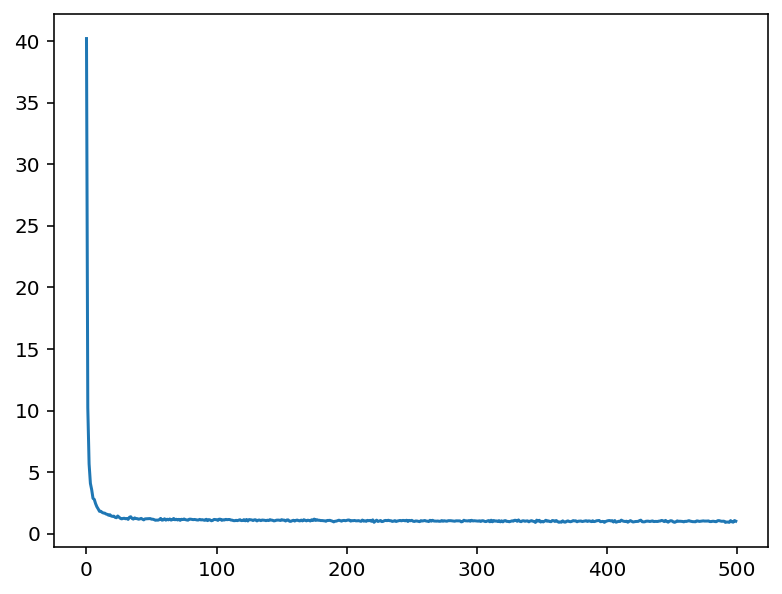

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

base_axis = []

for id in range(len(val_vae_loss)):
    base_axis.append(id)

base_axis = np.array(base_axis)

# 折れ線グラフを出力
val_vae_loss = np.array(val_vae_loss)
plt.plot(base_axis, val_vae_loss)

print(np.argmin(val_vae_loss), np.min(val_vae_loss))